## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


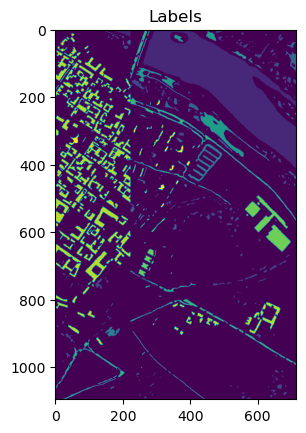

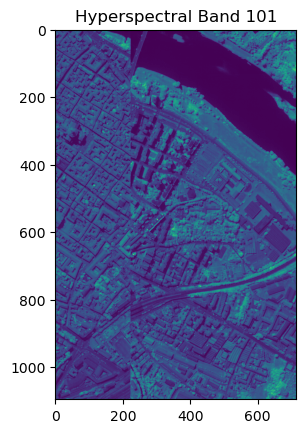

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 40 train


 -- Test set created with: 
	147747 samples
	shape (147747, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(360, 5, 5, 102)
(45, 5, 5, 102)
(147747, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1737, PSNR: 5.3782


	 Training Batch [200/1852], Loss: 0.0932, PSNR: 7.0142


	 Training Batch [400/1852], Loss: 0.0471, PSNR: 9.1916


	 Training Batch [600/1852], Loss: 0.0243, PSNR: 11.2099


	 Training Batch [800/1852], Loss: 0.0166, PSNR: 14.9485


	 Training Batch [1000/1852], Loss: 0.0124, PSNR: 16.1108


	 Training Batch [1200/1852], Loss: 0.0084, PSNR: 16.7308


	 Training Batch [1400/1852], Loss: 0.0076, PSNR: 16.8034


	 Training Batch [1600/1852], Loss: 0.0071, PSNR: 19.6256


	 Training Batch [1800/1852], Loss: 0.0078, PSNR: 17.9854


Epoch [1/50] Training Loss: 0.0321, PSNR: 13.6524
	[Val]   Batch [1/463] Loss: 0.0055, PSNR: 17.8180
	[Val]   Batch [10/463] Loss: 0.0051, PSNR: 18.9882
	[Val]   Batch [20/463] Loss: 0.0052, PSNR: 17.9937
	[Val]   Batch [30/463] Loss: 0.0062, PSNR: 18.5673
	[Val]   Batch [40/463] Loss: 0.0049, PSNR: 17.6584
	[Val]   Batch [50/463] Loss: 0.0052, PSNR: 17.8974


	[Val]   Batch [60/463] Loss: 0.0049, PSNR: 17.9241
	[Val]   Batch [70/463] Loss: 0.0069, PSNR: 18.3264
	[Val]   Batch [80/463] Loss: 0.0062, PSNR: 20.2223
	[Val]   Batch [90/463] Loss: 0.0060, PSNR: 19.3013
	[Val]   Batch [100/463] Loss: 0.0061, PSNR: 19.0056
	[Val]   Batch [110/463] Loss: 0.0070, PSNR: 18.4438
	[Val]   Batch [120/463] Loss: 0.0048, PSNR: 17.9242
	[Val]   Batch [130/463] Loss: 0.0056, PSNR: 19.3055


	[Val]   Batch [140/463] Loss: 0.0065, PSNR: 18.8995
	[Val]   Batch [150/463] Loss: 0.0074, PSNR: 18.9363
	[Val]   Batch [160/463] Loss: 0.0060, PSNR: 19.1751
	[Val]   Batch [170/463] Loss: 0.0077, PSNR: 18.1224
	[Val]   Batch [180/463] Loss: 0.0056, PSNR: 18.8971
	[Val]   Batch [190/463] Loss: 0.0061, PSNR: 19.2405
	[Val]   Batch [200/463] Loss: 0.0061, PSNR: 18.6331


	[Val]   Batch [210/463] Loss: 0.0059, PSNR: 18.2293
	[Val]   Batch [220/463] Loss: 0.0058, PSNR: 19.4366
	[Val]   Batch [230/463] Loss: 0.0069, PSNR: 19.2705
	[Val]   Batch [240/463] Loss: 0.0052, PSNR: 18.0431
	[Val]   Batch [250/463] Loss: 0.0067, PSNR: 17.2771
	[Val]   Batch [260/463] Loss: 0.0058, PSNR: 18.2682
	[Val]   Batch [270/463] Loss: 0.0045, PSNR: 17.4168
	[Val]   Batch [280/463] Loss: 0.0055, PSNR: 20.1440


	[Val]   Batch [290/463] Loss: 0.0061, PSNR: 17.1644
	[Val]   Batch [300/463] Loss: 0.0061, PSNR: 19.4273
	[Val]   Batch [310/463] Loss: 0.0056, PSNR: 19.2929
	[Val]   Batch [320/463] Loss: 0.0057, PSNR: 19.1520
	[Val]   Batch [330/463] Loss: 0.0066, PSNR: 18.5901
	[Val]   Batch [340/463] Loss: 0.0055, PSNR: 19.4996
	[Val]   Batch [350/463] Loss: 0.0071, PSNR: 19.4385


	[Val]   Batch [360/463] Loss: 0.0048, PSNR: 20.3700
	[Val]   Batch [370/463] Loss: 0.0070, PSNR: 18.5142
	[Val]   Batch [380/463] Loss: 0.0069, PSNR: 18.6680
	[Val]   Batch [390/463] Loss: 0.0063, PSNR: 18.4696
	[Val]   Batch [400/463] Loss: 0.0056, PSNR: 17.5054
	[Val]   Batch [410/463] Loss: 0.0054, PSNR: 19.8267
	[Val]   Batch [420/463] Loss: 0.0056, PSNR: 18.6248


	[Val]   Batch [430/463] Loss: 0.0056, PSNR: 18.0296
	[Val]   Batch [440/463] Loss: 0.0055, PSNR: 19.0089
	[Val]   Batch [450/463] Loss: 0.0042, PSNR: 16.3729
	[Val]   Batch [460/463] Loss: 0.0059, PSNR: 17.7737
Epoch [1/50] Validation Loss: 0.0059, PSNR: 18.5990

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0065, PSNR: 18.2933


	 Training Batch [200/1852], Loss: 0.0059, PSNR: 18.9783


	 Training Batch [400/1852], Loss: 0.0049, PSNR: 20.9731


	 Training Batch [600/1852], Loss: 0.0047, PSNR: 20.9272


	 Training Batch [800/1852], Loss: 0.0042, PSNR: 19.8034


	 Training Batch [1000/1852], Loss: 0.0048, PSNR: 18.6782


	 Training Batch [1200/1852], Loss: 0.0034, PSNR: 20.4089


	 Training Batch [1400/1852], Loss: 0.0034, PSNR: 21.1105


	 Training Batch [1600/1852], Loss: 0.0030, PSNR: 20.5108


	 Training Batch [1800/1852], Loss: 0.0023, PSNR: 21.7438


Epoch [2/50] Training Loss: 0.0043, PSNR: 20.1223
	[Val]   Batch [1/463] Loss: 0.0026, PSNR: 21.1415
	[Val]   Batch [10/463] Loss: 0.0024, PSNR: 22.3327
	[Val]   Batch [20/463] Loss: 0.0023, PSNR: 21.4135
	[Val]   Batch [30/463] Loss: 0.0029, PSNR: 21.8515
	[Val]   Batch [40/463] Loss: 0.0023, PSNR: 20.9088
	[Val]   Batch [50/463] Loss: 0.0025, PSNR: 21.1205


	[Val]   Batch [60/463] Loss: 0.0023, PSNR: 21.2181
	[Val]   Batch [70/463] Loss: 0.0033, PSNR: 21.4751
	[Val]   Batch [80/463] Loss: 0.0030, PSNR: 23.2948
	[Val]   Batch [90/463] Loss: 0.0028, PSNR: 22.5873
	[Val]   Batch [100/463] Loss: 0.0030, PSNR: 22.0640
	[Val]   Batch [110/463] Loss: 0.0034, PSNR: 21.6157
	[Val]   Batch [120/463] Loss: 0.0023, PSNR: 21.1457


	[Val]   Batch [130/463] Loss: 0.0026, PSNR: 22.7109
	[Val]   Batch [140/463] Loss: 0.0031, PSNR: 22.0652
	[Val]   Batch [150/463] Loss: 0.0035, PSNR: 22.2147
	[Val]   Batch [160/463] Loss: 0.0030, PSNR: 22.0998
	[Val]   Batch [170/463] Loss: 0.0038, PSNR: 21.2145
	[Val]   Batch [180/463] Loss: 0.0029, PSNR: 21.8117
	[Val]   Batch [190/463] Loss: 0.0028, PSNR: 22.5376
	[Val]   Batch [200/463] Loss: 0.0029, PSNR: 21.7840


	[Val]   Batch [210/463] Loss: 0.0030, PSNR: 21.1174
	[Val]   Batch [220/463] Loss: 0.0029, PSNR: 22.5063
	[Val]   Batch [230/463] Loss: 0.0031, PSNR: 22.6745
	[Val]   Batch [240/463] Loss: 0.0025, PSNR: 21.2999
	[Val]   Batch [250/463] Loss: 0.0033, PSNR: 20.3613
	[Val]   Batch [260/463] Loss: 0.0029, PSNR: 21.3786
	[Val]   Batch [270/463] Loss: 0.0021, PSNR: 20.7727


	[Val]   Batch [280/463] Loss: 0.0026, PSNR: 23.3861
	[Val]   Batch [290/463] Loss: 0.0028, PSNR: 20.4670
	[Val]   Batch [300/463] Loss: 0.0029, PSNR: 22.5635
	[Val]   Batch [310/463] Loss: 0.0029, PSNR: 22.1653
	[Val]   Batch [320/463] Loss: 0.0028, PSNR: 22.3069
	[Val]   Batch [330/463] Loss: 0.0030, PSNR: 21.9520
	[Val]   Batch [340/463] Loss: 0.0026, PSNR: 22.6573
	[Val]   Batch [350/463] Loss: 0.0036, PSNR: 22.3547


	[Val]   Batch [360/463] Loss: 0.0025, PSNR: 23.2247
	[Val]   Batch [370/463] Loss: 0.0032, PSNR: 21.8596
	[Val]   Batch [380/463] Loss: 0.0031, PSNR: 22.1466
	[Val]   Batch [390/463] Loss: 0.0029, PSNR: 21.8780
	[Val]   Batch [400/463] Loss: 0.0027, PSNR: 20.6257
	[Val]   Batch [410/463] Loss: 0.0025, PSNR: 23.1550
	[Val]   Batch [420/463] Loss: 0.0026, PSNR: 21.9832
	[Val]   Batch [430/463] Loss: 0.0027, PSNR: 21.0834


	[Val]   Batch [440/463] Loss: 0.0027, PSNR: 22.0817
	[Val]   Batch [450/463] Loss: 0.0021, PSNR: 19.4935
	[Val]   Batch [460/463] Loss: 0.0028, PSNR: 21.0637
Epoch [2/50] Validation Loss: 0.0028, PSNR: 21.8182

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0029, PSNR: 20.1903


	 Training Batch [200/1852], Loss: 0.0035, PSNR: 21.6122


	 Training Batch [400/1852], Loss: 0.0023, PSNR: 21.5358


	 Training Batch [600/1852], Loss: 0.0021, PSNR: 22.8623


	 Training Batch [800/1852], Loss: 0.0028, PSNR: 23.1812


	 Training Batch [1000/1852], Loss: 0.0019, PSNR: 22.3649


	 Training Batch [1200/1852], Loss: 0.0020, PSNR: 22.6984


	 Training Batch [1400/1852], Loss: 0.0020, PSNR: 22.7927


	 Training Batch [1600/1852], Loss: 0.0017, PSNR: 24.4655


	 Training Batch [1800/1852], Loss: 0.0017, PSNR: 24.7967


Epoch [3/50] Training Loss: 0.0023, PSNR: 22.8851
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.5618
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.7851
	[Val]   Batch [20/463] Loss: 0.0013, PSNR: 23.9693
	[Val]   Batch [30/463] Loss: 0.0016, PSNR: 24.4639
	[Val]   Batch [40/463] Loss: 0.0014, PSNR: 23.0763
	[Val]   Batch [50/463] Loss: 0.0014, PSNR: 23.4797
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.4796


	[Val]   Batch [70/463] Loss: 0.0018, PSNR: 24.0995
	[Val]   Batch [80/463] Loss: 0.0016, PSNR: 26.0146
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 25.0412
	[Val]   Batch [100/463] Loss: 0.0017, PSNR: 24.6320
	[Val]   Batch [110/463] Loss: 0.0018, PSNR: 24.3374
	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.3654
	[Val]   Batch [130/463] Loss: 0.0014, PSNR: 25.4230


	[Val]   Batch [140/463] Loss: 0.0017, PSNR: 24.6160
	[Val]   Batch [150/463] Loss: 0.0018, PSNR: 25.1662
	[Val]   Batch [160/463] Loss: 0.0018, PSNR: 24.2935
	[Val]   Batch [170/463] Loss: 0.0022, PSNR: 23.6164
	[Val]   Batch [180/463] Loss: 0.0017, PSNR: 24.1476
	[Val]   Batch [190/463] Loss: 0.0015, PSNR: 25.1788
	[Val]   Batch [200/463] Loss: 0.0015, PSNR: 24.5658


	[Val]   Batch [210/463] Loss: 0.0018, PSNR: 23.3029
	[Val]   Batch [220/463] Loss: 0.0017, PSNR: 24.7588
	[Val]   Batch [230/463] Loss: 0.0016, PSNR: 25.7365
	[Val]   Batch [240/463] Loss: 0.0014, PSNR: 23.7460
	[Val]   Batch [250/463] Loss: 0.0019, PSNR: 22.6456
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.6631
	[Val]   Batch [270/463] Loss: 0.0012, PSNR: 23.0940


	[Val]   Batch [280/463] Loss: 0.0015, PSNR: 25.8160
	[Val]   Batch [290/463] Loss: 0.0016, PSNR: 22.9082
	[Val]   Batch [300/463] Loss: 0.0017, PSNR: 24.8791
	[Val]   Batch [310/463] Loss: 0.0018, PSNR: 24.3519
	[Val]   Batch [320/463] Loss: 0.0016, PSNR: 24.8128
	[Val]   Batch [330/463] Loss: 0.0016, PSNR: 24.6937
	[Val]   Batch [340/463] Loss: 0.0015, PSNR: 25.1034


	[Val]   Batch [350/463] Loss: 0.0021, PSNR: 24.7875
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.9651
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.4848
	[Val]   Batch [380/463] Loss: 0.0016, PSNR: 25.1158
	[Val]   Batch [390/463] Loss: 0.0015, PSNR: 24.6985
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.7908
	[Val]   Batch [410/463] Loss: 0.0014, PSNR: 25.6551


	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.5265
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.2091
	[Val]   Batch [440/463] Loss: 0.0016, PSNR: 24.3569
	[Val]   Batch [450/463] Loss: 0.0013, PSNR: 21.5045
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.4922
Epoch [3/50] Validation Loss: 0.0016, PSNR: 24.3089

LOG: Epoch [4/50]
	 Training Batch [1/1852], Loss: 0.0019, PSNR: 23.4991


	 Training Batch [200/1852], Loss: 0.0016, PSNR: 22.1052


	 Training Batch [400/1852], Loss: 0.0015, PSNR: 25.0490


	 Training Batch [600/1852], Loss: 0.0019, PSNR: 23.1541


	 Training Batch [800/1852], Loss: 0.0017, PSNR: 24.5323


	 Training Batch [1000/1852], Loss: 0.0015, PSNR: 24.7872


	 Training Batch [1200/1852], Loss: 0.0014, PSNR: 24.6786


	 Training Batch [1400/1852], Loss: 0.0013, PSNR: 25.2744


	 Training Batch [1600/1852], Loss: 0.0015, PSNR: 25.4862


	 Training Batch [1800/1852], Loss: 0.0011, PSNR: 25.1865


Epoch [4/50] Training Loss: 0.0015, PSNR: 24.5152
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.8712
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 26.1464
	[Val]   Batch [20/463] Loss: 0.0009, PSNR: 25.3449
	[Val]   Batch [30/463] Loss: 0.0011, PSNR: 25.9092
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.3307
	[Val]   Batch [50/463] Loss: 0.0010, PSNR: 24.8323
	[Val]   Batch [60/463] Loss: 0.0010, PSNR: 24.7716


	[Val]   Batch [70/463] Loss: 0.0013, PSNR: 25.5567
	[Val]   Batch [80/463] Loss: 0.0011, PSNR: 27.6740
	[Val]   Batch [90/463] Loss: 0.0011, PSNR: 26.5239
	[Val]   Batch [100/463] Loss: 0.0012, PSNR: 26.1010
	[Val]   Batch [110/463] Loss: 0.0012, PSNR: 25.9422
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.7013
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.8686


	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 26.0727
	[Val]   Batch [150/463] Loss: 0.0012, PSNR: 26.7789
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.5747
	[Val]   Batch [170/463] Loss: 0.0016, PSNR: 24.9700
	[Val]   Batch [180/463] Loss: 0.0012, PSNR: 25.4859
	[Val]   Batch [190/463] Loss: 0.0011, PSNR: 26.5926
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 26.1519
	[Val]   Batch [210/463] Loss: 0.0013, PSNR: 24.6192


	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 26.0755
	[Val]   Batch [230/463] Loss: 0.0010, PSNR: 27.4415
	[Val]   Batch [240/463] Loss: 0.0010, PSNR: 25.1515
	[Val]   Batch [250/463] Loss: 0.0014, PSNR: 23.9690
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.9041
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.5050
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 27.2243
	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.3588


	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.0850
	[Val]   Batch [310/463] Loss: 0.0013, PSNR: 25.6822
	[Val]   Batch [320/463] Loss: 0.0011, PSNR: 26.3014
	[Val]   Batch [330/463] Loss: 0.0011, PSNR: 26.2463
	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.5107
	[Val]   Batch [350/463] Loss: 0.0015, PSNR: 26.2463
	[Val]   Batch [360/463] Loss: 0.0013, PSNR: 25.9600


	[Val]   Batch [370/463] Loss: 0.0012, PSNR: 26.0011
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.7329
	[Val]   Batch [390/463] Loss: 0.0010, PSNR: 26.3038
	[Val]   Batch [400/463] Loss: 0.0012, PSNR: 24.0797
	[Val]   Batch [410/463] Loss: 0.0010, PSNR: 27.0981
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.8754


	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.4031
	[Val]   Batch [440/463] Loss: 0.0012, PSNR: 25.7778
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.7773
	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.8188
Epoch [4/50] Validation Loss: 0.0011, PSNR: 25.7298

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0013, PSNR: 27.9559


	 Training Batch [200/1852], Loss: 0.0018, PSNR: 23.7031


	 Training Batch [400/1852], Loss: 0.0012, PSNR: 24.7394


	 Training Batch [600/1852], Loss: 0.0011, PSNR: 25.3162


	 Training Batch [800/1852], Loss: 0.0013, PSNR: 26.4784


	 Training Batch [1000/1852], Loss: 0.0011, PSNR: 26.7880


	 Training Batch [1200/1852], Loss: 0.0010, PSNR: 26.7680


	 Training Batch [1400/1852], Loss: 0.0011, PSNR: 27.4297


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 25.2192


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 27.2123


Epoch [5/50] Training Loss: 0.0012, PSNR: 25.6527
	[Val]   Batch [1/463] Loss: 0.0008, PSNR: 26.0251
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 27.3485
	[Val]   Batch [20/463] Loss: 0.0007, PSNR: 26.5761
	[Val]   Batch [30/463] Loss: 0.0009, PSNR: 27.0559
	[Val]   Batch [40/463] Loss: 0.0008, PSNR: 25.4845
	[Val]   Batch [50/463] Loss: 0.0008, PSNR: 26.1194


	[Val]   Batch [60/463] Loss: 0.0008, PSNR: 25.8702
	[Val]   Batch [70/463] Loss: 0.0010, PSNR: 26.7680
	[Val]   Batch [80/463] Loss: 0.0008, PSNR: 29.1213
	[Val]   Batch [90/463] Loss: 0.0008, PSNR: 27.7674
	[Val]   Batch [100/463] Loss: 0.0009, PSNR: 27.3115
	[Val]   Batch [110/463] Loss: 0.0009, PSNR: 27.2498
	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.8971


	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 28.0408
	[Val]   Batch [140/463] Loss: 0.0009, PSNR: 27.2838
	[Val]   Batch [150/463] Loss: 0.0009, PSNR: 28.1568
	[Val]   Batch [160/463] Loss: 0.0011, PSNR: 26.7021
	[Val]   Batch [170/463] Loss: 0.0012, PSNR: 26.1173
	[Val]   Batch [180/463] Loss: 0.0009, PSNR: 26.6741
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.7756


	[Val]   Batch [200/463] Loss: 0.0008, PSNR: 27.5048
	[Val]   Batch [210/463] Loss: 0.0010, PSNR: 25.7830
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 27.1659
	[Val]   Batch [230/463] Loss: 0.0008, PSNR: 28.7995
	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.3795
	[Val]   Batch [250/463] Loss: 0.0011, PSNR: 25.1134
	[Val]   Batch [260/463] Loss: 0.0010, PSNR: 26.0464


	[Val]   Batch [270/463] Loss: 0.0006, PSNR: 25.8365
	[Val]   Batch [280/463] Loss: 0.0008, PSNR: 28.4215
	[Val]   Batch [290/463] Loss: 0.0009, PSNR: 25.5936
	[Val]   Batch [300/463] Loss: 0.0010, PSNR: 27.1815
	[Val]   Batch [310/463] Loss: 0.0010, PSNR: 26.8443
	[Val]   Batch [320/463] Loss: 0.0008, PSNR: 27.6197


	[Val]   Batch [330/463] Loss: 0.0008, PSNR: 27.4972
	[Val]   Batch [340/463] Loss: 0.0008, PSNR: 27.7401
	[Val]   Batch [350/463] Loss: 0.0011, PSNR: 27.4234
	[Val]   Batch [360/463] Loss: 0.0011, PSNR: 26.8071
	[Val]   Batch [370/463] Loss: 0.0009, PSNR: 27.2573
	[Val]   Batch [380/463] Loss: 0.0008, PSNR: 28.1353
	[Val]   Batch [390/463] Loss: 0.0008, PSNR: 27.6187


	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 25.1807
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 28.2711
	[Val]   Batch [420/463] Loss: 0.0008, PSNR: 27.0746
	[Val]   Batch [430/463] Loss: 0.0010, PSNR: 25.4777
	[Val]   Batch [440/463] Loss: 0.0009, PSNR: 26.8641
	[Val]   Batch [450/463] Loss: 0.0007, PSNR: 23.9235


	[Val]   Batch [460/463] Loss: 0.0009, PSNR: 26.0527
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.9598

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0010, PSNR: 26.9609


	 Training Batch [200/1852], Loss: 0.0012, PSNR: 26.8551


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 26.6113


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 27.7756


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 26.9550


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 25.3614


	 Training Batch [1200/1852], Loss: 0.0010, PSNR: 26.8848


	 Training Batch [1400/1852], Loss: 0.0007, PSNR: 28.4181


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.5151


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 26.0430


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.4840
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.7256
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0759
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.3015
	[Val]   Batch [30/463] Loss: 0.0007, PSNR: 27.7369
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.2485
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 26.9998
	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.5803


	[Val]   Batch [70/463] Loss: 0.0008, PSNR: 27.5285
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.9886
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.4740
	[Val]   Batch [100/463] Loss: 0.0007, PSNR: 28.1462
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 28.0569
	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 26.6820
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.7610
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.0044


	[Val]   Batch [150/463] Loss: 0.0007, PSNR: 29.0119
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.5412
	[Val]   Batch [170/463] Loss: 0.0010, PSNR: 26.8841
	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.4572
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.4763
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.2644


	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.6114
	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 27.8477
	[Val]   Batch [230/463] Loss: 0.0007, PSNR: 29.5195
	[Val]   Batch [240/463] Loss: 0.0006, PSNR: 27.1297
	[Val]   Batch [250/463] Loss: 0.0009, PSNR: 25.9366
	[Val]   Batch [260/463] Loss: 0.0008, PSNR: 26.8907
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.6248


	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.1964
	[Val]   Batch [290/463] Loss: 0.0007, PSNR: 26.3783
	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.8161
	[Val]   Batch [310/463] Loss: 0.0008, PSNR: 27.6904
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.4870
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.2164
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.5388
	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 28.1743


	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.3551
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 28.0135
	[Val]   Batch [380/463] Loss: 0.0007, PSNR: 28.8551
	[Val]   Batch [390/463] Loss: 0.0007, PSNR: 28.3371
	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.9022
	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 28.9845
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.7547
	[Val]   Batch [430/463] Loss: 0.0008, PSNR: 26.2573


	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.5576
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.7458
	[Val]   Batch [460/463] Loss: 0.0007, PSNR: 26.8675
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.7269

LOG: Epoch [7/50]
	 Training Batch [1/1852], Loss: 0.0007, PSNR: 26.2999


	 Training Batch [200/1852], Loss: 0.0008, PSNR: 26.8669


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 26.0284


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 25.6360


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 26.5610


	 Training Batch [1000/1852], Loss: 0.0013, PSNR: 25.2200


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 27.1957


	 Training Batch [1400/1852], Loss: 0.0008, PSNR: 27.0327


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 28.5809


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 27.2170


Epoch [7/50] Training Loss: 0.0008, PSNR: 27.2079
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.5345
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 29.0082
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.2346
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.6177
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 27.0891
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 27.9598
	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.4031


	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.4942
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 31.0295
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.4590
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 29.0169
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 29.0128
	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.5309
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.6357
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.8722


	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 30.1097
	[Val]   Batch [160/463] Loss: 0.0007, PSNR: 28.5382
	[Val]   Batch [170/463] Loss: 0.0008, PSNR: 27.8153
	[Val]   Batch [180/463] Loss: 0.0006, PSNR: 28.3591
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.3378
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.2238
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.5822


	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.6469
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.5019
	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 27.9976
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 26.8897
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 27.8665
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.5816
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 30.0447
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.3293


	[Val]   Batch [300/463] Loss: 0.0007, PSNR: 28.7393
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.5533
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 29.4286
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 29.1382
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 29.4901
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 29.1191
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 27.9241
	[Val]   Batch [370/463] Loss: 0.0006, PSNR: 28.9770


	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.9546
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.3301
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.7042
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 29.8700
	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.7291
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 27.1118


	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.3990
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.6049
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.8651
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.6584

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 26.9365


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 26.3246


	 Training Batch [400/1852], Loss: 0.0009, PSNR: 28.0762


	 Training Batch [600/1852], Loss: 0.0008, PSNR: 26.2443


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.1927


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 26.2892


	 Training Batch [1200/1852], Loss: 0.0008, PSNR: 27.5783


	 Training Batch [1400/1852], Loss: 0.0010, PSNR: 27.8341


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.8850


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 26.8626


Epoch [8/50] Training Loss: 0.0007, PSNR: 27.7550
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.2740
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.8827
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.1013
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.3970
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.8076
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 28.8606
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 28.1322


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 29.2886
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.9303
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.2909
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.7790
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.8376
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.3254
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.4340
	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.6202


	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 31.0439
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.3895
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.5638
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.0809
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.1253
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.1170
	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.4288
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.3815


	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.3282
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 28.8476
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 27.6905
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.7349
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.5312
	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.8040
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 28.1418


	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.5171
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.3442
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.2608
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.9900
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.2913
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 29.9024
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.3876
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.7642


	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.9182
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.1956
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.3883
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.6308
	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.5471
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.8840
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.0106


	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.3789
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.7644
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.4813

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.0305


	 Training Batch [200/1852], Loss: 0.0010, PSNR: 27.2941


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 29.2493


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 28.6684


	 Training Batch [800/1852], Loss: 0.0008, PSNR: 26.3712


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 28.0061


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 30.4692


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.4569


	 Training Batch [1600/1852], Loss: 0.0008, PSNR: 26.8459


	 Training Batch [1800/1852], Loss: 0.0006, PSNR: 29.3578


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.2011
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.8643
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.5288
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.6878
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.0113
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.3589
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.5037


	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.7777
	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.9533
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.6488
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.9113
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.4171
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.4999
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.9252


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.0682
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.2450
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.8223
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.0835
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.1832
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.7015
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.6837


	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.7841
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.0969
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.9431
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.9866
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.4917
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.3118
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.4400
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.2115


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.4284
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.8474
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.0930
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.9660
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.9309
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.6580
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.9858
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.5669


	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.7547
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.4363
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.6612
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.8593
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.9438
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.2251
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.1754
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.5080


	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.5872
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.0477
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.3920
Epoch [9/50] Validation Loss: 0.0004, PSNR: 30.1225

LOG: Epoch [10/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.3948


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.4805


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.9751


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 29.3721


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.1578


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 28.7952


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.8758


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.4393


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.6583


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.4364


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.6180
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.9761
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.7492
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 29.8341
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.2217
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.4643
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.7001


	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.9099
	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 30.1726
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 32.7060
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.1079
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.6359
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.6464


	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 29.0074
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.1928
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.3466
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 32.0096
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.3267
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.4468


	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 29.8751
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.7649
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.8477
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.3538
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.0534
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 32.0833


	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.7036
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.5490
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.7116
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.2339
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.5452
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.0642


	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.2579
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.1357
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.0896
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.8537
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.1400


	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.7665
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.8422
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.6326
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.8462
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.9785
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.1389
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.3486


	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.2738
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.6973
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.7802
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 27.0916
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.5457
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.2725

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 28.7430


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 27.9862


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.0956


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 29.4771


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.6382


	 Training Batch [1000/1852], Loss: 0.0007, PSNR: 29.1542


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 28.6946


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.4849


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 29.5875


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 30.8502


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.9513
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.5175
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.3160
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.3648
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.7241
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.0348
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.3291
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.5060


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.7170
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.3544
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.6559
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.1475
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.2463
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.5796
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.7757


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.9024
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.5936
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.9319
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.8745
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.4533
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.3078
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.5125


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.9587
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.5697
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.6423
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.2592
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.0020
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.2008
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 29.9868


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 32.0849
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.6260
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 30.8661
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.7443
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.6630
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.3737


	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.7133
	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.3466
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.1603
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.1295
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.4342
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.5005


	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.6125
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.8079
	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.8431
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.2571
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.2958
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.7916
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.1079
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.8420

LOG: Epoch [12/50]


	 Training Batch [1/1852], Loss: 0.0005, PSNR: 28.5302


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 29.8236


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 28.0797


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 29.0997


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.0695


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 29.0281


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.3098


	 Training Batch [1400/1852], Loss: 0.0004, PSNR: 29.7825


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 27.5677


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 28.0086


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.2357
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.8969
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.8004
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.8092
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.1615
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.3873
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.7453


	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.9154
	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 31.2668
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.8247
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.1165
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.6106
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.7292
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.9301


	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.2139
	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.3426
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.1671
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.4139
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.3308
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.8778
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.7157


	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.9301
	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.4026
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.9196
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.1337
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.6972
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.4385
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.7465


	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.3061
	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.4793
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.1102
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3007
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.1274
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.0963
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.8813
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.1638


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.7573
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.3958
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.6138
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 33.0341
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.9858
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.0231
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.1823


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.2356
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.6094
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.6765
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.1613
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.5189
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.2813
Early stopping triggered at epoch 12. No improvement for 3 epochs.


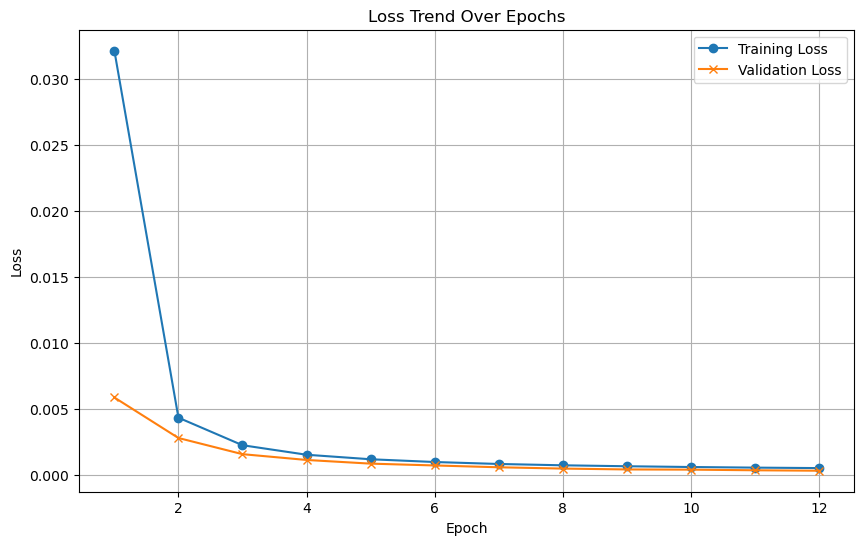

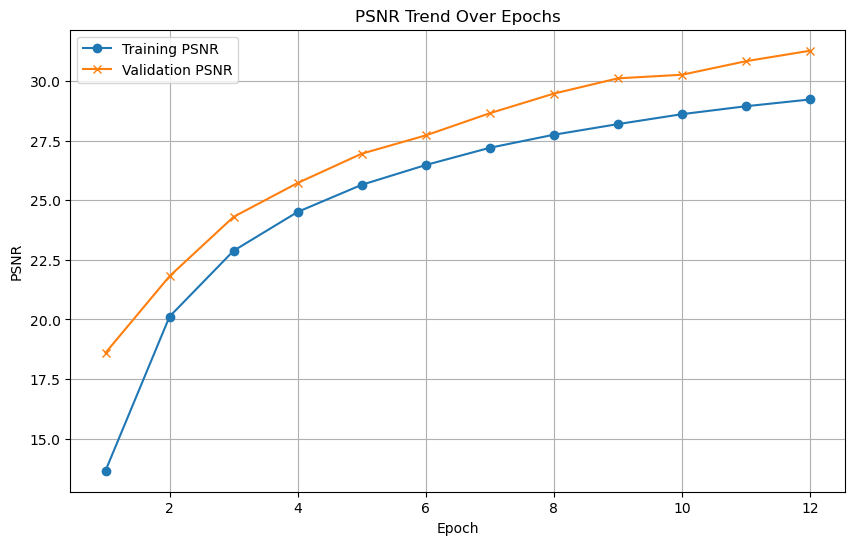

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1957
    Validation Batch [1/1], Loss: 2.2013
Validation Loss: 2.2013, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2013. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1340
    Validation Batch [1/1], Loss: 2.2012
Validation Loss: 2.2012, Validation Accuracy: 11.11%
Validation loss improved from 2.2013 to 2.2012. Saving model...

LOG: Epoch [3/1000] - Training


Epoch [3/1000] completed, Average Training Loss: 2.0967
    Validation Batch [1/1], Loss: 2.2012
Validation Loss: 2.2012, Validation Accuracy: 11.11%
Validation loss improved from 2.2012 to 2.2012. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0587
    Validation Batch [1/1], Loss: 2.2011
Validation Loss: 2.2011, Validation Accuracy: 11.11%
Validation loss improved from 2.2012 to 2.2011. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.0262
    Validation Batch [1/1], Loss: 2.2010
Validation Loss: 2.2010, Validation Accuracy: 11.11%
Validation loss improved from 2.2011 to 2.2010. Saving model...

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 1.9897
    Validation Batch [1/1], Loss: 2.2009
Validation Loss: 2.2009, Validation Accuracy: 11.11%
Validation loss improved from 2.2010 to 2.2009. Saving model...

LOG: Epoch [7/1000] - Training
Epoch [7/1000] c

Epoch [20/1000] completed, Average Training Loss: 1.6684
    Validation Batch [1/1], Loss: 1.9836
Validation Loss: 1.9836, Validation Accuracy: 42.22%
Validation loss improved from 2.0240 to 1.9836. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 1.6463
    Validation Batch [1/1], Loss: 1.9408
Validation Loss: 1.9408, Validation Accuracy: 48.89%
Validation loss improved from 1.9836 to 1.9408. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.6495
    Validation Batch [1/1], Loss: 1.8943
Validation Loss: 1.8943, Validation Accuracy: 55.56%
Validation loss improved from 1.9408 to 1.8943. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.6132
    Validation Batch [1/1], Loss: 1.8460
Validation Loss: 1.8460, Validation Accuracy: 71.11%
Validation loss improved from 1.8943 to 1.8460. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [2

Epoch [37/1000] completed, Average Training Loss: 1.3731
    Validation Batch [1/1], Loss: 1.3751
Validation Loss: 1.3751, Validation Accuracy: 88.89%
Validation loss improved from 1.4115 to 1.3751. Saving model...

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 1.3738
    Validation Batch [1/1], Loss: 1.3517
Validation Loss: 1.3517, Validation Accuracy: 91.11%
Validation loss improved from 1.3751 to 1.3517. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.3419
    Validation Batch [1/1], Loss: 1.3373
Validation Loss: 1.3373, Validation Accuracy: 88.89%
Validation loss improved from 1.3517 to 1.3373. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.3244
    Validation Batch [1/1], Loss: 1.3207
Validation Loss: 1.3207, Validation Accuracy: 88.89%
Validation loss improved from 1.3373 to 1.3207. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [4

Epoch [54/1000] completed, Average Training Loss: 1.1217
    Validation Batch [1/1], Loss: 1.0747
Validation Loss: 1.0747, Validation Accuracy: 93.33%
Validation loss improved from 1.0843 to 1.0747. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 1.0656
    Validation Batch [1/1], Loss: 1.0452
Validation Loss: 1.0452, Validation Accuracy: 93.33%
Validation loss improved from 1.0747 to 1.0452. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.0631
    Validation Batch [1/1], Loss: 1.0297
Validation Loss: 1.0297, Validation Accuracy: 93.33%
Validation loss improved from 1.0452 to 1.0297. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.0579
    Validation Batch [1/1], Loss: 1.0195
Validation Loss: 1.0195, Validation Accuracy: 93.33%
Validation loss improved from 1.0297 to 1.0195. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [5

Epoch [71/1000] completed, Average Training Loss: 0.8499
    Validation Batch [1/1], Loss: 0.8061
Validation Loss: 0.8061, Validation Accuracy: 93.33%
Validation loss improved from 0.8280 to 0.8061. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 0.8314
    Validation Batch [1/1], Loss: 0.7745
Validation Loss: 0.7745, Validation Accuracy: 93.33%
Validation loss improved from 0.8061 to 0.7745. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 0.8148
    Validation Batch [1/1], Loss: 0.7882
Validation Loss: 0.7882, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 0.7915
    Validation Batch [1/1], Loss: 0.7671
Validation Loss: 0.7671, Validation Accuracy: 93.33%
Validation loss improved from 0.7745 to 0.7671. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] complet

Epoch [88/1000] completed, Average Training Loss: 0.6357
    Validation Batch [1/1], Loss: 0.5837
Validation Loss: 0.5837, Validation Accuracy: 93.33%
Validation loss improved from 0.6045 to 0.5837. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 0.6186
    Validation Batch [1/1], Loss: 0.6107
Validation Loss: 0.6107, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 0.6372
    Validation Batch [1/1], Loss: 0.5556
Validation Loss: 0.5556, Validation Accuracy: 93.33%
Validation loss improved from 0.5837 to 0.5556. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 0.6010
    Validation Batch [1/1], Loss: 0.5724
Validation Loss: 0.5724, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Tra

Epoch [105/1000] completed, Average Training Loss: 0.4611
    Validation Batch [1/1], Loss: 0.4110
Validation Loss: 0.4110, Validation Accuracy: 97.78%
Validation loss improved from 0.4144 to 0.4110. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 0.4175
    Validation Batch [1/1], Loss: 0.3888
Validation Loss: 0.3888, Validation Accuracy: 97.78%
Validation loss improved from 0.4110 to 0.3888. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 0.4194
    Validation Batch [1/1], Loss: 0.4023
Validation Loss: 0.4023, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 0.3968
    Validation Batch [1/1], Loss: 0.3787
Validation Loss: 0.3787, Validation Accuracy: 95.56%
Validation loss improved from 0.3888 to 0.3787. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000

    Validation Batch [1/1], Loss: 0.3131
Validation Loss: 0.3131, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 0.3013
    Validation Batch [1/1], Loss: 0.3522
Validation Loss: 0.3522, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.3185
    Validation Batch [1/1], Loss: 0.2820
Validation Loss: 0.2820, Validation Accuracy: 97.78%
Validation loss improved from 0.2917 to 0.2820. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.2952
    Validation Batch [1/1], Loss: 0.2675
Validation Loss: 0.2675, Validation Accuracy: 100.00%
Validation loss improved from 0.2820 to 0.2675. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.2878
    Validation Batch [1/1], L

Epoch [139/1000] completed, Average Training Loss: 0.2143
    Validation Batch [1/1], Loss: 0.2220
Validation Loss: 0.2220, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.2111
    Validation Batch [1/1], Loss: 0.2055
Validation Loss: 0.2055, Validation Accuracy: 100.00%
Validation loss improved from 0.2118 to 0.2055. Saving model...

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.2229
    Validation Batch [1/1], Loss: 0.2014
Validation Loss: 0.2014, Validation Accuracy: 100.00%
Validation loss improved from 0.2055 to 0.2014. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 0.2017
    Validation Batch [1/1], Loss: 0.2084
Validation Loss: 0.2084, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed

Epoch [156/1000] completed, Average Training Loss: 0.1609
    Validation Batch [1/1], Loss: 0.1858
Validation Loss: 0.1858, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.1573
    Validation Batch [1/1], Loss: 0.1581
Validation Loss: 0.1581, Validation Accuracy: 100.00%
Validation loss improved from 0.1627 to 0.1581. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.1439
    Validation Batch [1/1], Loss: 0.1493
Validation Loss: 0.1493, Validation Accuracy: 100.00%
Validation loss improved from 0.1581 to 0.1493. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 0.1518
    Validation Batch [1/1], Loss: 0.1784
Validation Loss: 0.1784, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, 

Epoch [173/1000] completed, Average Training Loss: 0.1199
    Validation Batch [1/1], Loss: 0.1202
Validation Loss: 0.1202, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.1143
    Validation Batch [1/1], Loss: 0.1226
Validation Loss: 0.1226, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.1192
    Validation Batch [1/1], Loss: 0.1482
Validation Loss: 0.1482, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.1293
    Validation Batch [1/1], Loss: 0.1349
Validation Loss: 0.1349, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.1277

Epoch [191/1000] completed, Average Training Loss: 0.0990
    Validation Batch [1/1], Loss: 0.1103
Validation Loss: 0.1103, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.0869
    Validation Batch [1/1], Loss: 0.1012
Validation Loss: 0.1012, Validation Accuracy: 100.00%
Validation loss improved from 0.1021 to 0.1012. Saving model...

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.0879
    Validation Batch [1/1], Loss: 0.0966
Validation Loss: 0.0966, Validation Accuracy: 100.00%
Validation loss improved from 0.1012 to 0.0966. Saving model...

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.0902
    Validation Batch [1/1], Loss: 0.1026
Validation Loss: 0.1026, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed

    Validation Batch [1/1], Loss: 0.0962
Validation Loss: 0.0962, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.0762
    Validation Batch [1/1], Loss: 0.1011
Validation Loss: 0.1011, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.0891
Validation Loss: 0.0891, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.0691
    Validation Batch [1/1], Loss: 0.0924
Validation Loss: 0.0924, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.0702
    Validation Batch [1/1], Loss: 0.0774
Validation Loss: 0

Epoch [225/1000] completed, Average Training Loss: 0.0544
    Validation Batch [1/1], Loss: 0.0736
Validation Loss: 0.0736, Validation Accuracy: 100.00%
Validation loss improved from 0.0744 to 0.0736. Saving model...

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.0581
    Validation Batch [1/1], Loss: 0.0751
Validation Loss: 0.0751, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.0568
    Validation Batch [1/1], Loss: 0.0811
Validation Loss: 0.0811, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.0669
Validation Loss: 0.0669, Validation Accuracy: 100.00%
Validation loss improved from 0.0736 to 0.0669. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed

    Validation Batch [1/1], Loss: 0.0628
Validation Loss: 0.0628, Validation Accuracy: 100.00%
Validation loss improved from 0.0640 to 0.0628. Saving model...

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.0520
    Validation Batch [1/1], Loss: 0.0707
Validation Loss: 0.0707, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.0503
    Validation Batch [1/1], Loss: 0.0826
Validation Loss: 0.0826, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.0586
Validation Loss: 0.0586, Validation Accuracy: 100.00%
Validation loss improved from 0.0628 to 0.0586. Saving model...

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.0431
    Validation Batch [1/1],

Epoch [260/1000] completed, Average Training Loss: 0.0392
    Validation Batch [1/1], Loss: 0.0542
Validation Loss: 0.0542, Validation Accuracy: 100.00%
Validation loss improved from 0.0568 to 0.0542. Saving model...

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.0476
    Validation Batch [1/1], Loss: 0.0531
Validation Loss: 0.0531, Validation Accuracy: 100.00%
Validation loss improved from 0.0542 to 0.0531. Saving model...

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.0414
    Validation Batch [1/1], Loss: 0.0530
Validation Loss: 0.0530, Validation Accuracy: 100.00%
Validation loss improved from 0.0531 to 0.0530. Saving model...

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.0395
    Validation Batch [1/1], Loss: 0.0531
Validation Loss: 0.0531, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [264/1000] - Training
Epoch [264/

Epoch [277/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.0530
Validation Loss: 0.0530, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.0483
Validation Loss: 0.0483, Validation Accuracy: 100.00%
Validation loss improved from 0.0498 to 0.0483. Saving model...

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.0340
    Validation Batch [1/1], Loss: 0.0483
Validation Loss: 0.0483, Validation Accuracy: 100.00%
Validation loss improved from 0.0483 to 0.0483. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.0332
    Validation Batch [1/1], Loss: 0.0506
Validation Loss: 0.0506, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed

Epoch [295/1000] completed, Average Training Loss: 0.0311
    Validation Batch [1/1], Loss: 0.0615
Validation Loss: 0.0615, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.0509
Validation Loss: 0.0509, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.0331
    Validation Batch [1/1], Loss: 0.0542
Validation Loss: 0.0542, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.0291
    Validation Batch [1/1], Loss: 0.0584
Validation Loss: 0.0584, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.

Epoch [313/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.0386
Validation Loss: 0.0386, Validation Accuracy: 100.00%
Validation loss improved from 0.0424 to 0.0386. Saving model...

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.0284
    Validation Batch [1/1], Loss: 0.0669
Validation Loss: 0.0669, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.0575
Validation Loss: 0.0575, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.0380
Validation Loss: 0.0380, Validation Accuracy: 100.00%
Validation loss improved from 0.0386 to 0.0380. Saving model...

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, 

Epoch [330/1000] completed, Average Training Loss: 0.0212
    Validation Batch [1/1], Loss: 0.0505
Validation Loss: 0.0505, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.0215
    Validation Batch [1/1], Loss: 0.0663
Validation Loss: 0.0663, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.0241
    Validation Batch [1/1], Loss: 0.0776
Validation Loss: 0.0776, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.0249
    Validation Batch [1/1], Loss: 0.0601
Validation Loss: 0.0601, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.02

Epoch [347/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.0353
Validation Loss: 0.0353, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0193
    Validation Batch [1/1], Loss: 0.0362
Validation Loss: 0.0362, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.0379
Validation Loss: 0.0379, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.0415
Validation Loss: 0.0415, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.019

Epoch [364/1000] completed, Average Training Loss: 0.0183
    Validation Batch [1/1], Loss: 0.0446
Validation Loss: 0.0446, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.0187
    Validation Batch [1/1], Loss: 0.0540
Validation Loss: 0.0540, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.0174
    Validation Batch [1/1], Loss: 0.0510
Validation Loss: 0.0510, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.0187
    Validation Batch [1/1], Loss: 0.0416
Validation Loss: 0.0416, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.0

Epoch [381/1000] completed, Average Training Loss: 0.0149
    Validation Batch [1/1], Loss: 0.0489
Validation Loss: 0.0489, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.0180
    Validation Batch [1/1], Loss: 0.0332
Validation Loss: 0.0332, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.0176
    Validation Batch [1/1], Loss: 0.0385
Validation Loss: 0.0385, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [384/1000] - Training
Epoch [384/1000] completed, Average Training Loss: 0.0149
    Validation Batch [1/1], Loss: 0.0439
Validation Loss: 0.0439, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.0

Epoch [398/1000] completed, Average Training Loss: 0.0136
    Validation Batch [1/1], Loss: 0.0484
Validation Loss: 0.0484, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.0155
    Validation Batch [1/1], Loss: 0.0349
Validation Loss: 0.0349, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.0170
    Validation Batch [1/1], Loss: 0.0422
Validation Loss: 0.0422, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.0153
    Validation Batch [1/1], Loss: 0.0646
Validation Loss: 0.0646, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0

Epoch [415/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.0281
Validation Loss: 0.0281, Validation Accuracy: 100.00%
Validation loss improved from 0.0283 to 0.0281. Saving model...

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.0139
    Validation Batch [1/1], Loss: 0.0295
Validation Loss: 0.0295, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.0156
    Validation Batch [1/1], Loss: 0.0306
Validation Loss: 0.0306, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.0131
    Validation Batch [1/1], Loss: 0.0328
Validation Loss: 0.0328, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Train

    Validation Batch [1/1], Loss: 0.0352
Validation Loss: 0.0352, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.0138
    Validation Batch [1/1], Loss: 0.0420
Validation Loss: 0.0420, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0133
    Validation Batch [1/1], Loss: 0.0556
Validation Loss: 0.0556, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0135
    Validation Batch [1/1], Loss: 0.0324
Validation Loss: 0.0324, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.0119
    Validation Batch [1/1], Loss: 0.0421
Validation L

Epoch [448/1000] completed, Average Training Loss: 0.0123
    Validation Batch [1/1], Loss: 0.0318
Validation Loss: 0.0318, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.0147
    Validation Batch [1/1], Loss: 0.0276
Validation Loss: 0.0276, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.0128
    Validation Batch [1/1], Loss: 0.0310
Validation Loss: 0.0310, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.0126
    Validation Batch [1/1], Loss: 0.0310
Validation Loss: 0.0310, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.014

Epoch [466/1000] completed, Average Training Loss: 0.0113
    Validation Batch [1/1], Loss: 0.0479
Validation Loss: 0.0479, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0102
    Validation Batch [1/1], Loss: 0.0370
Validation Loss: 0.0370, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0101
    Validation Batch [1/1], Loss: 0.0348
Validation Loss: 0.0348, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0378
Validation Loss: 0.0378, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.

    Validation Batch [1/1], Loss: 0.0388
Validation Loss: 0.0388, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0103
    Validation Batch [1/1], Loss: 0.0629
Validation Loss: 0.0629, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0111
    Validation Batch [1/1], Loss: 0.0761
Validation Loss: 0.0761, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.0082
    Validation Batch [1/1], Loss: 0.0558
Validation Loss: 0.0558, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.0322
Validation Loss:

Epoch [499/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0436
Validation Loss: 0.0436, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0081
    Validation Batch [1/1], Loss: 0.0711
Validation Loss: 0.0711, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.0084
    Validation Batch [1/1], Loss: 0.0384
Validation Loss: 0.0384, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.0093
    Validation Batch [1/1], Loss: 0.0287
Validation Loss: 0.0287, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0

Epoch [517/1000] completed, Average Training Loss: 0.0100
    Validation Batch [1/1], Loss: 0.0708
Validation Loss: 0.0708, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.0087
    Validation Batch [1/1], Loss: 0.0641
Validation Loss: 0.0641, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [519/1000] - Training
Epoch [519/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.0427
Validation Loss: 0.0427, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0081
    Validation Batch [1/1], Loss: 0.0287
Validation Loss: 0.0287, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.00

Epoch [535/1000] completed, Average Training Loss: 0.0082
    Validation Batch [1/1], Loss: 0.0209
Validation Loss: 0.0209, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [536/1000] - Training
Epoch [536/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.0195
Validation Loss: 0.0195, Validation Accuracy: 100.00%
Validation loss improved from 0.0205 to 0.0195. Saving model...

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.0196
Validation Loss: 0.0196, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0087
    Validation Batch [1/1], Loss: 0.0200
Validation Loss: 0.0200, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Trai

    Validation Batch [1/1], Loss: 0.0301
Validation Loss: 0.0301, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.0088
    Validation Batch [1/1], Loss: 0.0272
Validation Loss: 0.0272, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0075
    Validation Batch [1/1], Loss: 0.0238
Validation Loss: 0.0238, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.0220
Validation Loss: 0.0220, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0220
Validation 

Epoch [569/1000] completed, Average Training Loss: 0.0072
    Validation Batch [1/1], Loss: 0.0262
Validation Loss: 0.0262, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0069
    Validation Batch [1/1], Loss: 0.0339
Validation Loss: 0.0339, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0068
    Validation Batch [1/1], Loss: 0.0316
Validation Loss: 0.0316, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.0061
    Validation Batch [1/1], Loss: 0.0250
Validation Loss: 0.0250, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [573/1000] - Training
Epoch [573/1000] completed, Average Training Loss: 0

Epoch [587/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0532
Validation Loss: 0.0532, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.0452
Validation Loss: 0.0452, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0067
    Validation Batch [1/1], Loss: 0.0341
Validation Loss: 0.0341, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0395
Validation Loss: 0.0395, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.00

Epoch [603/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0231
Validation Loss: 0.0231, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0233
Validation Loss: 0.0233, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0244
Validation Loss: 0.0244, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0067
    Validation Batch [1/1], Loss: 0.0313
Validation Loss: 0.0313, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0

Epoch [621/1000] completed, Average Training Loss: 0.0089
    Validation Batch [1/1], Loss: 0.0279
Validation Loss: 0.0279, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [622/1000] - Training
Epoch [622/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0204
Validation Loss: 0.0204, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0250
Validation Loss: 0.0250, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0064
    Validation Batch [1/1], Loss: 0.0236
Validation Loss: 0.0236, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0

    Validation Batch [1/1], Loss: 0.0522
Validation Loss: 0.0522, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.0080
    Validation Batch [1/1], Loss: 0.0345
Validation Loss: 0.0345, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0060
    Validation Batch [1/1], Loss: 0.0256
Validation Loss: 0.0256, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0055
    Validation Batch [1/1], Loss: 0.0545
Validation Loss: 0.0545, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0049
    Validation Batch [1/1], Loss: 0.0850
Validation Loss: 

Epoch [655/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0243
Validation Loss: 0.0243, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [656/1000] - Training
Epoch [656/1000] completed, Average Training Loss: 0.0065
    Validation Batch [1/1], Loss: 0.0247
Validation Loss: 0.0247, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [657/1000] - Training
Epoch [657/1000] completed, Average Training Loss: 0.0055
    Validation Batch [1/1], Loss: 0.0241
Validation Loss: 0.0241, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [658/1000] - Training
Epoch [658/1000] completed, Average Training Loss: 0.0042
    Validation Batch [1/1], Loss: 0.0234
Validation Loss: 0.0234, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [659/1000] - Training
Epoch [659/1000] completed, Average Training Loss: 0

Epoch [673/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0366
Validation Loss: 0.0366, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.0048
    Validation Batch [1/1], Loss: 0.0254
Validation Loss: 0.0254, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [675/1000] - Training
Epoch [675/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0247
Validation Loss: 0.0247, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [676/1000] - Training
Epoch [676/1000] completed, Average Training Loss: 0.0057
    Validation Batch [1/1], Loss: 0.0242
Validation Loss: 0.0242, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [677/1000] - Training
Epoch [677/1000] completed, Average Training Loss: 0.

Epoch [690/1000] completed, Average Training Loss: 0.0046
    Validation Batch [1/1], Loss: 0.0299
Validation Loss: 0.0299, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [691/1000] - Training
Epoch [691/1000] completed, Average Training Loss: 0.0050
    Validation Batch [1/1], Loss: 0.0220
Validation Loss: 0.0220, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [692/1000] - Training
Epoch [692/1000] completed, Average Training Loss: 0.0041
    Validation Batch [1/1], Loss: 0.0211
Validation Loss: 0.0211, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [693/1000] - Training
Epoch [693/1000] completed, Average Training Loss: 0.0038
    Validation Batch [1/1], Loss: 0.0270
Validation Loss: 0.0270, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0

Epoch [707/1000] completed, Average Training Loss: 0.0047
    Validation Batch [1/1], Loss: 0.0210
Validation Loss: 0.0210, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [708/1000] - Training
Epoch [708/1000] completed, Average Training Loss: 0.0049
    Validation Batch [1/1], Loss: 0.0222
Validation Loss: 0.0222, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [709/1000] - Training
Epoch [709/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0211
Validation Loss: 0.0211, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [710/1000] - Training
Epoch [710/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0197
Validation Loss: 0.0197, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [711/1000] - Training
Epoch [711/1000] completed, Average Training Loss: 0

Epoch [723/1000] completed, Average Training Loss: 0.0036
    Validation Batch [1/1], Loss: 0.0192
Validation Loss: 0.0192, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [724/1000] - Training
Epoch [724/1000] completed, Average Training Loss: 0.0044
    Validation Batch [1/1], Loss: 0.0197
Validation Loss: 0.0197, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [725/1000] - Training
Epoch [725/1000] completed, Average Training Loss: 0.0051
    Validation Batch [1/1], Loss: 0.0226
Validation Loss: 0.0226, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [726/1000] - Training
Epoch [726/1000] completed, Average Training Loss: 0.0058
    Validation Batch [1/1], Loss: 0.0602
Validation Loss: 0.0602, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [727/1000] - Training
Epoch [727/1000] completed, Average Training Loss: 0.0

    Validation Batch [1/1], Loss: 0.0295
Validation Loss: 0.0295, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [740/1000] - Training
Epoch [740/1000] completed, Average Training Loss: 0.0043
    Validation Batch [1/1], Loss: 0.0241
Validation Loss: 0.0241, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [741/1000] - Training
Epoch [741/1000] completed, Average Training Loss: 0.0056
    Validation Batch [1/1], Loss: 0.0219
Validation Loss: 0.0219, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [742/1000] - Training
Epoch [742/1000] completed, Average Training Loss: 0.0033
    Validation Batch [1/1], Loss: 0.0189
Validation Loss: 0.0189, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [743/1000] - Training
Epoch [743/1000] completed, Average Training Loss: 0.0054
    Validation Batch [1/1], Loss: 0.0272
Validation 

Epoch [756/1000] completed, Average Training Loss: 0.0029
    Validation Batch [1/1], Loss: 0.0367
Validation Loss: 0.0367, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [757/1000] - Training
Epoch [757/1000] completed, Average Training Loss: 0.0032
    Validation Batch [1/1], Loss: 0.0298
Validation Loss: 0.0298, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [758/1000] - Training
Epoch [758/1000] completed, Average Training Loss: 0.0050
    Validation Batch [1/1], Loss: 0.0303
Validation Loss: 0.0303, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [759/1000] - Training
Epoch [759/1000] completed, Average Training Loss: 0.0032
    Validation Batch [1/1], Loss: 0.0376
Validation Loss: 0.0376, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [760/1000] - Training
Epoch [760/1000] completed, Average Training Loss: 0.0

Epoch [773/1000] completed, Average Training Loss: 0.0032
    Validation Batch [1/1], Loss: 0.0240
Validation Loss: 0.0240, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [774/1000] - Training
Epoch [774/1000] completed, Average Training Loss: 0.0035
    Validation Batch [1/1], Loss: 0.0262
Validation Loss: 0.0262, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [775/1000] - Training
Epoch [775/1000] completed, Average Training Loss: 0.0033
    Validation Batch [1/1], Loss: 0.0303
Validation Loss: 0.0303, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [776/1000] - Training
Epoch [776/1000] completed, Average Training Loss: 0.0050
    Validation Batch [1/1], Loss: 0.0366
Validation Loss: 0.0366, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [777/1000] - Training
Epoch [777/1000] completed, Average Training Loss: 0.

Epoch [790/1000] completed, Average Training Loss: 0.0037
    Validation Batch [1/1], Loss: 0.0381
Validation Loss: 0.0381, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [791/1000] - Training
Epoch [791/1000] completed, Average Training Loss: 0.0037
    Validation Batch [1/1], Loss: 0.0417
Validation Loss: 0.0417, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [792/1000] - Training
Epoch [792/1000] completed, Average Training Loss: 0.0042
    Validation Batch [1/1], Loss: 0.0368
Validation Loss: 0.0368, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [793/1000] - Training
Epoch [793/1000] completed, Average Training Loss: 0.0035
    Validation Batch [1/1], Loss: 0.0295
Validation Loss: 0.0295, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [794/1000] - Training
Epoch [794/1000] completed, Average Training Loss: 0.00

Epoch [806/1000] completed, Average Training Loss: 0.0038
    Validation Batch [1/1], Loss: 0.0213
Validation Loss: 0.0213, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [807/1000] - Training
Epoch [807/1000] completed, Average Training Loss: 0.0032
    Validation Batch [1/1], Loss: 0.0214
Validation Loss: 0.0214, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [808/1000] - Training
Epoch [808/1000] completed, Average Training Loss: 0.0035
    Validation Batch [1/1], Loss: 0.0217
Validation Loss: 0.0217, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [809/1000] - Training
Epoch [809/1000] completed, Average Training Loss: 0.0031
    Validation Batch [1/1], Loss: 0.0239
Validation Loss: 0.0239, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 95/100

LOG: Epoch [810/1000] - Training
Epoch [810/1000] completed, Average Training Loss: 0

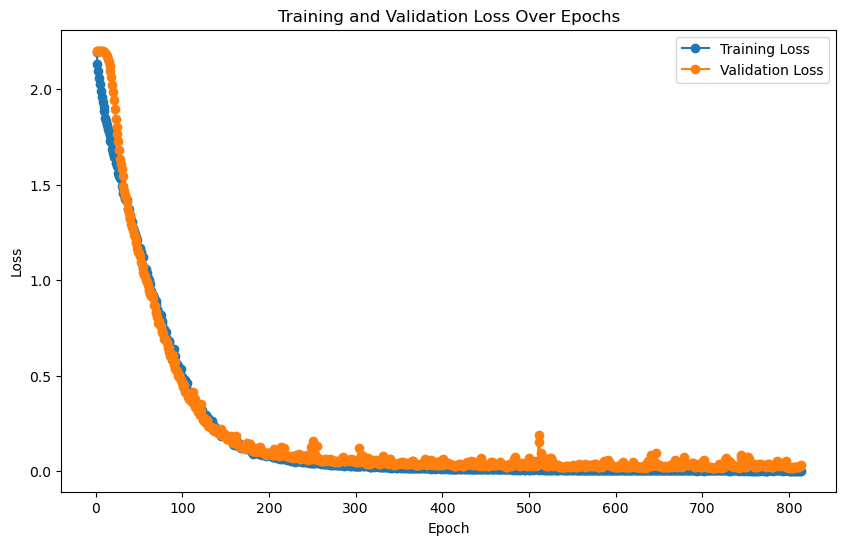

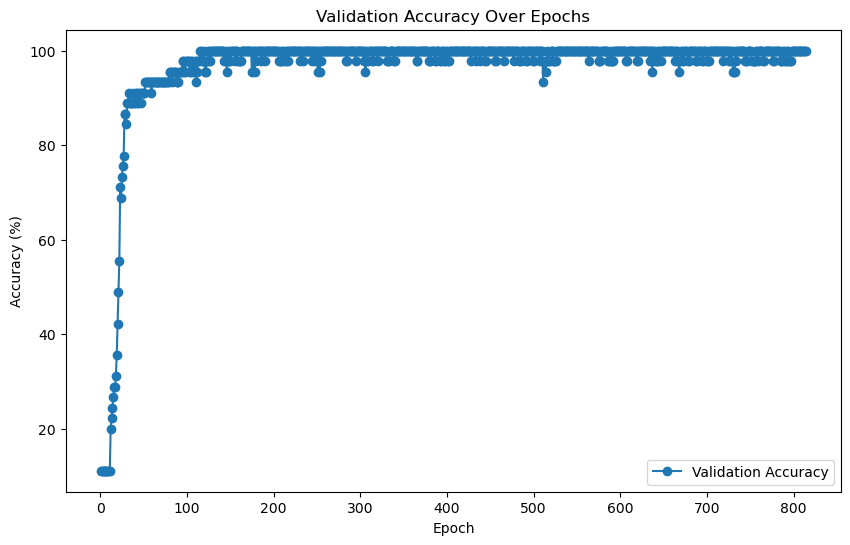


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.0854



Final Test Loss: 0.0467, Test Accuracy: 98.80%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.


  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.


  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.


  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.


  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.


  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.


  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.


  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147747, 64), Test labels shape: (147747,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00    


Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.98      0.80      0.88      7553
           2       0.66      0.96      0.78      3045
           3       0.67      0.90      0.77      2640
           4       0.86      0.88      0.87      6539
           5       0.85      0.95      0.90      9203
           6       0.88      0.84      0.86      7242
           7       1.00      0.97      0.98     42781
           8       1.00      1.00      1.00      2818

    accuracy                           0.96    147747
   macro avg       0.88      0.92      0.89    147747
weighted avg       0.96      0.96      0.96    147747

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147747, 64)
Test labels shape: (147747,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2070  |  Val Loss: 2.0359
Validation loss improved from inf to 2.0359.
[Epoch 2/1000] Train Loss: 1.9692  |  Val Loss: 1.8873
Validation loss improved from 2.0359 to 1.8873.
[Epoch 3/1000] Train Loss: 1.8172  |  Val Loss: 1.7294
Validation loss improved from 1.8873 to 1.7294.
[Epoch 4/1000] Train Loss: 1.6553  |  Val Loss: 1.5442
Validation loss improved from 1.7294 to 1.5442.
[Epoch 5/1000] Train Loss: 1.4623  |  Val Loss: 1.3718
Validation loss improved from 1.5442 to 1.3718.
[Epoch 6/1000] Train Loss: 1.2991  |  Val Loss: 1.2186
Validation loss improved from 1.3718 to 1.2186.
[Epoch 7/1000] Train Loss: 1.1402  |  Val Loss: 1.0680
Validation loss improved from 1.2186 to 1.0680.
[Epoch 8/1000] Train Loss: 1.0020  |  Val Loss: 0.9233
Validation loss improved from 1.0680 to 0.9233.
[Epoch 9/1000] Train Loss: 0.8769  |  Val Loss: 0.7971
Validation loss improved from 0.9233 to 0.7971.
[Epoch 10/1000] Train Loss: 0.7664  |  Val Loss: 0.7002
Validation loss impr

[Epoch 13/1000] Train Loss: 0.5237  |  Val Loss: 0.4841
Validation loss improved from 0.5527 to 0.4841.
[Epoch 14/1000] Train Loss: 0.4675  |  Val Loss: 0.4373
Validation loss improved from 0.4841 to 0.4373.
[Epoch 15/1000] Train Loss: 0.4228  |  Val Loss: 0.3907
Validation loss improved from 0.4373 to 0.3907.
[Epoch 16/1000] Train Loss: 0.3800  |  Val Loss: 0.3736
Validation loss improved from 0.3907 to 0.3736.
[Epoch 17/1000] Train Loss: 0.3517  |  Val Loss: 0.3367
Validation loss improved from 0.3736 to 0.3367.


[Epoch 18/1000] Train Loss: 0.3447  |  Val Loss: 0.3277
Validation loss improved from 0.3367 to 0.3277.
[Epoch 19/1000] Train Loss: 0.3033  |  Val Loss: 0.3043
Validation loss improved from 0.3277 to 0.3043.
[Epoch 20/1000] Train Loss: 0.2888  |  Val Loss: 0.2970
Validation loss improved from 0.3043 to 0.2970.
[Epoch 21/1000] Train Loss: 0.2802  |  Val Loss: 0.2807
Validation loss improved from 0.2970 to 0.2807.
[Epoch 22/1000] Train Loss: 0.2599  |  Val Loss: 0.2558
Validation loss improved from 0.2807 to 0.2558.
[Epoch 23/1000] Train Loss: 0.2392  |  Val Loss: 0.2531
Validation loss improved from 0.2558 to 0.2531.
[Epoch 24/1000] Train Loss: 0.2260  |  Val Loss: 0.2395
Validation loss improved from 0.2531 to 0.2395.
[Epoch 25/1000] Train Loss: 0.2107  |  Val Loss: 0.2240
Validation loss improved from 0.2395 to 0.2240.
[Epoch 26/1000] Train Loss: 0.2014  |  Val Loss: 0.2097
Validation loss improved from 0.2240 to 0.2097.
[Epoch 27/1000] Train Loss: 0.1972  |  Val Loss: 0.2090
Validati

[Epoch 32/1000] Train Loss: 0.1776  |  Val Loss: 0.1888
Validation loss improved from 0.1916 to 0.1888.
[Epoch 33/1000] Train Loss: 0.1676  |  Val Loss: 0.1819
Validation loss improved from 0.1888 to 0.1819.
[Epoch 34/1000] Train Loss: 0.1644  |  Val Loss: 0.1691
Validation loss improved from 0.1819 to 0.1691.
[Epoch 35/1000] Train Loss: 0.1510  |  Val Loss: 0.1743
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 36/1000] Train Loss: 0.1457  |  Val Loss: 0.1720
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 37/1000] Train Loss: 0.1428  |  Val Loss: 0.1617
Validation loss improved from 0.1691 to 0.1617.
[Epoch 38/1000] Train Loss: 0.1337  |  Val Loss: 0.1696
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.1363  |  Val Loss: 0.1673
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 40/1000] Train Loss: 0.1294  |  Val Loss: 0.1605
Validation loss improved from 0.1617 to 0.1605.
[Epoch 41/1000] Train Loss: 0.1261  |  Val Loss: 0.1625
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.1213  |  Val Loss: 0.1678
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 43/1000] Train Loss: 0.1187  |  Val Loss: 0.1651
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 44/1000] Train Loss: 0.1164  |  Val Loss: 0.1673
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 45/1000] Train 

[Epoch 50/1000] Train Loss: 0.0967  |  Val Loss: 0.1546
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 51/1000] Train Loss: 0.1034  |  Val Loss: 0.1652
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 52/1000] Train Loss: 0.0973  |  Val Loss: 0.1645
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 53/1000] Train Loss: 0.0971  |  Val Loss: 0.1662
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 54/1000] Train Loss: 0.0891  |  Val Loss: 0.1496
Validation loss improved from 0.1545 to 0.1496.
[Epoch 55/1000] Train Loss: 0.0887  |  Val Loss: 0.1653
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 0.0982  |  Val Loss: 0.1663
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 57/1000] Train Loss: 0.0926  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 58/1000] Train Loss: 0.1073  |  Val Loss: 0.1633
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 59/1000] Train Loss: 0.1177  |  Val Loss: 0.2007
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 60/1000] Train Loss: 0.1324  |  Val Loss: 0.1771
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 61/1000] Train Loss: 0.1037  |  Val Loss: 0.1812
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 62/1000] 

[Epoch 68/1000] Train Loss: 0.0626  |  Val Loss: 0.1677
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 69/1000] Train Loss: 0.0598  |  Val Loss: 0.1671
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 70/1000] Train Loss: 0.0624  |  Val Loss: 0.1669
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 71/1000] Train Loss: 0.0625  |  Val Loss: 0.1660
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 72/1000] Train Loss: 0.0569  |  Val Loss: 0.1564
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 73/1000] Train Loss: 0.0554  |  Val Loss: 0.1728
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 74/1000] Train Loss: 0.0618  |  Val Loss: 0.1886
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 75/1000] Train Loss: 0.0551  |  Val Loss: 0.1698
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 76/1000] Train Loss: 0.0568  |  Val Loss: 0.1681
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 77/1000] Train Loss: 0.0556  |  Val Loss: 0.1765
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 78/1000] Train Loss: 0.0591  |  Val Loss: 0.1820
!! Validation loss did NOT improve !! Patience: 16/100
[Ep

[Epoch 86/1000] Train Loss: 0.0465  |  Val Loss: 0.1720
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 87/1000] Train Loss: 0.0419  |  Val Loss: 0.1888
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 88/1000] Train Loss: 0.0422  |  Val Loss: 0.1867
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 89/1000] Train Loss: 0.0378  |  Val Loss: 0.1809
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 90/1000] Train Loss: 0.0401  |  Val Loss: 0.1920
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 91/1000] Train Loss: 0.0375  |  Val Loss: 0.1883
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 92/1000] Train Loss: 0.0362  |  Val Loss: 0.1887
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 93/1000] Train Loss: 0.0343  |  Val Loss: 0.1814
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 94/1000] Train Loss: 0.0346  |  Val Loss: 0.1835
!! Validation loss did NOT improve !! Patience: 32/100
[

[Epoch 103/1000] Train Loss: 0.0267  |  Val Loss: 0.1886
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 104/1000] Train Loss: 0.0262  |  Val Loss: 0.1868
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 105/1000] Train Loss: 0.0256  |  Val Loss: 0.1927
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 106/1000] Train Loss: 0.0261  |  Val Loss: 0.1892
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 107/1000] Train Loss: 0.0260  |  Val Loss: 0.1949
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 108/1000] Train Loss: 0.0245  |  Val Loss: 0.1900
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 109/1000] Train Loss: 0.0235  |  Val Loss: 0.1884
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 110/1000] Train Loss: 0.0248  |  Val Loss: 0.1967
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 111/1000] Train Loss: 0.0229  |  Val Loss: 0.2032
!! Validation loss did NOT improve !! Patience:

[Epoch 119/1000] Train Loss: 0.0204  |  Val Loss: 0.1938
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 120/1000] Train Loss: 0.0185  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 121/1000] Train Loss: 0.0191  |  Val Loss: 0.2043
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 122/1000] Train Loss: 0.0190  |  Val Loss: 0.1923
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 123/1000] Train Loss: 0.0190  |  Val Loss: 0.2025
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 124/1000] Train Loss: 0.0190  |  Val Loss: 0.2066
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 125/1000] Train Loss: 0.0183  |  Val Loss: 0.2014
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 126/1000] Train Loss: 0.0178  |  Val Loss: 0.2063
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 127/1000] Train Loss: 0.0180  |  Val Loss: 0.2060
!! Validation loss did NOT improve !! Patience:

[Epoch 137/1000] Train Loss: 0.0136  |  Val Loss: 0.2094
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 138/1000] Train Loss: 0.0152  |  Val Loss: 0.2167
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 139/1000] Train Loss: 0.0139  |  Val Loss: 0.2041
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 140/1000] Train Loss: 0.0131  |  Val Loss: 0.2070
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 141/1000] Train Loss: 0.0126  |  Val Loss: 0.2075
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 142/1000] Train Loss: 0.0124  |  Val Loss: 0.2167
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 143/1000] Train Loss: 0.0121  |  Val Loss: 0.2173
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 144/1000] Train Loss: 0.0118  |  Val Loss: 0.2132
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 145/1000] Train Loss: 0.0121  |  Val Loss: 0.2121
!! Validation loss did NOT improve !! Patience:

[Epoch 154/1000] Train Loss: 0.0104  |  Val Loss: 0.2147
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 155/1000] Train Loss: 0.0110  |  Val Loss: 0.2201
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 156/1000] Train Loss: 0.0098  |  Val Loss: 0.2260
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 157/1000] Train Loss: 0.0098  |  Val Loss: 0.2175
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 158/1000] Train Loss: 0.0105  |  Val Loss: 0.2201
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 159/1000] Train Loss: 0.0098  |  Val Loss: 0.2224
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 160/1000] Train Loss: 0.0094  |  Val Loss: 0.2179
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 161/1000] Train Loss: 0.0096  |  Val Loss: 0.2243
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 162/1000] Train Loss: 0.0098  |  Val Loss: 0.2199
!! Validation loss did NOT improve !! Patience:

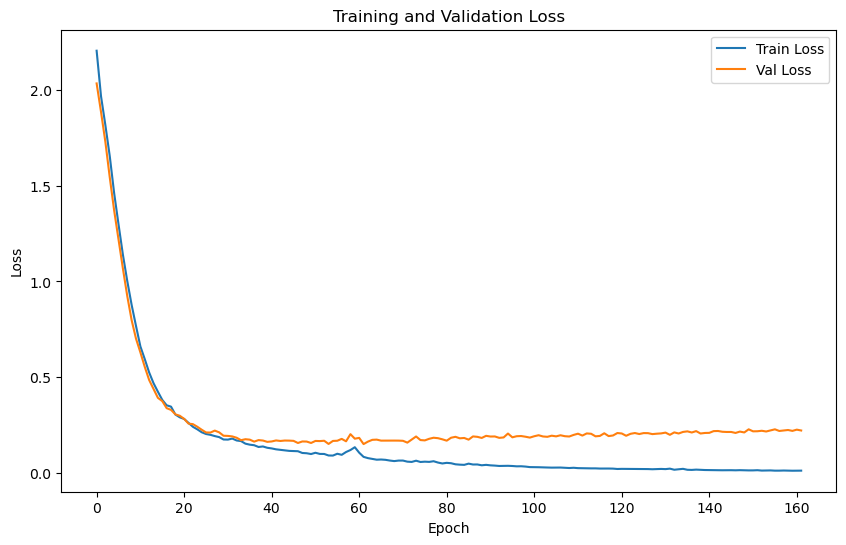

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.1908 | Test Accuracy: 94.71%


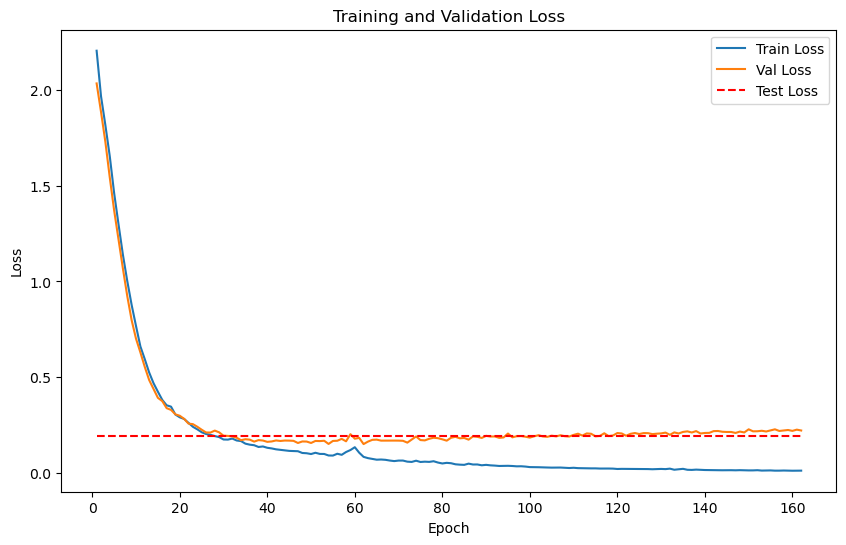

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 9.2042
    Batch [2/2], Train Loss: 8.9796
Epoch [1/2000], Avg Train Loss: 9.0919
Epoch [1/2000], Avg Val Loss: 4.1602
Validation loss improved from inf to 4.1602. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.6010
    Batch [2/2], Train Loss: 8.8414
Epoch [2/2000], Avg Train Loss: 8.7212
Epoch [2/2000], Avg Val Loss: 4.0636
Validation loss improved from 4.1602 to 4.0636. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.7086
    Batch [2/2], Train Loss: 8.5536
Epoch [3/2000], Avg Train Loss: 8.6311
Epoch [3/2000], Avg Val Loss: 3.9719
Validation loss improved from 4.0636 to 3.9719. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.4323
    Batch [2/2], Train Loss: 8.6092
Epoch [4/2000], Avg Train Loss: 8.5207
Epoch [4/2000], Avg Val Loss: 3.8850
Validation loss improved from 3.9719 to 3.8850. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss

Epoch [25/2000], Avg Val Loss: 2.8819
Validation loss improved from 2.9024 to 2.8819. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 6.0033
    Batch [2/2], Train Loss: 5.8297
Epoch [26/2000], Avg Train Loss: 5.9165
Epoch [26/2000], Avg Val Loss: 2.8630
Validation loss improved from 2.8819 to 2.8630. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 5.9902
    Batch [2/2], Train Loss: 5.9084
Epoch [27/2000], Avg Train Loss: 5.9493
Epoch [27/2000], Avg Val Loss: 2.8455
Validation loss improved from 2.8630 to 2.8455. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 5.7560
    Batch [2/2], Train Loss: 5.7896
Epoch [28/2000], Avg Train Loss: 5.7728
Epoch [28/2000], Avg Val Loss: 2.8294
Validation loss improved from 2.8455 to 2.8294. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.5631
    Batch [2/2], Train Loss: 5.8035
Epoch [29/2000], Avg Train Loss: 5.6833
Epoch [29/20

    Batch [2/2], Train Loss: 4.8220
Epoch [49/2000], Avg Train Loss: 4.8573
Epoch [49/2000], Avg Val Loss: 2.6755
Validation loss improved from 2.6790 to 2.6755. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 4.8695
    Batch [2/2], Train Loss: 4.9092
Epoch [50/2000], Avg Train Loss: 4.8894
Epoch [50/2000], Avg Val Loss: 2.6723
Validation loss improved from 2.6755 to 2.6723. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 4.8388
    Batch [2/2], Train Loss: 4.8850
Epoch [51/2000], Avg Train Loss: 4.8619
Epoch [51/2000], Avg Val Loss: 2.6693
Validation loss improved from 2.6723 to 2.6693. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 4.8326
    Batch [2/2], Train Loss: 4.8044
Epoch [52/2000], Avg Train Loss: 4.8185
Epoch [52/2000], Avg Val Loss: 2.6664
Validation loss improved from 2.6693 to 2.6664. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 4.8025
    Batch [2

    Batch [2/2], Train Loss: 4.5063
Epoch [73/2000], Avg Train Loss: 4.5229
Epoch [73/2000], Avg Val Loss: 2.6208
Validation loss improved from 2.6228 to 2.6208. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 4.5018
    Batch [2/2], Train Loss: 4.5712
Epoch [74/2000], Avg Train Loss: 4.5365
Epoch [74/2000], Avg Val Loss: 2.6188
Validation loss improved from 2.6208 to 2.6188. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 4.5027
    Batch [2/2], Train Loss: 4.4995
Epoch [75/2000], Avg Train Loss: 4.5011
Epoch [75/2000], Avg Val Loss: 2.6169
Validation loss improved from 2.6188 to 2.6169. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 4.5342
    Batch [2/2], Train Loss: 4.5079
Epoch [76/2000], Avg Train Loss: 4.5211
Epoch [76/2000], Avg Val Loss: 2.6149
Validation loss improved from 2.6169 to 2.6149. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.4649
    Batch [2

Epoch [97/2000], Avg Val Loss: 2.5764
Validation loss improved from 2.5782 to 2.5764. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 4.3555
    Batch [2/2], Train Loss: 4.2984
Epoch [98/2000], Avg Train Loss: 4.3270
Epoch [98/2000], Avg Val Loss: 2.5747
Validation loss improved from 2.5764 to 2.5747. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 4.3057
    Batch [2/2], Train Loss: 4.3100
Epoch [99/2000], Avg Train Loss: 4.3078
Epoch [99/2000], Avg Val Loss: 2.5728
Validation loss improved from 2.5747 to 2.5728. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 4.3351
    Batch [2/2], Train Loss: 4.3447
Epoch [100/2000], Avg Train Loss: 4.3399
Epoch [100/2000], Avg Val Loss: 2.5711
Validation loss improved from 2.5728 to 2.5711. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 4.3522
    Batch [2/2], Train Loss: 4.2686
Epoch [101/2000], Avg Train Loss: 4.3104
Epoch [

    Batch [2/2], Train Loss: 4.2370
Epoch [121/2000], Avg Train Loss: 4.2488
Epoch [121/2000], Avg Val Loss: 2.5364
Validation loss improved from 2.5378 to 2.5364. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 4.1746
    Batch [2/2], Train Loss: 4.1232
Epoch [122/2000], Avg Train Loss: 4.1489
Epoch [122/2000], Avg Val Loss: 2.5350
Validation loss improved from 2.5364 to 2.5350. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 4.2289
    Batch [2/2], Train Loss: 4.2369
Epoch [123/2000], Avg Train Loss: 4.2329
Epoch [123/2000], Avg Val Loss: 2.5336
Validation loss improved from 2.5350 to 2.5336. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 4.2555
    Batch [2/2], Train Loss: 4.2404
Epoch [124/2000], Avg Train Loss: 4.2480
Epoch [124/2000], Avg Val Loss: 2.5323
Validation loss improved from 2.5336 to 2.5323. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 4.1814


    Batch [2/2], Train Loss: 4.1290
Epoch [144/2000], Avg Train Loss: 4.1268
Epoch [144/2000], Avg Val Loss: 2.5055
Validation loss improved from 2.5067 to 2.5055. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 4.1394
    Batch [2/2], Train Loss: 4.1511
Epoch [145/2000], Avg Train Loss: 4.1452
Epoch [145/2000], Avg Val Loss: 2.5044
Validation loss improved from 2.5055 to 2.5044. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 4.1610
    Batch [2/2], Train Loss: 4.0329
Epoch [146/2000], Avg Train Loss: 4.0970
Epoch [146/2000], Avg Val Loss: 2.5034
Validation loss improved from 2.5044 to 2.5034. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 4.0937
    Batch [2/2], Train Loss: 4.1179
Epoch [147/2000], Avg Train Loss: 4.1058
Epoch [147/2000], Avg Val Loss: 2.5024
Validation loss improved from 2.5034 to 2.5024. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 4.0637


    Batch [1/2], Train Loss: 4.0538
    Batch [2/2], Train Loss: 4.1007
Epoch [169/2000], Avg Train Loss: 4.0773
Epoch [169/2000], Avg Val Loss: 2.4832
Validation loss improved from 2.4839 to 2.4832. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 4.0415
    Batch [2/2], Train Loss: 4.0279
Epoch [170/2000], Avg Train Loss: 4.0347
Epoch [170/2000], Avg Val Loss: 2.4825
Validation loss improved from 2.4832 to 2.4825. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 4.0332
    Batch [2/2], Train Loss: 4.1024
Epoch [171/2000], Avg Train Loss: 4.0678
Epoch [171/2000], Avg Val Loss: 2.4818
Validation loss improved from 2.4825 to 2.4818. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 4.0834
    Batch [2/2], Train Loss: 4.0563
Epoch [172/2000], Avg Train Loss: 4.0699
Epoch [172/2000], Avg Val Loss: 2.4810
Validation loss improved from 2.4818 to 2.4810. Saving model...

LOG: Epoch [173/2000] - Training


    Batch [2/2], Train Loss: 3.9828
Epoch [193/2000], Avg Train Loss: 4.0001
Epoch [193/2000], Avg Val Loss: 2.4653
Validation loss improved from 2.4658 to 2.4653. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 3.9443
    Batch [2/2], Train Loss: 3.9486
Epoch [194/2000], Avg Train Loss: 3.9464
Epoch [194/2000], Avg Val Loss: 2.4647
Validation loss improved from 2.4653 to 2.4647. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 3.9355
    Batch [2/2], Train Loss: 3.9778
Epoch [195/2000], Avg Train Loss: 3.9567
Epoch [195/2000], Avg Val Loss: 2.4641
Validation loss improved from 2.4647 to 2.4641. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 4.0303
    Batch [2/2], Train Loss: 4.0178
Epoch [196/2000], Avg Train Loss: 4.0240
Epoch [196/2000], Avg Val Loss: 2.4634
Validation loss improved from 2.4641 to 2.4634. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 4.0223


    Batch [1/2], Train Loss: 3.9279
    Batch [2/2], Train Loss: 3.9169
Epoch [217/2000], Avg Train Loss: 3.9224
Epoch [217/2000], Avg Val Loss: 2.4537
Validation loss improved from 2.4541 to 2.4537. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 3.9615
    Batch [2/2], Train Loss: 3.8959
Epoch [218/2000], Avg Train Loss: 3.9287
Epoch [218/2000], Avg Val Loss: 2.4532
Validation loss improved from 2.4537 to 2.4532. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 3.9586
    Batch [2/2], Train Loss: 3.8809
Epoch [219/2000], Avg Train Loss: 3.9198
Epoch [219/2000], Avg Val Loss: 2.4528
Validation loss improved from 2.4532 to 2.4528. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 3.9288
    Batch [2/2], Train Loss: 3.9383
Epoch [220/2000], Avg Train Loss: 3.9336
Epoch [220/2000], Avg Val Loss: 2.4524
Validation loss improved from 2.4528 to 2.4524. Saving model...

LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 3.8582
    Batch [2/2], Train Loss: 3.9419
Epoch [241/2000], Avg Train Loss: 3.9000
Epoch [241/2000], Avg Val Loss: 2.4462
Validation loss improved from 2.4466 to 2.4462. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 3.8912
    Batch [2/2], Train Loss: 3.9057
Epoch [242/2000], Avg Train Loss: 3.8985
Epoch [242/2000], Avg Val Loss: 2.4458
Validation loss improved from 2.4462 to 2.4458. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 3.8531
    Batch [2/2], Train Loss: 3.8942
Epoch [243/2000], Avg Train Loss: 3.8737
Epoch [243/2000], Avg Val Loss: 2.4456
Validation loss improved from 2.4458 to 2.4456. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 3.9660
    Batch [2/2], Train Loss: 3.8798
Epoch [244/2000], Avg Train Loss: 3.9229
Epoch [244/2000], Avg Val Loss: 2.4453
Validation loss improved from 2.4456 to 2.4453. Saving model...

LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 3.8656
    Batch [2/2], Train Loss: 3.8686
Epoch [265/2000], Avg Train Loss: 3.8671
Epoch [265/2000], Avg Val Loss: 2.4400
Validation loss improved from 2.4402 to 2.4400. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 3.9363
    Batch [2/2], Train Loss: 3.8182
Epoch [266/2000], Avg Train Loss: 3.8773
Epoch [266/2000], Avg Val Loss: 2.4397
Validation loss improved from 2.4400 to 2.4397. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 3.8486
    Batch [2/2], Train Loss: 3.8008
Epoch [267/2000], Avg Train Loss: 3.8247
Epoch [267/2000], Avg Val Loss: 2.4395
Validation loss improved from 2.4397 to 2.4395. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 3.8526
    Batch [2/2], Train Loss: 3.8134
Epoch [268/2000], Avg Train Loss: 3.8330
Epoch [268/2000], Avg Val Loss: 2.4392
Validation loss improved from 2.4395 to 2.4392. Saving model...

LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 3.8179
    Batch [2/2], Train Loss: 3.8016
Epoch [289/2000], Avg Train Loss: 3.8097
Epoch [289/2000], Avg Val Loss: 2.4379
Validation loss did not improve. Patience: 7/100

LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 3.8434
    Batch [2/2], Train Loss: 3.8519
Epoch [290/2000], Avg Train Loss: 3.8477
Epoch [290/2000], Avg Val Loss: 2.4378
Validation loss did not improve. Patience: 8/100

LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 3.8302
    Batch [2/2], Train Loss: 3.8701
Epoch [291/2000], Avg Train Loss: 3.8501
Epoch [291/2000], Avg Val Loss: 2.4378
Validation loss did not improve. Patience: 9/100

LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 3.8393
    Batch [2/2], Train Loss: 3.8605
Epoch [292/2000], Avg Train Loss: 3.8499
Epoch [292/2000], Avg Val Loss: 2.4379
Validation loss did not improve. Patience: 10/100

LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 3.8031
    Batch [2/2], Train 

Epoch [310/2000], Avg Val Loss: 2.4380
Validation loss did not improve. Patience: 6/100

LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 3.8017
    Batch [2/2], Train Loss: 3.8092
Epoch [311/2000], Avg Train Loss: 3.8054
Epoch [311/2000], Avg Val Loss: 2.4379
Validation loss did not improve. Patience: 7/100

LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 3.7999
    Batch [2/2], Train Loss: 3.7858
Epoch [312/2000], Avg Train Loss: 3.7929
Epoch [312/2000], Avg Val Loss: 2.4378
Validation loss did not improve. Patience: 8/100

LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 3.7904
    Batch [2/2], Train Loss: 3.8404
Epoch [313/2000], Avg Train Loss: 3.8154
Epoch [313/2000], Avg Val Loss: 2.4376
Validation loss did not improve. Patience: 9/100

LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 3.7424
    Batch [2/2], Train Loss: 3.7988
Epoch [314/2000], Avg Train Loss: 3.7706
Epoch [314/2000], Avg Val Loss: 2.4374
Validation loss did n

    Batch [1/2], Train Loss: 3.7603
    Batch [2/2], Train Loss: 3.8163
Epoch [322/2000], Avg Train Loss: 3.7883
Epoch [322/2000], Avg Val Loss: 2.4348
Validation loss improved from 2.4350 to 2.4348. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 3.7750
    Batch [2/2], Train Loss: 3.7628
Epoch [323/2000], Avg Train Loss: 3.7689
Epoch [323/2000], Avg Val Loss: 2.4347
Validation loss improved from 2.4348 to 2.4347. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 3.7820
    Batch [2/2], Train Loss: 3.7900
Epoch [324/2000], Avg Train Loss: 3.7860
Epoch [324/2000], Avg Val Loss: 2.4348
Validation loss did not improve. Patience: 1/100

LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 3.7389
    Batch [2/2], Train Loss: 3.7719
Epoch [325/2000], Avg Train Loss: 3.7554
Epoch [325/2000], Avg Val Loss: 2.4349
Validation loss did not improve. Patience: 2/100

LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 3

    Batch [1/2], Train Loss: 3.7785
    Batch [2/2], Train Loss: 3.7860
Epoch [341/2000], Avg Train Loss: 3.7822
Epoch [341/2000], Avg Val Loss: 2.4352
Validation loss did not improve. Patience: 18/100

LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 3.7665
    Batch [2/2], Train Loss: 3.7949
Epoch [342/2000], Avg Train Loss: 3.7807
Epoch [342/2000], Avg Val Loss: 2.4352
Validation loss did not improve. Patience: 19/100

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 3.7729
    Batch [2/2], Train Loss: 3.7153
Epoch [343/2000], Avg Train Loss: 3.7441
Epoch [343/2000], Avg Val Loss: 2.4351
Validation loss did not improve. Patience: 20/100

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 3.7541
    Batch [2/2], Train Loss: 3.7220
Epoch [344/2000], Avg Train Loss: 3.7381
Epoch [344/2000], Avg Val Loss: 2.4349
Validation loss did not improve. Patience: 21/100

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 3.8025
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.7350
    Batch [2/2], Train Loss: 3.7406
Epoch [364/2000], Avg Train Loss: 3.7378
Epoch [364/2000], Avg Val Loss: 2.4338
Validation loss did not improve. Patience: 3/100

LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 3.6935
    Batch [2/2], Train Loss: 3.7756
Epoch [365/2000], Avg Train Loss: 3.7346
Epoch [365/2000], Avg Val Loss: 2.4339
Validation loss did not improve. Patience: 4/100

LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 3.7043
    Batch [2/2], Train Loss: 3.6867
Epoch [366/2000], Avg Train Loss: 3.6955
Epoch [366/2000], Avg Val Loss: 2.4340
Validation loss did not improve. Patience: 5/100

LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 3.7501
    Batch [2/2], Train Loss: 3.7310
Epoch [367/2000], Avg Train Loss: 3.7405
Epoch [367/2000], Avg Val Loss: 2.4340
Validation loss did not improve. Patience: 6/100

LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 3.7052
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 3.7020
Epoch [384/2000], Avg Train Loss: 3.7231
Epoch [384/2000], Avg Val Loss: 2.4350
Validation loss did not improve. Patience: 9/100

LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 3.7591
    Batch [2/2], Train Loss: 3.7338
Epoch [385/2000], Avg Train Loss: 3.7464
Epoch [385/2000], Avg Val Loss: 2.4354
Validation loss did not improve. Patience: 10/100

LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 3.7238
    Batch [2/2], Train Loss: 3.6845
Epoch [386/2000], Avg Train Loss: 3.7041
Epoch [386/2000], Avg Val Loss: 2.4359
Validation loss did not improve. Patience: 11/100

LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 3.7157
    Batch [2/2], Train Loss: 3.7586
Epoch [387/2000], Avg Train Loss: 3.7371
Epoch [387/2000], Avg Val Loss: 2.4361
Validation loss did not improve. Patience: 12/100

LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 3.7228
    Batch [2/2], Train Loss: 3.7303
Epoch [388/2000], Avg

    Batch [2/2], Train Loss: 3.6859
Epoch [404/2000], Avg Train Loss: 3.7097
Epoch [404/2000], Avg Val Loss: 2.4396
Validation loss did not improve. Patience: 29/100

LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 3.6900
    Batch [2/2], Train Loss: 3.6718
Epoch [405/2000], Avg Train Loss: 3.6809
Epoch [405/2000], Avg Val Loss: 2.4394
Validation loss did not improve. Patience: 30/100

LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 3.6822
    Batch [2/2], Train Loss: 3.7059
Epoch [406/2000], Avg Train Loss: 3.6940
Epoch [406/2000], Avg Val Loss: 2.4392
Validation loss did not improve. Patience: 31/100

LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 3.6428
    Batch [2/2], Train Loss: 3.6633
Epoch [407/2000], Avg Train Loss: 3.6531
Epoch [407/2000], Avg Val Loss: 2.4389
Validation loss did not improve. Patience: 32/100

LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 3.6991
    Batch [2/2], Train Loss: 3.7167
Epoch [408/2000], Av

    Batch [1/2], Train Loss: 3.6880
    Batch [2/2], Train Loss: 3.6707
Epoch [424/2000], Avg Train Loss: 3.6793
Epoch [424/2000], Avg Val Loss: 2.4388
Validation loss did not improve. Patience: 49/100

LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 3.7037
    Batch [2/2], Train Loss: 3.6663
Epoch [425/2000], Avg Train Loss: 3.6850
Epoch [425/2000], Avg Val Loss: 2.4392
Validation loss did not improve. Patience: 50/100

LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 3.7022
    Batch [2/2], Train Loss: 3.6942
Epoch [426/2000], Avg Train Loss: 3.6982
Epoch [426/2000], Avg Val Loss: 2.4395
Validation loss did not improve. Patience: 51/100

LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 3.6618
    Batch [2/2], Train Loss: 3.6947
Epoch [427/2000], Avg Train Loss: 3.6782
Epoch [427/2000], Avg Val Loss: 2.4400
Validation loss did not improve. Patience: 52/100

LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 3.6855
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 3.6645
    Batch [2/2], Train Loss: 3.7143
Epoch [446/2000], Avg Train Loss: 3.6894
Epoch [446/2000], Avg Val Loss: 2.4415
Validation loss did not improve. Patience: 71/100

LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 3.6514
    Batch [2/2], Train Loss: 3.6366
Epoch [447/2000], Avg Train Loss: 3.6440
Epoch [447/2000], Avg Val Loss: 2.4416
Validation loss did not improve. Patience: 72/100

LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 3.6863
    Batch [2/2], Train Loss: 3.6449
Epoch [448/2000], Avg Train Loss: 3.6656
Epoch [448/2000], Avg Val Loss: 2.4417
Validation loss did not improve. Patience: 73/100

LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 3.6239
    Batch [2/2], Train Loss: 3.6584
Epoch [449/2000], Avg Train Loss: 3.6411
Epoch [449/2000], Avg Val Loss: 2.4417
Validation loss did not improve. Patience: 74/100

LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 3.6746
    Batch [2/2], Tra

Epoch [470/2000], Avg Val Loss: 2.4394
Validation loss did not improve. Patience: 95/100

LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 3.6428
    Batch [2/2], Train Loss: 3.6770
Epoch [471/2000], Avg Train Loss: 3.6599
Epoch [471/2000], Avg Val Loss: 2.4395
Validation loss did not improve. Patience: 96/100

LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 3.6390
    Batch [2/2], Train Loss: 3.6355
Epoch [472/2000], Avg Train Loss: 3.6372
Epoch [472/2000], Avg Val Loss: 2.4396
Validation loss did not improve. Patience: 97/100

LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 3.6425
    Batch [2/2], Train Loss: 3.6638
Epoch [473/2000], Avg Train Loss: 3.6531
Epoch [473/2000], Avg Val Loss: 2.4397
Validation loss did not improve. Patience: 98/100

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 3.6482
    Batch [2/2], Train Loss: 3.6691
Epoch [474/2000], Avg Train Loss: 3.6587
Epoch [474/2000], Avg Val Loss: 2.4399
Validation loss d

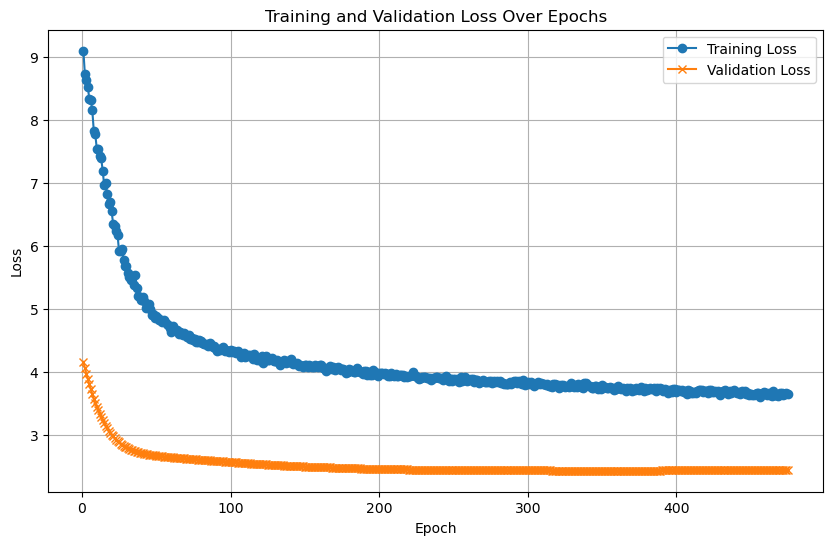

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 4.7386


Test Batch [20/578], Loss: 4.6212
Test Batch [30/578], Loss: 4.6403
Test Batch [40/578], Loss: 4.5998
Test Batch [50/578], Loss: 4.6290
Test Batch [60/578], Loss: 4.6205
Test Batch [70/578], Loss: 4.5189
Test Batch [80/578], Loss: 4.4797
Test Batch [90/578], Loss: 4.6037
Test Batch [100/578], Loss: 4.3725
Test Batch [110/578], Loss: 4.4922
Test Batch [120/578], Loss: 4.5916


Test Batch [130/578], Loss: 4.4928
Test Batch [140/578], Loss: 4.6102
Test Batch [150/578], Loss: 4.6047
Test Batch [160/578], Loss: 4.6297
Test Batch [170/578], Loss: 4.6326
Test Batch [180/578], Loss: 4.3274
Test Batch [190/578], Loss: 4.5773
Test Batch [200/578], Loss: 4.6289
Test Batch [210/578], Loss: 4.6415
Test Batch [220/578], Loss: 4.7741
Test Batch [230/578], Loss: 4.6931
Test Batch [240/578], Loss: 4.5864
Test Batch [250/578], Loss: 4.5870
Test Batch [260/578], Loss: 4.5914


Test Batch [270/578], Loss: 4.5774
Test Batch [280/578], Loss: 4.3325
Test Batch [290/578], Loss: 4.7636
Test Batch [300/578], Loss: 4.7946
Test Batch [310/578], Loss: 4.9988
Test Batch [320/578], Loss: 5.2105
Test Batch [330/578], Loss: 5.3442
Test Batch [340/578], Loss: 5.3933
Test Batch [350/578], Loss: 5.4816
Test Batch [360/578], Loss: 5.5893
Test Batch [370/578], Loss: 5.5859
Test Batch [380/578], Loss: 4.3393
Test Batch [390/578], Loss: 4.8078


Test Batch [400/578], Loss: 4.9606
Test Batch [410/578], Loss: 5.0204
Test Batch [420/578], Loss: 4.8305
Test Batch [430/578], Loss: 5.3550
Test Batch [440/578], Loss: 5.0522
Test Batch [450/578], Loss: 5.2549
Test Batch [460/578], Loss: 5.6724
Test Batch [470/578], Loss: 5.3825
Test Batch [480/578], Loss: 4.4239
Test Batch [490/578], Loss: 5.1292
Test Batch [500/578], Loss: 5.3313
Test Batch [510/578], Loss: 5.4285


Test Batch [520/578], Loss: 4.7810
Test Batch [530/578], Loss: 4.7672
Test Batch [540/578], Loss: 4.4927
Test Batch [550/578], Loss: 4.4602
Test Batch [560/578], Loss: 4.3609
Test Batch [570/578], Loss: 4.4898

Test Loss: 4.7824


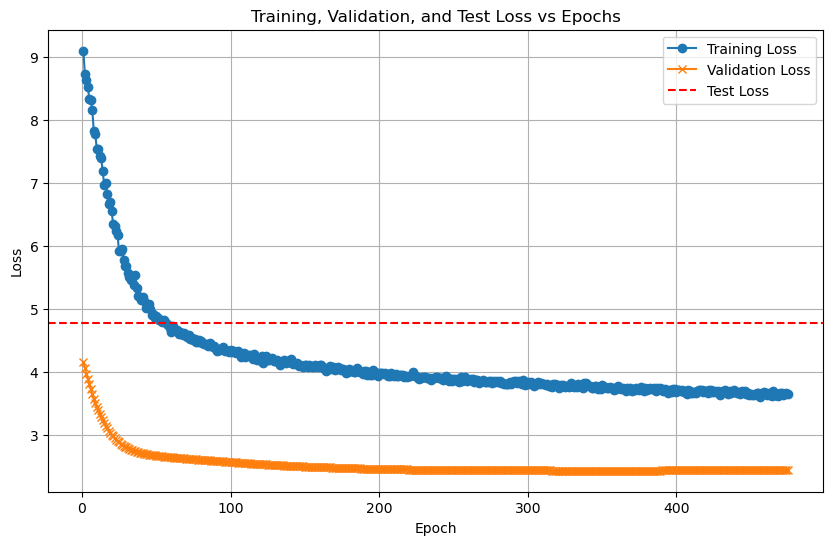

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.


  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.
  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.


  Processed batch 130/578 for test dataset.
  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.
  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.


  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.


  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.


  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.


  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.


  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.


  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       0.83      1.00      0.91         5

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45


LOG: Evaluating on the test set...
Test Accuracy: 95.01%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     65926
           1       0.99      0.83      0.90      7553
           2       0.70      0.96      0.81      3045
           3       0.67      0.90      0.77      2640
           4       0.82      0.89      0.86      6539
           5       0.83      0.96      0.89      9203
           6       0.78      0.82      0.80      7242
           7       1.00      0.96      0.98     42781
           8       0.99      1.00      0.99      2818

    accuracy                           0.95    147747
   macro avg       0.86      0.92      0.89    147747
weighted avg       0.96      0.95      0.95    147747

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2173  |  Val Loss: 2.1702
Validation loss improved from inf to 2.1702.
[Epoch 2/1000] Train Loss: 2.1471  |  Val Loss: 2.1023
Validation loss improved from 2.1702 to 2.1023.
[Epoch 3/1000] Train Loss: 2.0833  |  Val Loss: 2.0399
Validation loss improved from 2.1023 to 2.0399.
[Epoch 4/1000] Train Loss: 2.0255  |  Val Loss: 1.9827
Validation loss improved from 2.0399 to 1.9827.
[Epoch 5/1000] Train Loss: 1.9718  |  Val Loss: 1.9316
Validation loss improved from 1.9827 to 1.9316.
[Epoch 6/1000] Train Loss: 1.9226  |  Val Loss: 1.8845
Validation loss improved from 1.9316 to 1.8845.
[Epoch 7/1000] Train Loss: 1.8762  |  Val Loss: 1.8398
Validation loss improved from 1.8845 to 1.8398.
[Epoch 8/1000] Train Loss: 1.8322  |  Val Loss: 1.7961
Validation loss improved from 1.8398 to 1.7961.
[Epoch 9/1000] Train Loss: 1.7896  |  Val Loss: 1.7530
Validation loss improved from 1.7961 to 1.7530.
[Epoch 10/1000] Train Loss: 1.7473  |  Val Loss: 1.7099
Validation loss impr

[Epoch 12/1000] Train Loss: 1.6637  |  Val Loss: 1.6250
Validation loss improved from 1.6670 to 1.6250.
[Epoch 13/1000] Train Loss: 1.6212  |  Val Loss: 1.5851
Validation loss improved from 1.6250 to 1.5851.
[Epoch 14/1000] Train Loss: 1.5796  |  Val Loss: 1.5466
Validation loss improved from 1.5851 to 1.5466.
[Epoch 15/1000] Train Loss: 1.5403  |  Val Loss: 1.5085
Validation loss improved from 1.5466 to 1.5085.


[Epoch 16/1000] Train Loss: 1.5003  |  Val Loss: 1.4711
Validation loss improved from 1.5085 to 1.4711.
[Epoch 17/1000] Train Loss: 1.4605  |  Val Loss: 1.4321
Validation loss improved from 1.4711 to 1.4321.
[Epoch 18/1000] Train Loss: 1.4202  |  Val Loss: 1.3933
Validation loss improved from 1.4321 to 1.3933.
[Epoch 19/1000] Train Loss: 1.3809  |  Val Loss: 1.3551
Validation loss improved from 1.3933 to 1.3551.
[Epoch 20/1000] Train Loss: 1.3430  |  Val Loss: 1.3181
Validation loss improved from 1.3551 to 1.3181.
[Epoch 21/1000] Train Loss: 1.3058  |  Val Loss: 1.2826
Validation loss improved from 1.3181 to 1.2826.
[Epoch 22/1000] Train Loss: 1.2697  |  Val Loss: 1.2483
Validation loss improved from 1.2826 to 1.2483.
[Epoch 23/1000] Train Loss: 1.2348  |  Val Loss: 1.2151
Validation loss improved from 1.2483 to 1.2151.
[Epoch 24/1000] Train Loss: 1.2005  |  Val Loss: 1.1827
Validation loss improved from 1.2151 to 1.1827.
[Epoch 25/1000] Train Loss: 1.1669  |  Val Loss: 1.1511
Validati

[Epoch 26/1000] Train Loss: 1.1349  |  Val Loss: 1.1196
Validation loss improved from 1.1511 to 1.1196.
[Epoch 27/1000] Train Loss: 1.1029  |  Val Loss: 1.0890
Validation loss improved from 1.1196 to 1.0890.
[Epoch 28/1000] Train Loss: 1.0709  |  Val Loss: 1.0597
Validation loss improved from 1.0890 to 1.0597.
[Epoch 29/1000] Train Loss: 1.0414  |  Val Loss: 1.0312
Validation loss improved from 1.0597 to 1.0312.


[Epoch 30/1000] Train Loss: 1.0124  |  Val Loss: 1.0036
Validation loss improved from 1.0312 to 1.0036.
[Epoch 31/1000] Train Loss: 0.9844  |  Val Loss: 0.9770
Validation loss improved from 1.0036 to 0.9770.
[Epoch 32/1000] Train Loss: 0.9565  |  Val Loss: 0.9505
Validation loss improved from 0.9770 to 0.9505.
[Epoch 33/1000] Train Loss: 0.9291  |  Val Loss: 0.9244
Validation loss improved from 0.9505 to 0.9244.
[Epoch 34/1000] Train Loss: 0.9028  |  Val Loss: 0.8989
Validation loss improved from 0.9244 to 0.8989.
[Epoch 35/1000] Train Loss: 0.8765  |  Val Loss: 0.8743
Validation loss improved from 0.8989 to 0.8743.
[Epoch 36/1000] Train Loss: 0.8508  |  Val Loss: 0.8502
Validation loss improved from 0.8743 to 0.8502.
[Epoch 37/1000] Train Loss: 0.8260  |  Val Loss: 0.8265
Validation loss improved from 0.8502 to 0.8265.
[Epoch 38/1000] Train Loss: 0.8013  |  Val Loss: 0.8039
Validation loss improved from 0.8265 to 0.8039.
[Epoch 39/1000] Train Loss: 0.7783  |  Val Loss: 0.7818
Validati

[Epoch 40/1000] Train Loss: 0.7550  |  Val Loss: 0.7605
Validation loss improved from 0.7818 to 0.7605.
[Epoch 41/1000] Train Loss: 0.7335  |  Val Loss: 0.7399
Validation loss improved from 0.7605 to 0.7399.
[Epoch 42/1000] Train Loss: 0.7119  |  Val Loss: 0.7203
Validation loss improved from 0.7399 to 0.7203.
[Epoch 43/1000] Train Loss: 0.6911  |  Val Loss: 0.7011
Validation loss improved from 0.7203 to 0.7011.
[Epoch 44/1000] Train Loss: 0.6713  |  Val Loss: 0.6826
Validation loss improved from 0.7011 to 0.6826.


[Epoch 45/1000] Train Loss: 0.6522  |  Val Loss: 0.6646
Validation loss improved from 0.6826 to 0.6646.
[Epoch 46/1000] Train Loss: 0.6334  |  Val Loss: 0.6475
Validation loss improved from 0.6646 to 0.6475.
[Epoch 47/1000] Train Loss: 0.6156  |  Val Loss: 0.6315
Validation loss improved from 0.6475 to 0.6315.
[Epoch 48/1000] Train Loss: 0.5983  |  Val Loss: 0.6156
Validation loss improved from 0.6315 to 0.6156.
[Epoch 49/1000] Train Loss: 0.5816  |  Val Loss: 0.6005
Validation loss improved from 0.6156 to 0.6005.
[Epoch 50/1000] Train Loss: 0.5657  |  Val Loss: 0.5862
Validation loss improved from 0.6005 to 0.5862.
[Epoch 51/1000] Train Loss: 0.5504  |  Val Loss: 0.5716
Validation loss improved from 0.5862 to 0.5716.
[Epoch 52/1000] Train Loss: 0.5358  |  Val Loss: 0.5577
Validation loss improved from 0.5716 to 0.5577.
[Epoch 53/1000] Train Loss: 0.5215  |  Val Loss: 0.5446
Validation loss improved from 0.5577 to 0.5446.


[Epoch 54/1000] Train Loss: 0.5081  |  Val Loss: 0.5323
Validation loss improved from 0.5446 to 0.5323.
[Epoch 55/1000] Train Loss: 0.4951  |  Val Loss: 0.5202
Validation loss improved from 0.5323 to 0.5202.
[Epoch 56/1000] Train Loss: 0.4826  |  Val Loss: 0.5091
Validation loss improved from 0.5202 to 0.5091.
[Epoch 57/1000] Train Loss: 0.4704  |  Val Loss: 0.4982
Validation loss improved from 0.5091 to 0.4982.
[Epoch 58/1000] Train Loss: 0.4596  |  Val Loss: 0.4875
Validation loss improved from 0.4982 to 0.4875.


[Epoch 59/1000] Train Loss: 0.4482  |  Val Loss: 0.4777
Validation loss improved from 0.4875 to 0.4777.
[Epoch 60/1000] Train Loss: 0.4376  |  Val Loss: 0.4679
Validation loss improved from 0.4777 to 0.4679.
[Epoch 61/1000] Train Loss: 0.4274  |  Val Loss: 0.4587
Validation loss improved from 0.4679 to 0.4587.
[Epoch 62/1000] Train Loss: 0.4179  |  Val Loss: 0.4498
Validation loss improved from 0.4587 to 0.4498.
[Epoch 63/1000] Train Loss: 0.4083  |  Val Loss: 0.4415
Validation loss improved from 0.4498 to 0.4415.
[Epoch 64/1000] Train Loss: 0.3992  |  Val Loss: 0.4331
Validation loss improved from 0.4415 to 0.4331.
[Epoch 65/1000] Train Loss: 0.3906  |  Val Loss: 0.4253
Validation loss improved from 0.4331 to 0.4253.
[Epoch 66/1000] Train Loss: 0.3832  |  Val Loss: 0.4178
Validation loss improved from 0.4253 to 0.4178.
[Epoch 67/1000] Train Loss: 0.3745  |  Val Loss: 0.4099
Validation loss improved from 0.4178 to 0.4099.
[Epoch 68/1000] Train Loss: 0.3668  |  Val Loss: 0.4028
Validati

[Epoch 69/1000] Train Loss: 0.3593  |  Val Loss: 0.3957
Validation loss improved from 0.4028 to 0.3957.
[Epoch 70/1000] Train Loss: 0.3518  |  Val Loss: 0.3893
Validation loss improved from 0.3957 to 0.3893.
[Epoch 71/1000] Train Loss: 0.3452  |  Val Loss: 0.3830
Validation loss improved from 0.3893 to 0.3830.
[Epoch 72/1000] Train Loss: 0.3388  |  Val Loss: 0.3764
Validation loss improved from 0.3830 to 0.3764.
[Epoch 73/1000] Train Loss: 0.3321  |  Val Loss: 0.3704
Validation loss improved from 0.3764 to 0.3704.
[Epoch 74/1000] Train Loss: 0.3260  |  Val Loss: 0.3646
Validation loss improved from 0.3704 to 0.3646.


[Epoch 75/1000] Train Loss: 0.3202  |  Val Loss: 0.3592
Validation loss improved from 0.3646 to 0.3592.
[Epoch 76/1000] Train Loss: 0.3143  |  Val Loss: 0.3543
Validation loss improved from 0.3592 to 0.3543.
[Epoch 77/1000] Train Loss: 0.3092  |  Val Loss: 0.3494
Validation loss improved from 0.3543 to 0.3494.
[Epoch 78/1000] Train Loss: 0.3038  |  Val Loss: 0.3427
Validation loss improved from 0.3494 to 0.3427.
[Epoch 79/1000] Train Loss: 0.2974  |  Val Loss: 0.3367
Validation loss improved from 0.3427 to 0.3367.
[Epoch 80/1000] Train Loss: 0.2912  |  Val Loss: 0.3308
Validation loss improved from 0.3367 to 0.3308.
[Epoch 81/1000] Train Loss: 0.2864  |  Val Loss: 0.3258
Validation loss improved from 0.3308 to 0.3258.
[Epoch 82/1000] Train Loss: 0.2810  |  Val Loss: 0.3215
Validation loss improved from 0.3258 to 0.3215.
[Epoch 83/1000] Train Loss: 0.2766  |  Val Loss: 0.3168
Validation loss improved from 0.3215 to 0.3168.


[Epoch 84/1000] Train Loss: 0.2720  |  Val Loss: 0.3130
Validation loss improved from 0.3168 to 0.3130.
[Epoch 85/1000] Train Loss: 0.2673  |  Val Loss: 0.3092
Validation loss improved from 0.3130 to 0.3092.
[Epoch 86/1000] Train Loss: 0.2634  |  Val Loss: 0.3059
Validation loss improved from 0.3092 to 0.3059.
[Epoch 87/1000] Train Loss: 0.2600  |  Val Loss: 0.3014
Validation loss improved from 0.3059 to 0.3014.
[Epoch 88/1000] Train Loss: 0.2557  |  Val Loss: 0.2980
Validation loss improved from 0.3014 to 0.2980.


[Epoch 89/1000] Train Loss: 0.2524  |  Val Loss: 0.2952
Validation loss improved from 0.2980 to 0.2952.
[Epoch 90/1000] Train Loss: 0.2484  |  Val Loss: 0.2919
Validation loss improved from 0.2952 to 0.2919.
[Epoch 91/1000] Train Loss: 0.2451  |  Val Loss: 0.2888
Validation loss improved from 0.2919 to 0.2888.
[Epoch 92/1000] Train Loss: 0.2418  |  Val Loss: 0.2858
Validation loss improved from 0.2888 to 0.2858.
[Epoch 93/1000] Train Loss: 0.2386  |  Val Loss: 0.2826
Validation loss improved from 0.2858 to 0.2826.
[Epoch 94/1000] Train Loss: 0.2356  |  Val Loss: 0.2796
Validation loss improved from 0.2826 to 0.2796.
[Epoch 95/1000] Train Loss: 0.2331  |  Val Loss: 0.2773
Validation loss improved from 0.2796 to 0.2773.
[Epoch 96/1000] Train Loss: 0.2296  |  Val Loss: 0.2746
Validation loss improved from 0.2773 to 0.2746.
[Epoch 97/1000] Train Loss: 0.2269  |  Val Loss: 0.2723
Validation loss improved from 0.2746 to 0.2723.
[Epoch 98/1000] Train Loss: 0.2243  |  Val Loss: 0.2703
Validati

[Epoch 100/1000] Train Loss: 0.2193  |  Val Loss: 0.2662
Validation loss improved from 0.2682 to 0.2662.
[Epoch 101/1000] Train Loss: 0.2167  |  Val Loss: 0.2638
Validation loss improved from 0.2662 to 0.2638.
[Epoch 102/1000] Train Loss: 0.2145  |  Val Loss: 0.2613
Validation loss improved from 0.2638 to 0.2613.
[Epoch 103/1000] Train Loss: 0.2122  |  Val Loss: 0.2596
Validation loss improved from 0.2613 to 0.2596.
[Epoch 104/1000] Train Loss: 0.2100  |  Val Loss: 0.2580
Validation loss improved from 0.2596 to 0.2580.
[Epoch 105/1000] Train Loss: 0.2084  |  Val Loss: 0.2566
Validation loss improved from 0.2580 to 0.2566.


[Epoch 106/1000] Train Loss: 0.2058  |  Val Loss: 0.2551
Validation loss improved from 0.2566 to 0.2551.
[Epoch 107/1000] Train Loss: 0.2033  |  Val Loss: 0.2533
Validation loss improved from 0.2551 to 0.2533.
[Epoch 108/1000] Train Loss: 0.2019  |  Val Loss: 0.2511
Validation loss improved from 0.2533 to 0.2511.
[Epoch 109/1000] Train Loss: 0.2002  |  Val Loss: 0.2497
Validation loss improved from 0.2511 to 0.2497.
[Epoch 110/1000] Train Loss: 0.1983  |  Val Loss: 0.2478
Validation loss improved from 0.2497 to 0.2478.
[Epoch 111/1000] Train Loss: 0.1965  |  Val Loss: 0.2467
Validation loss improved from 0.2478 to 0.2467.
[Epoch 112/1000] Train Loss: 0.1946  |  Val Loss: 0.2457
Validation loss improved from 0.2467 to 0.2457.
[Epoch 113/1000] Train Loss: 0.1930  |  Val Loss: 0.2449
Validation loss improved from 0.2457 to 0.2449.
[Epoch 114/1000] Train Loss: 0.1909  |  Val Loss: 0.2438
Validation loss improved from 0.2449 to 0.2438.
[Epoch 115/1000] Train Loss: 0.1891  |  Val Loss: 0.241

[Epoch 117/1000] Train Loss: 0.1862  |  Val Loss: 0.2382
Validation loss improved from 0.2400 to 0.2382.
[Epoch 118/1000] Train Loss: 0.1847  |  Val Loss: 0.2379
Validation loss improved from 0.2382 to 0.2379.
[Epoch 119/1000] Train Loss: 0.1834  |  Val Loss: 0.2368
Validation loss improved from 0.2379 to 0.2368.
[Epoch 120/1000] Train Loss: 0.1816  |  Val Loss: 0.2360
Validation loss improved from 0.2368 to 0.2360.
[Epoch 121/1000] Train Loss: 0.1808  |  Val Loss: 0.2344
Validation loss improved from 0.2360 to 0.2344.
[Epoch 122/1000] Train Loss: 0.1787  |  Val Loss: 0.2336
Validation loss improved from 0.2344 to 0.2336.


[Epoch 123/1000] Train Loss: 0.1780  |  Val Loss: 0.2322
Validation loss improved from 0.2336 to 0.2322.
[Epoch 124/1000] Train Loss: 0.1767  |  Val Loss: 0.2313
Validation loss improved from 0.2322 to 0.2313.
[Epoch 125/1000] Train Loss: 0.1748  |  Val Loss: 0.2307
Validation loss improved from 0.2313 to 0.2307.
[Epoch 126/1000] Train Loss: 0.1736  |  Val Loss: 0.2301
Validation loss improved from 0.2307 to 0.2301.
[Epoch 127/1000] Train Loss: 0.1724  |  Val Loss: 0.2283
Validation loss improved from 0.2301 to 0.2283.
[Epoch 128/1000] Train Loss: 0.1712  |  Val Loss: 0.2276
Validation loss improved from 0.2283 to 0.2276.
[Epoch 129/1000] Train Loss: 0.1703  |  Val Loss: 0.2260
Validation loss improved from 0.2276 to 0.2260.
[Epoch 130/1000] Train Loss: 0.1688  |  Val Loss: 0.2254
Validation loss improved from 0.2260 to 0.2254.
[Epoch 131/1000] Train Loss: 0.1679  |  Val Loss: 0.2256
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 0.1665  |  Val Loss:

[Epoch 133/1000] Train Loss: 0.1656  |  Val Loss: 0.2241
Validation loss improved from 0.2247 to 0.2241.
[Epoch 134/1000] Train Loss: 0.1650  |  Val Loss: 0.2242
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 135/1000] Train Loss: 0.1635  |  Val Loss: 0.2231
Validation loss improved from 0.2241 to 0.2231.
[Epoch 136/1000] Train Loss: 0.1622  |  Val Loss: 0.2215
Validation loss improved from 0.2231 to 0.2215.
[Epoch 137/1000] Train Loss: 0.1612  |  Val Loss: 0.2200
Validation loss improved from 0.2215 to 0.2200.
[Epoch 138/1000] Train Loss: 0.1610  |  Val Loss: 0.2188
Validation loss improved from 0.2200 to 0.2188.
[Epoch 139/1000] Train Loss: 0.1593  |  Val Loss: 0.2192
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 140/1000] Train Loss: 0.1585  |  Val Loss: 0.2193
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 141/1000] Train Loss: 0.1574  |  Val Loss: 0.2182
Validation loss improved from 0.2188 to 0.2182.
[Epoch 142/1000] Train Loss: 0.1568  |  Val Loss: 0.2162
Validation loss improved from 0.2182 to 0.2162.
[Epoch 143/1000] Train Loss: 0.1557  |  Val Loss: 0.2157
Validation loss improved from 0.2162 to 0.2157.
[Epoch 144/1000] Train Loss: 0.1550  |  Val Loss: 0.2154
Validation loss improved from 0.2157 to 0.2154.
[Epoch 145/1000] Train Loss: 0.1539  |  Val Loss: 0.2154
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 146/1000] Train Loss: 0.1539  |  Val Loss: 0.2148
Validation loss improved from 0.2154 to 0.2148.
[Epoch 147/1000] Train Loss: 0.1523  |  Val Loss: 0.2143
Validation loss improved from 0.2148 to 0.2143.
[Epoch 148/1000] Train Loss: 0.1517  |  Val Loss: 0.2133
Validation loss improved from 0.2143 to 0.2133.
[Epoch 149/1000] Train Loss: 0.1513  |  Val Loss: 0.2132
Validation loss improved from 0.2133 to 0.2132.


[Epoch 150/1000] Train Loss: 0.1498  |  Val Loss: 0.2129
Validation loss improved from 0.2132 to 0.2129.
[Epoch 151/1000] Train Loss: 0.1497  |  Val Loss: 0.2130
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 152/1000] Train Loss: 0.1483  |  Val Loss: 0.2128
Validation loss improved from 0.2129 to 0.2128.
[Epoch 153/1000] Train Loss: 0.1484  |  Val Loss: 0.2126
Validation loss improved from 0.2128 to 0.2126.
[Epoch 154/1000] Train Loss: 0.1469  |  Val Loss: 0.2113
Validation loss improved from 0.2126 to 0.2113.
[Epoch 155/1000] Train Loss: 0.1460  |  Val Loss: 0.2106
Validation loss improved from 0.2113 to 0.2106.
[Epoch 156/1000] Train Loss: 0.1458  |  Val Loss: 0.2101
Validation loss improved from 0.2106 to 0.2101.


[Epoch 157/1000] Train Loss: 0.1450  |  Val Loss: 0.2098
Validation loss improved from 0.2101 to 0.2098.
[Epoch 158/1000] Train Loss: 0.1441  |  Val Loss: 0.2090
Validation loss improved from 0.2098 to 0.2090.
[Epoch 159/1000] Train Loss: 0.1433  |  Val Loss: 0.2080
Validation loss improved from 0.2090 to 0.2080.
[Epoch 160/1000] Train Loss: 0.1429  |  Val Loss: 0.2071
Validation loss improved from 0.2080 to 0.2071.
[Epoch 161/1000] Train Loss: 0.1425  |  Val Loss: 0.2067
Validation loss improved from 0.2071 to 0.2067.
[Epoch 162/1000] Train Loss: 0.1420  |  Val Loss: 0.2071
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 163/1000] Train Loss: 0.1414  |  Val Loss: 0.2067
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 164/1000] Train Loss: 0.1407  |  Val Loss: 0.2065
Validation loss improved from 0.2067 to 0.2065.
[Epoch 165/1000] Train Loss: 0.1403  |  Val Loss: 0.2070
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 166/1000] Train Loss: 0.1393  

[Epoch 167/1000] Train Loss: 0.1390  |  Val Loss: 0.2052
Validation loss improved from 0.2064 to 0.2052.
[Epoch 168/1000] Train Loss: 0.1379  |  Val Loss: 0.2038
Validation loss improved from 0.2052 to 0.2038.
[Epoch 169/1000] Train Loss: 0.1370  |  Val Loss: 0.2032
Validation loss improved from 0.2038 to 0.2032.
[Epoch 170/1000] Train Loss: 0.1366  |  Val Loss: 0.2037
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 171/1000] Train Loss: 0.1361  |  Val Loss: 0.2035
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 172/1000] Train Loss: 0.1359  |  Val Loss: 0.2033
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 173/1000] Train Loss: 0.1356  |  Val Loss: 0.2025
Validation loss improved from 0.2032 to 0.2025.


[Epoch 174/1000] Train Loss: 0.1349  |  Val Loss: 0.2033
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 175/1000] Train Loss: 0.1353  |  Val Loss: 0.2026
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 176/1000] Train Loss: 0.1339  |  Val Loss: 0.2016
Validation loss improved from 0.2025 to 0.2016.
[Epoch 177/1000] Train Loss: 0.1325  |  Val Loss: 0.2018
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 178/1000] Train Loss: 0.1319  |  Val Loss: 0.2011
Validation loss improved from 0.2016 to 0.2011.
[Epoch 179/1000] Train Loss: 0.1317  |  Val Loss: 0.2010
Validation loss improved from 0.2011 to 0.2010.
[Epoch 180/1000] Train Loss: 0.1321  |  Val Loss: 0.1998
Validation loss improved from 0.2010 to 0.1998.
[Epoch 181/1000] Train Loss: 0.1305  |  Val Loss: 0.1996
Validation loss improved from 0.1998 to 0.1996.
[Epoch 182/1000] Train Loss: 0.1306  |  Val Loss: 0.1999
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 183/1000] Train Loss: 0.

[Epoch 184/1000] Train Loss: 0.1300  |  Val Loss: 0.1995
Validation loss improved from 0.1996 to 0.1995.
[Epoch 185/1000] Train Loss: 0.1283  |  Val Loss: 0.1990
Validation loss improved from 0.1995 to 0.1990.
[Epoch 186/1000] Train Loss: 0.1276  |  Val Loss: 0.1981
Validation loss improved from 0.1990 to 0.1981.
[Epoch 187/1000] Train Loss: 0.1277  |  Val Loss: 0.1985
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 0.1276  |  Val Loss: 0.1983
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 189/1000] Train Loss: 0.1265  |  Val Loss: 0.1979
Validation loss improved from 0.1981 to 0.1979.
[Epoch 190/1000] Train Loss: 0.1263  |  Val Loss: 0.1976
Validation loss improved from 0.1979 to 0.1976.
[Epoch 191/1000] Train Loss: 0.1257  |  Val Loss: 0.1974
Validation loss improved from 0.1976 to 0.1974.
[Epoch 192/1000] Train Loss: 0.1247  |  Val Loss: 0.1985
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 193/1000] Train Loss: 0.1250  |  Val Loss: 0.1990
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 194/1000] Train Loss: 0.1246  |  Val Loss: 0.1974
Validation loss improved from 0.1974 to 0.1974.
[Epoch 195/1000] Train Loss: 0.1232  |  Val Loss: 0.1961
Validation loss improved from 0.1974 to 0.1961.
[Epoch 196/1000] Train Loss: 0.1230  |  Val Loss: 0.1949
Validation loss improved from 0.1961 to 0.1949.
[Epoch 197/1000] Train Loss: 0.1228  |  Val Loss: 0.1944
Validation loss improved from 0.1949 to 0.1944.
[Epoch 198/1000] Train Loss: 0.1222  |  Val Loss: 0.1950
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 199/1000] Train Loss: 0.1217  |  Val Loss: 0.1948
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 200/1000] Train Loss: 0.1213  |  Val Loss: 0.1956
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 201/1000] Train Loss: 0.1210  |  Val Loss: 0.1950
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 202/1000] Train Loss: 0.1203  |  Val Loss: 0.1947
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 203/1000] Train Loss: 0.1204  |  Val Loss: 0.1958
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 204/1000] Train Loss: 0.1193  |  Val Loss: 0.1943
Validation loss improved from 0.1944 to 0.1943.
[Epoch 205/1000] Train Loss: 0.1188  |  Val Loss: 0.1942
Validation loss improved from 0.1943 to 0.1942.
[Epoch 206/1000] Train Loss: 0.1191  |  Val Loss: 0.1940
Validation loss improved from 0.1942 to 0.1940.
[Epoch 207/1000] Train Loss: 0.1192  |  Val Loss: 0.1949
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 208/1000] Train Loss: 0.1183  |  Val Loss: 0.1961
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 209/1000] Tr

[Epoch 211/1000] Train Loss: 0.1167  |  Val Loss: 0.1955
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 212/1000] Train Loss: 0.1158  |  Val Loss: 0.1953
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 213/1000] Train Loss: 0.1162  |  Val Loss: 0.1947
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 214/1000] Train Loss: 0.1155  |  Val Loss: 0.1945
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 215/1000] Train Loss: 0.1152  |  Val Loss: 0.1936
Validation loss improved from 0.1940 to 0.1936.
[Epoch 216/1000] Train Loss: 0.1142  |  Val Loss: 0.1941
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 217/1000] Train Loss: 0.1139  |  Val Loss: 0.1950
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 218/1000] Train Loss: 0.1139  |  Val Loss: 0.1940
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 219/1000] Train Loss: 0.1129  |  Val Loss: 0.1927
Validation loss improved from 0.1936 to 0.1927.
[Epoch 220/1000] Train Loss: 0.1125  |  Val Loss: 0.1922
Validation loss improved from 0.1927 to 0.1922.
[Epoch 221/1000] Train Loss: 0.1123  |  Val Loss: 0.1928
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 222/1000] Train Loss: 0.1121  |  Val Loss: 0.1927
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 223/1000] Train Loss: 0.1117  |  Val Loss: 0.1933
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 224/1000] Train Loss: 0.1112  |  Val Loss: 0.1925
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 225/1000] Train Loss: 0.1113  |  Val Loss: 0.1919
Validation loss improved from 0.1922 to 0.1919.
[Epoch 226/1000] Tr

[Epoch 228/1000] Train Loss: 0.1099  |  Val Loss: 0.1909
Validation loss improved from 0.1919 to 0.1909.
[Epoch 229/1000] Train Loss: 0.1103  |  Val Loss: 0.1914
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 0.1094  |  Val Loss: 0.1914
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 231/1000] Train Loss: 0.1092  |  Val Loss: 0.1909
Validation loss improved from 0.1909 to 0.1909.
[Epoch 232/1000] Train Loss: 0.1089  |  Val Loss: 0.1905
Validation loss improved from 0.1909 to 0.1905.
[Epoch 233/1000] Train Loss: 0.1090  |  Val Loss: 0.1915
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 234/1000] Train Loss: 0.1086  |  Val Loss: 0.1910
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 235/1000] Train Loss: 0.1078  |  Val Loss: 0.1904
Validation loss improved from 0.1905 to 0.1904.
[Epoch 236/1000] Train Loss: 0.1076  |  Val Loss: 0.1906
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 237/1000] Train Loss: 0.1075  |  Val Loss: 0.1904
Validation loss improved from 0.1904 to 0.1904.
[Epoch 238/1000] Train Loss: 0.1066  |  Val Loss: 0.1903
Validation loss improved from 0.1904 to 0.1903.
[Epoch 239/1000] Train Loss: 0.1067  |  Val Loss: 0.1900
Validation loss improved from 0.1903 to 0.1900.
[Epoch 240/1000] Train Loss: 0.1059  |  Val Loss: 0.1906
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 241/1000] Train Loss: 0.1063  |  Val Loss: 0.1906
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 242/1000] Train Loss: 0.1060  |  Val Loss: 0.1907
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 243/1000] Train Lo

[Epoch 246/1000] Train Loss: 0.1048  |  Val Loss: 0.1893
Validation loss improved from 0.1899 to 0.1893.
[Epoch 247/1000] Train Loss: 0.1038  |  Val Loss: 0.1887
Validation loss improved from 0.1893 to 0.1887.
[Epoch 248/1000] Train Loss: 0.1048  |  Val Loss: 0.1894
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 249/1000] Train Loss: 0.1042  |  Val Loss: 0.1876
Validation loss improved from 0.1887 to 0.1876.
[Epoch 250/1000] Train Loss: 0.1035  |  Val Loss: 0.1875
Validation loss improved from 0.1876 to 0.1875.


[Epoch 251/1000] Train Loss: 0.1031  |  Val Loss: 0.1894
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.1030  |  Val Loss: 0.1889
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 0.1029  |  Val Loss: 0.1889
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 254/1000] Train Loss: 0.1023  |  Val Loss: 0.1878
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 255/1000] Train Loss: 0.1022  |  Val Loss: 0.1880
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 256/1000] Train Loss: 0.1016  |  Val Loss: 0.1896
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 257/1000] Train Loss: 0.1019  |  Val Loss: 0.1904
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 258/1000] Train Loss: 0.1011  |  Val Loss: 0.1896
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 259/1000] Train Loss: 0.1015  |  Val Loss: 0.1890
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 263/1000] Train Loss: 0.1008  |  Val Loss: 0.1879
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.0996  |  Val Loss: 0.1875
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 0.0995  |  Val Loss: 0.1875
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 266/1000] Train Loss: 0.0998  |  Val Loss: 0.1874
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 267/1000] Train Loss: 0.0990  |  Val Loss: 0.1856
Validation loss improved from 0.1870 to 0.1856.
[Epoch 268/1000] Train Loss: 0.0996  |  Val Loss: 0.1869
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 269/1000] Train Loss: 0.0985  |  Val Loss: 0.1850
Validation loss improved from 0.1856 to 0.1850.
[Epoch 270/1000] Train Loss: 0.0982  |  Val Loss: 0.1853
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 271/1000] Train Loss: 0.0982  |  Val Loss: 0.1863
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 272/1000] Train Loss: 0.0977  |  Val Loss: 0.1871
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 273/1000] Train Loss: 0.0976  |  Val Loss: 0.1869
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 274/1000] Train Loss: 0.0971  |  Val Loss: 0.1863
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 275/1000] Train Loss: 0.0971  |  Val Loss: 0.1868
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 276/10

[Epoch 281/1000] Train Loss: 0.0975  |  Val Loss: 0.1885
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 282/1000] Train Loss: 0.0959  |  Val Loss: 0.1887
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 283/1000] Train Loss: 0.0956  |  Val Loss: 0.1861
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 284/1000] Train Loss: 0.0954  |  Val Loss: 0.1853
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 285/1000] Train Loss: 0.0952  |  Val Loss: 0.1850
Validation loss improved from 0.1850 to 0.1850.
[Epoch 286/1000] Train Loss: 0.0945  |  Val Loss: 0.1844
Validation loss improved from 0.1850 to 0.1844.
[Epoch 287/1000] Train Loss: 0.0945  |  Val Loss: 0.1850
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 288/1000] Train Loss: 0.0942  |  Val Loss: 0.1853
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 289/1000] Train Loss: 0.0939  |  Val Loss: 0.1850
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 290/1000] Train Loss: 0.0944  |  Val Loss: 0.1869
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 291/1000] Train Loss: 0.0936  |  Val Loss: 0.1851
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 292/1000] Train Loss: 0.0932  |  Val Loss: 0.1828
Validation loss improved from 0.1844 to 0.1828.
[Epoch 293/1000] Train Loss: 0.0935  |  Val Loss: 0.1815
Validation loss improved from 0.1828 to 0.1815.
[Epoch 294/1000] Train Lo

[Epoch 299/1000] Train Loss: 0.0921  |  Val Loss: 0.1848
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 300/1000] Train Loss: 0.0921  |  Val Loss: 0.1844
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 301/1000] Train Loss: 0.0918  |  Val Loss: 0.1847
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 302/1000] Train Loss: 0.0914  |  Val Loss: 0.1837
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 303/1000] Train Loss: 0.0916  |  Val Loss: 0.1833
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 304/1000] Train Loss: 0.0913  |  Val Loss: 0.1830
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 305/1000] Train Loss: 0.0908  |  Val Loss: 0.1831
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 306/1000] Train Loss: 0.0909  |  Val Loss: 0.1838
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 307/1000] Train Loss: 0.0906  |  Val Loss: 0.1838
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 308/1000] Train Loss: 0.0903  |  Val Loss: 0.1845
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 309/1000] Train Loss: 0.0904  |  Val Loss: 0.1833
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 310/1000] Train Loss: 0.0901  |  Val Loss: 0.1838
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 311/1000] Train Loss: 0.0899  |  Val Loss: 0.1838
!! Validation loss did NOT improve !! Patience:

[Epoch 317/1000] Train Loss: 0.0888  |  Val Loss: 0.1852
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 318/1000] Train Loss: 0.0887  |  Val Loss: 0.1839
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 319/1000] Train Loss: 0.0890  |  Val Loss: 0.1827
!! Validation loss did NOT improve !! Patience: 26/100


[Epoch 320/1000] Train Loss: 0.0884  |  Val Loss: 0.1817
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 321/1000] Train Loss: 0.0879  |  Val Loss: 0.1818
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 322/1000] Train Loss: 0.0880  |  Val Loss: 0.1817
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 323/1000] Train Loss: 0.0880  |  Val Loss: 0.1817
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 324/1000] Train Loss: 0.0880  |  Val Loss: 0.1803
Validation loss improved from 0.1815 to 0.1803.
[Epoch 325/1000] Train Loss: 0.0876  |  Val Loss: 0.1800
Validation loss improved from 0.1803 to 0.1800.
[Epoch 326/1000] Train Loss: 0.0873  |  Val Loss: 0.1800
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 327/1000] Train Loss: 0.0869  |  Val Loss: 0.1809
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 328/1000] Train Loss: 0.0870  |  Val Loss: 0.1822
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 32

[Epoch 334/1000] Train Loss: 0.0858  |  Val Loss: 0.1807
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 335/1000] Train Loss: 0.0857  |  Val Loss: 0.1809
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 336/1000] Train Loss: 0.0857  |  Val Loss: 0.1799
Validation loss improved from 0.1800 to 0.1799.
[Epoch 337/1000] Train Loss: 0.0855  |  Val Loss: 0.1800
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 338/1000] Train Loss: 0.0853  |  Val Loss: 0.1805
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 339/1000] Train Loss: 0.0853  |  Val Loss: 0.1799
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 340/1000] Train Loss: 0.0850  |  Val Loss: 0.1801
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 341/1000] Train Loss: 0.0853  |  Val Loss: 0.1823
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 342/1000] Train Loss: 0.0848  |  Val Loss: 0.1821
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch

[Epoch 350/1000] Train Loss: 0.0838  |  Val Loss: 0.1821
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 351/1000] Train Loss: 0.0834  |  Val Loss: 0.1814
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 352/1000] Train Loss: 0.0833  |  Val Loss: 0.1808
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 353/1000] Train Loss: 0.0832  |  Val Loss: 0.1810
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 354/1000] Train Loss: 0.0830  |  Val Loss: 0.1829
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 355/1000] Train Loss: 0.0827  |  Val Loss: 0.1835
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 356/1000] Train Loss: 0.0826  |  Val Loss: 0.1824
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 357/1000] Train Loss: 0.0827  |  Val Loss: 0.1807
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 358/1000] Train Loss: 0.0820  |  Val Loss: 0.1809
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 366/1000] Train Loss: 0.0815  |  Val Loss: 0.1821
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 367/1000] Train Loss: 0.0815  |  Val Loss: 0.1811
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 368/1000] Train Loss: 0.0809  |  Val Loss: 0.1820
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 369/1000] Train Loss: 0.0807  |  Val Loss: 0.1822
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 370/1000] Train Loss: 0.0811  |  Val Loss: 0.1837
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 371/1000] Train Loss: 0.0808  |  Val Loss: 0.1834
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 372/1000] Train Loss: 0.0806  |  Val Loss: 0.1831
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 373/1000] Train Loss: 0.0807  |  Val Loss: 0.1841
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 374/1000] Train Loss: 0.0806  |  Val Loss: 0.1836
!! Validation loss did NOT improve !! Patience:

[Epoch 384/1000] Train Loss: 0.0792  |  Val Loss: 0.1815
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 385/1000] Train Loss: 0.0787  |  Val Loss: 0.1812
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 386/1000] Train Loss: 0.0787  |  Val Loss: 0.1820
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 387/1000] Train Loss: 0.0789  |  Val Loss: 0.1825
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 388/1000] Train Loss: 0.0785  |  Val Loss: 0.1831
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 389/1000] Train Loss: 0.0783  |  Val Loss: 0.1815
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 390/1000] Train Loss: 0.0786  |  Val Loss: 0.1810
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 391/1000] Train Loss: 0.0779  |  Val Loss: 0.1814
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 392/1000] Train Loss: 0.0781  |  Val Loss: 0.1813
!! Validation loss did NOT improve !! Patience:

[Epoch 401/1000] Train Loss: 0.0777  |  Val Loss: 0.1811
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 402/1000] Train Loss: 0.0768  |  Val Loss: 0.1804
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 403/1000] Train Loss: 0.0775  |  Val Loss: 0.1794
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 404/1000] Train Loss: 0.0768  |  Val Loss: 0.1805
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 405/1000] Train Loss: 0.0765  |  Val Loss: 0.1807
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 406/1000] Train Loss: 0.0762  |  Val Loss: 0.1809
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 407/1000] Train Loss: 0.0759  |  Val Loss: 0.1806
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 408/1000] Train Loss: 0.0766  |  Val Loss: 0.1801
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 409/1000] Train Loss: 0.0759  |  Val Loss: 0.1820
!! Validation loss did NOT improve !! Patience:

[Epoch 418/1000] Train Loss: 0.0751  |  Val Loss: 0.1812
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 419/1000] Train Loss: 0.0752  |  Val Loss: 0.1812
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 420/1000] Train Loss: 0.0745  |  Val Loss: 0.1818
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 421/1000] Train Loss: 0.0747  |  Val Loss: 0.1814
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 422/1000] Train Loss: 0.0748  |  Val Loss: 0.1808
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 423/1000] Train Loss: 0.0745  |  Val Loss: 0.1813
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 424/1000] Train Loss: 0.0750  |  Val Loss: 0.1809
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 425/1000] Train Loss: 0.0738  |  Val Loss: 0.1804
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 426/1000] Train Loss: 0.0740  |  Val Loss: 0.1784
Validation loss improved from 0.1786 to 0.1784.
[Epoch 

[Epoch 435/1000] Train Loss: 0.0732  |  Val Loss: 0.1786
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 436/1000] Train Loss: 0.0730  |  Val Loss: 0.1792
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 437/1000] Train Loss: 0.0731  |  Val Loss: 0.1794
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 438/1000] Train Loss: 0.0730  |  Val Loss: 0.1791
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 439/1000] Train Loss: 0.0726  |  Val Loss: 0.1799
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 440/1000] Train Loss: 0.0727  |  Val Loss: 0.1796
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 441/1000] Train Loss: 0.0726  |  Val Loss: 0.1794
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 442/1000] Train Loss: 0.0731  |  Val Loss: 0.1787
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 443/1000] Train Loss: 0.0725  |  Val Loss: 0.1779
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 453/1000] Train Loss: 0.0715  |  Val Loss: 0.1794
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 454/1000] Train Loss: 0.0718  |  Val Loss: 0.1797
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 455/1000] Train Loss: 0.0719  |  Val Loss: 0.1778
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 456/1000] Train Loss: 0.0712  |  Val Loss: 0.1798
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 457/1000] Train Loss: 0.0710  |  Val Loss: 0.1799
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 458/1000] Train Loss: 0.0707  |  Val Loss: 0.1791
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 459/1000] Train Loss: 0.0706  |  Val Loss: 0.1785
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 460/1000] Train Loss: 0.0711  |  Val Loss: 0.1783
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 461/1000] Train Loss: 0.0706  |  Val Loss: 0.1783
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 469/1000] Train Loss: 0.0698  |  Val Loss: 0.1807
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 470/1000] Train Loss: 0.0700  |  Val Loss: 0.1813
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 471/1000] Train Loss: 0.0698  |  Val Loss: 0.1803
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 472/1000] Train Loss: 0.0698  |  Val Loss: 0.1808
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 473/1000] Train Loss: 0.0694  |  Val Loss: 0.1799
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 474/1000] Train Loss: 0.0692  |  Val Loss: 0.1795
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 475/1000] Train Loss: 0.0693  |  Val Loss: 0.1792
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 476/1000] Train Loss: 0.0696  |  Val Loss: 0.1795
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 477/1000] Train Loss: 0.0692  |  Val Loss: 0.1785
!! Validation loss did NOT improve !! Patience:

[Epoch 486/1000] Train Loss: 0.0684  |  Val Loss: 0.1793
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 487/1000] Train Loss: 0.0687  |  Val Loss: 0.1780
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 488/1000] Train Loss: 0.0682  |  Val Loss: 0.1787
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 489/1000] Train Loss: 0.0682  |  Val Loss: 0.1775
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 490/1000] Train Loss: 0.0680  |  Val Loss: 0.1773
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 491/1000] Train Loss: 0.0689  |  Val Loss: 0.1802
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 492/1000] Train Loss: 0.0687  |  Val Loss: 0.1803
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 493/1000] Train Loss: 0.0678  |  Val Loss: 0.1798
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 494/1000] Train Loss: 0.0680  |  Val Loss: 0.1779
!! Validation loss did NOT improve !! Patience:

[Epoch 503/1000] Train Loss: 0.0668  |  Val Loss: 0.1755
Validation loss improved from 0.1766 to 0.1755.
[Epoch 504/1000] Train Loss: 0.0672  |  Val Loss: 0.1724
Validation loss improved from 0.1755 to 0.1724.
[Epoch 505/1000] Train Loss: 0.0673  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 506/1000] Train Loss: 0.0670  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 507/1000] Train Loss: 0.0662  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 508/1000] Train Loss: 0.0665  |  Val Loss: 0.1768
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 509/1000] Train Loss: 0.0668  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 510/1000] Train Loss: 0.0666  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 511/1000] Train Loss: 0.0670  |  Val Loss: 0.1780
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 512/10

[Epoch 520/1000] Train Loss: 0.0661  |  Val Loss: 0.1769
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 521/1000] Train Loss: 0.0658  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 522/1000] Train Loss: 0.0660  |  Val Loss: 0.1774
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 523/1000] Train Loss: 0.0656  |  Val Loss: 0.1775
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 524/1000] Train Loss: 0.0654  |  Val Loss: 0.1767
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 525/1000] Train Loss: 0.0655  |  Val Loss: 0.1770
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 526/1000] Train Loss: 0.0651  |  Val Loss: 0.1777
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 527/1000] Train Loss: 0.0653  |  Val Loss: 0.1773
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 528/1000] Train Loss: 0.0652  |  Val Loss: 0.1780
!! Validation loss did NOT improve !! Patience:

[Epoch 537/1000] Train Loss: 0.0646  |  Val Loss: 0.1772
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 538/1000] Train Loss: 0.0646  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 539/1000] Train Loss: 0.0647  |  Val Loss: 0.1739
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 540/1000] Train Loss: 0.0644  |  Val Loss: 0.1736
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 541/1000] Train Loss: 0.0643  |  Val Loss: 0.1735
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 542/1000] Train Loss: 0.0640  |  Val Loss: 0.1743
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 543/1000] Train Loss: 0.0637  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 544/1000] Train Loss: 0.0640  |  Val Loss: 0.1765
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 545/1000] Train Loss: 0.0642  |  Val Loss: 0.1773
!! Validation loss did NOT improve !! Patience:

[Epoch 554/1000] Train Loss: 0.0633  |  Val Loss: 0.1781
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 555/1000] Train Loss: 0.0635  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 556/1000] Train Loss: 0.0626  |  Val Loss: 0.1765
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 557/1000] Train Loss: 0.0629  |  Val Loss: 0.1781
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 558/1000] Train Loss: 0.0629  |  Val Loss: 0.1765
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 559/1000] Train Loss: 0.0626  |  Val Loss: 0.1768
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 560/1000] Train Loss: 0.0627  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 561/1000] Train Loss: 0.0627  |  Val Loss: 0.1740
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 562/1000] Train Loss: 0.0626  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience:

[Epoch 572/1000] Train Loss: 0.0621  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 573/1000] Train Loss: 0.0619  |  Val Loss: 0.1736
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 574/1000] Train Loss: 0.0616  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 575/1000] Train Loss: 0.0616  |  Val Loss: 0.1739
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 576/1000] Train Loss: 0.0620  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 577/1000] Train Loss: 0.0615  |  Val Loss: 0.1752
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 578/1000] Train Loss: 0.0616  |  Val Loss: 0.1770
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 579/1000] Train Loss: 0.0612  |  Val Loss: 0.1763
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 580/1000] Train Loss: 0.0612  |  Val Loss: 0.1768
!! Validation loss did NOT improve !! Patience:

[Epoch 589/1000] Train Loss: 0.0605  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 590/1000] Train Loss: 0.0607  |  Val Loss: 0.1742
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 591/1000] Train Loss: 0.0603  |  Val Loss: 0.1721
Validation loss improved from 0.1724 to 0.1721.
[Epoch 592/1000] Train Loss: 0.0604  |  Val Loss: 0.1733
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 593/1000] Train Loss: 0.0602  |  Val Loss: 0.1743
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 594/1000] Train Loss: 0.0604  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 595/1000] Train Loss: 0.0598  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 596/1000] Train Loss: 0.0600  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 597/1000] Train Loss: 0.0598  |  Val Loss: 0.1764
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 607/1000] Train Loss: 0.0591  |  Val Loss: 0.1744
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 608/1000] Train Loss: 0.0594  |  Val Loss: 0.1744
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 609/1000] Train Loss: 0.0591  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 610/1000] Train Loss: 0.0590  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 611/1000] Train Loss: 0.0587  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 612/1000] Train Loss: 0.0589  |  Val Loss: 0.1756
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 613/1000] Train Loss: 0.0594  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 614/1000] Train Loss: 0.0586  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 615/1000] Train Loss: 0.0584  |  Val Loss: 0.1770
!! Validation loss did NOT improve !! Patience:

[Epoch 624/1000] Train Loss: 0.0580  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 625/1000] Train Loss: 0.0578  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 626/1000] Train Loss: 0.0578  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 627/1000] Train Loss: 0.0580  |  Val Loss: 0.1774
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 628/1000] Train Loss: 0.0579  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 629/1000] Train Loss: 0.0579  |  Val Loss: 0.1759
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 630/1000] Train Loss: 0.0580  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 631/1000] Train Loss: 0.0575  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 632/1000] Train Loss: 0.0574  |  Val Loss: 0.1759
!! Validation loss did NOT improve !! Patience:

[Epoch 642/1000] Train Loss: 0.0572  |  Val Loss: 0.1763
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 643/1000] Train Loss: 0.0567  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 644/1000] Train Loss: 0.0567  |  Val Loss: 0.1763
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 645/1000] Train Loss: 0.0570  |  Val Loss: 0.1768
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 646/1000] Train Loss: 0.0567  |  Val Loss: 0.1780
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 647/1000] Train Loss: 0.0563  |  Val Loss: 0.1775
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 648/1000] Train Loss: 0.0565  |  Val Loss: 0.1764
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 649/1000] Train Loss: 0.0562  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 650/1000] Train Loss: 0.0561  |  Val Loss: 0.1768
!! Validation loss did NOT improve !! Patience:

[Epoch 659/1000] Train Loss: 0.0560  |  Val Loss: 0.1743
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 660/1000] Train Loss: 0.0561  |  Val Loss: 0.1731
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 661/1000] Train Loss: 0.0558  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 662/1000] Train Loss: 0.0553  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 663/1000] Train Loss: 0.0554  |  Val Loss: 0.1770
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 664/1000] Train Loss: 0.0554  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 665/1000] Train Loss: 0.0550  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 666/1000] Train Loss: 0.0553  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 667/1000] Train Loss: 0.0553  |  Val Loss: 0.1740
!! Validation loss did NOT improve !! Patience:

[Epoch 675/1000] Train Loss: 0.0548  |  Val Loss: 0.1769
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 676/1000] Train Loss: 0.0545  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 677/1000] Train Loss: 0.0546  |  Val Loss: 0.1740
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 678/1000] Train Loss: 0.0542  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 679/1000] Train Loss: 0.0541  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 680/1000] Train Loss: 0.0542  |  Val Loss: 0.1737
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 681/1000] Train Loss: 0.0543  |  Val Loss: 0.1729
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 682/1000] Train Loss: 0.0545  |  Val Loss: 0.1733
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 683/1000] Train Loss: 0.0543  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience:

[Epoch 693/1000] Train Loss: 0.0537  |  Val Loss: 0.1732
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 694/1000] Train Loss: 0.0534  |  Val Loss: 0.1730
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 695/1000] Train Loss: 0.0532  |  Val Loss: 0.1727
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 696/1000] Train Loss: 0.0533  |  Val Loss: 0.1739
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 697/1000] Train Loss: 0.0532  |  Val Loss: 0.1731
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 698/1000] Train Loss: 0.0537  |  Val Loss: 0.1742
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 699/1000] Train Loss: 0.0537  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 700/1000] Train Loss: 0.0533  |  Val Loss: 0.1734
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 701/1000] Train Loss: 0.0529  |  Val Loss: 0.1740
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 710/1000] Train Loss: 0.0542  |  Val Loss: 0.1735
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 711/1000] Train Loss: 0.0525  |  Val Loss: 0.1744
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 712/1000] Train Loss: 0.0530  |  Val Loss: 0.1740
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 713/1000] Train Loss: 0.0525  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 714/1000] Train Loss: 0.0523  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 715/1000] Train Loss: 0.0531  |  Val Loss: 0.1774
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 716/1000] Train Loss: 0.0527  |  Val Loss: 0.1759
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 717/1000] Train Loss: 0.0524  |  Val Loss: 0.1750
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 718/1000] Train Loss: 0.0521  |  Val Loss: 0.1751
!! Validation loss did NOT improve !! Patience:

[Epoch 727/1000] Train Loss: 0.0514  |  Val Loss: 0.1732
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 728/1000] Train Loss: 0.0511  |  Val Loss: 0.1738
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 729/1000] Train Loss: 0.0516  |  Val Loss: 0.1727
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 730/1000] Train Loss: 0.0516  |  Val Loss: 0.1746
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 731/1000] Train Loss: 0.0516  |  Val Loss: 0.1738
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 732/1000] Train Loss: 0.0521  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 733/1000] Train Loss: 0.0513  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 734/1000] Train Loss: 0.0512  |  Val Loss: 0.1748
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 735/1000] Train Loss: 0.0509  |  Val Loss: 0.1743
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 744/1000] Train Loss: 0.0508  |  Val Loss: 0.1756
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 745/1000] Train Loss: 0.0506  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 746/1000] Train Loss: 0.0504  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 747/1000] Train Loss: 0.0502  |  Val Loss: 0.1742
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 748/1000] Train Loss: 0.0505  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 749/1000] Train Loss: 0.0502  |  Val Loss: 0.1737
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 750/1000] Train Loss: 0.0503  |  Val Loss: 0.1725
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 751/1000] Train Loss: 0.0500  |  Val Loss: 0.1728
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 752/1000] Train Loss: 0.0500  |  Val Loss: 0.1737
!! Validation loss did NOT improve !! Patience:

[Epoch 762/1000] Train Loss: 0.0496  |  Val Loss: 0.1730
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 763/1000] Train Loss: 0.0494  |  Val Loss: 0.1731
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 764/1000] Train Loss: 0.0494  |  Val Loss: 0.1737
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 765/1000] Train Loss: 0.0495  |  Val Loss: 0.1736
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 766/1000] Train Loss: 0.0494  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 767/1000] Train Loss: 0.0494  |  Val Loss: 0.1754
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 768/1000] Train Loss: 0.0496  |  Val Loss: 0.1729
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 769/1000] Train Loss: 0.0493  |  Val Loss: 0.1722
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 770/1000] Train Loss: 0.0491  |  Val Loss: 0.1715
!! Validation loss did NOT improve !! Patience:

[Epoch 779/1000] Train Loss: 0.0487  |  Val Loss: 0.1736
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 780/1000] Train Loss: 0.0485  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 781/1000] Train Loss: 0.0489  |  Val Loss: 0.1747
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 782/1000] Train Loss: 0.0485  |  Val Loss: 0.1748
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 783/1000] Train Loss: 0.0485  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 784/1000] Train Loss: 0.0484  |  Val Loss: 0.1737
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 785/1000] Train Loss: 0.0482  |  Val Loss: 0.1756
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 786/1000] Train Loss: 0.0481  |  Val Loss: 0.1761
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 787/1000] Train Loss: 0.0483  |  Val Loss: 0.1744
!! Validation loss did NOT improve !! Patience:

[Epoch 797/1000] Train Loss: 0.0475  |  Val Loss: 0.1743
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 798/1000] Train Loss: 0.0488  |  Val Loss: 0.1749
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 799/1000] Train Loss: 0.0475  |  Val Loss: 0.1736
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 800/1000] Train Loss: 0.0491  |  Val Loss: 0.1741
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 801/1000] Train Loss: 0.0485  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 802/1000] Train Loss: 0.0476  |  Val Loss: 0.1756
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 803/1000] Train Loss: 0.0474  |  Val Loss: 0.1755
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 804/1000] Train Loss: 0.0474  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 805/1000] Train Loss: 0.0472  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience:

[Epoch 814/1000] Train Loss: 0.0473  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 815/1000] Train Loss: 0.0466  |  Val Loss: 0.1764
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 816/1000] Train Loss: 0.0467  |  Val Loss: 0.1762
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 817/1000] Train Loss: 0.0468  |  Val Loss: 0.1757
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 818/1000] Train Loss: 0.0464  |  Val Loss: 0.1753
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 819/1000] Train Loss: 0.0469  |  Val Loss: 0.1758
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 820/1000] Train Loss: 0.0468  |  Val Loss: 0.1759
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 821/1000] Train Loss: 0.0463  |  Val Loss: 0.1760
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 822/1000] Train Loss: 0.0464  |  Val Loss: 0.1770
!! Validation loss did NOT improve !! Patience:

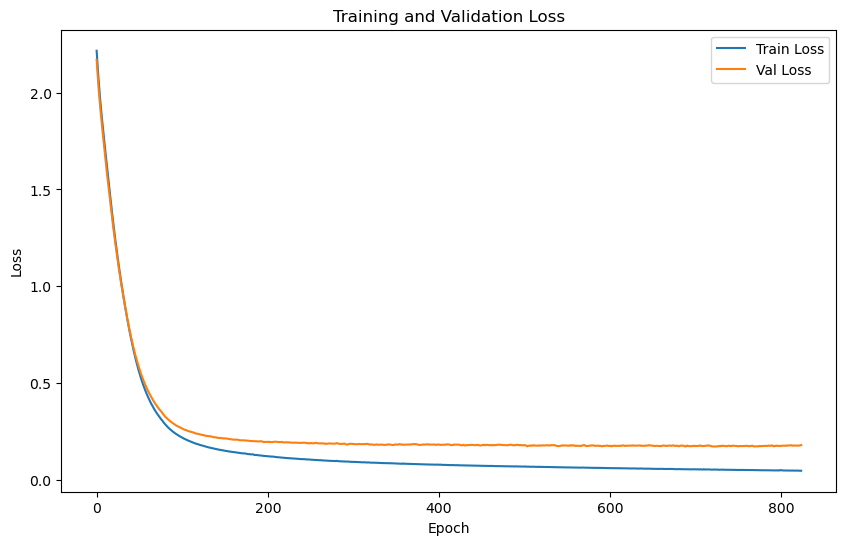

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.1923 | Test Accuracy: 95.09%


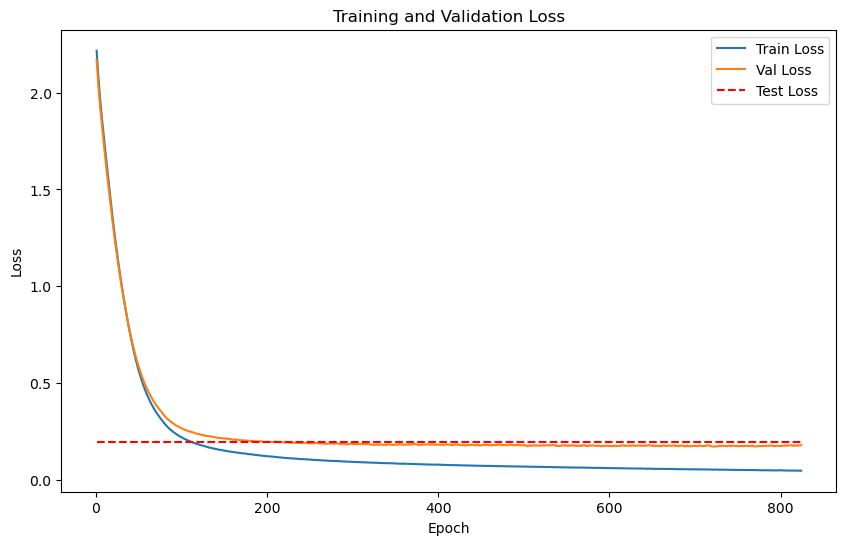

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4390
    Batch [2/2], Train Loss: 0.4322
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3640
Epoch [1/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3640

Validation loss improved from inf to 0.3640. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4368


    Batch [2/2], Train Loss: 0.4361
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3602
Epoch [2/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3602

Validation loss improved from 0.3640 to 0.3602. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 0.4375


    Batch [2/2], Train Loss: 0.4278
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3566
Epoch [3/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.3566

Validation loss improved from 0.3602 to 0.3566. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4400
    Batch [2/2], Train Loss: 0.4309
LOG: Epoch [4/2000] - Validation


    Batch [1/1], Val Loss: 0.3549
Epoch [4/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.3549

Validation loss improved from 0.3566 to 0.3549. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 0.4278
    Batch [2/2], Train Loss: 0.4296
LOG: Epoch [5/2000] - Validation


    Batch [1/1], Val Loss: 0.3547
Epoch [5/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3547

Validation loss improved from 0.3549 to 0.3547. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4267
    Batch [2/2], Train Loss: 0.4284
LOG: Epoch [6/2000] - Validation


    Batch [1/1], Val Loss: 0.3556
Epoch [6/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.3556

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.4202
    Batch [2/2], Train Loss: 0.4192
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.3562
Epoch [7/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.3562

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4238
    Batch [2/2], Train Loss: 0.4218
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [8/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.3561

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.4209
    Batch [2/2], Train Loss: 0.4189
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [9/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 0.4263


    Batch [2/2], Train Loss: 0.4169
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3553
Epoch [10/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.3553

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4253
    Batch [2/2], Train Loss: 0.4165
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.3548
Epoch [11/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.4202
    Batch [2/2], Train Loss: 0.4179
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3541
Epoch [12/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.3541

Validation loss improved from 0.3547 to 0.3541. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4175
    Batch [2/2], Train Loss: 0.4122
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3533
Epoch [13/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3533

Validation loss improved from 0.3541 to 0.3533. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.4166


    Batch [2/2], Train Loss: 0.4158
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [14/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.3522

Validation loss improved from 0.3533 to 0.3522. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4122
    Batch [2/2], Train Loss: 0.4111
LOG: Epoch [15/2000] - Validation


    Batch [1/1], Val Loss: 0.3511
Epoch [15/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3511

Validation loss improved from 0.3522 to 0.3511. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4085
    Batch [2/2], Train Loss: 0.4107
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3499
Epoch [16/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3499

Validation loss improved from 0.3511 to 0.3499. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.4015
    Batch [2/2], Train Loss: 0.4128
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [17/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3486

Validation loss improved from 0.3499 to 0.3486. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4055


    Batch [2/2], Train Loss: 0.4134
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.3473
Epoch [18/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.3473

Validation loss improved from 0.3486 to 0.3473. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4134
    Batch [2/2], Train Loss: 0.4077
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.3461
Epoch [19/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.3461

Validation loss improved from 0.3473 to 0.3461. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 0.3960
    Batch [2/2], Train Loss: 0.4048
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3449
Epoch [20/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3449

Validation loss improved from 0.3461 to 0.3449. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4077
    Batch [2/2], Train Loss: 0.4022
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [21/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3437

Validation loss improved from 0.3449 to 0.3437. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4060


    Batch [2/2], Train Loss: 0.4030
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.3425
Epoch [22/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3425

Validation loss improved from 0.3437 to 0.3425. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.4033
    Batch [2/2], Train Loss: 0.3954
LOG: Epoch [23/2000] - Validation


    Batch [1/1], Val Loss: 0.3413
Epoch [23/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3413

Validation loss improved from 0.3425 to 0.3413. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.3926
    Batch [2/2], Train Loss: 0.3986
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [24/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3401

Validation loss improved from 0.3413 to 0.3401. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.3891
    Batch [2/2], Train Loss: 0.3968
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3390
Epoch [25/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3390

Validation loss improved from 0.3401 to 0.3390. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.4059


    Batch [2/2], Train Loss: 0.3995
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [26/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3378

Validation loss improved from 0.3390 to 0.3378. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.3928


    Batch [2/2], Train Loss: 0.3915
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [27/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3368

Validation loss improved from 0.3378 to 0.3368. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 0.4005
    Batch [2/2], Train Loss: 0.3902
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [28/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.3358

Validation loss improved from 0.3368 to 0.3358. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.3937
    Batch [2/2], Train Loss: 0.3930
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3347
Epoch [29/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3347

Validation loss improved from 0.3358 to 0.3347. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.3994


    Batch [2/2], Train Loss: 0.3971
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [30/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3333

Validation loss improved from 0.3347 to 0.3333. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.3832
    Batch [2/2], Train Loss: 0.3935
LOG: Epoch [31/2000] - Validation


    Batch [1/1], Val Loss: 0.3322
Epoch [31/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.3322

Validation loss improved from 0.3333 to 0.3322. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.3875
    Batch [2/2], Train Loss: 0.3933
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3310
Epoch [32/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3310

Validation loss improved from 0.3322 to 0.3310. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.3896
    Batch [2/2], Train Loss: 0.3933
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [33/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3298

Validation loss improved from 0.3310 to 0.3298. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 0.3857


    Batch [2/2], Train Loss: 0.3819
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3286
Epoch [34/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3286

Validation loss improved from 0.3298 to 0.3286. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.3877
    Batch [2/2], Train Loss: 0.3843
LOG: Epoch [35/2000] - Validation


    Batch [1/1], Val Loss: 0.3272
Epoch [35/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.3272

Validation loss improved from 0.3286 to 0.3272. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.3820
    Batch [2/2], Train Loss: 0.3745
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [36/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.3262

Validation loss improved from 0.3272 to 0.3262. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.3872
    Batch [2/2], Train Loss: 0.3827
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3249
Epoch [37/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.3249

Validation loss improved from 0.3262 to 0.3249. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.3835


    Batch [2/2], Train Loss: 0.3819
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [38/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3238

Validation loss improved from 0.3249 to 0.3238. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.3881
    Batch [2/2], Train Loss: 0.3671
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.3228
Epoch [39/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3228

Validation loss improved from 0.3238 to 0.3228. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.3778
    Batch [2/2], Train Loss: 0.3697
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3217
Epoch [40/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3217

Validation loss improved from 0.3228 to 0.3217. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.3753
    Batch [2/2], Train Loss: 0.3730
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [41/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3207

Validation loss improved from 0.3217 to 0.3207. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.3779


    Batch [2/2], Train Loss: 0.3657
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3195
Epoch [42/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.3195

Validation loss improved from 0.3207 to 0.3195. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.3836
    Batch [2/2], Train Loss: 0.3746
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3184
Epoch [43/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.3184

Validation loss improved from 0.3195 to 0.3184. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.3697
    Batch [2/2], Train Loss: 0.3726
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3171
Epoch [44/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3171

Validation loss improved from 0.3184 to 0.3171. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.3727


    Batch [2/2], Train Loss: 0.3710
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3159
Epoch [45/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.3159

Validation loss improved from 0.3171 to 0.3159. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 0.3767


    Batch [2/2], Train Loss: 0.3744
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3147
Epoch [46/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.3147

Validation loss improved from 0.3159 to 0.3147. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.3661


    Batch [2/2], Train Loss: 0.3636
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3135
Epoch [47/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3135

Validation loss improved from 0.3147 to 0.3135. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.3731


    Batch [2/2], Train Loss: 0.3832
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3123
Epoch [48/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.3123

Validation loss improved from 0.3135 to 0.3123. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.3704
    Batch [2/2], Train Loss: 0.3660
LOG: Epoch [49/2000] - Validation


    Batch [1/1], Val Loss: 0.3111
Epoch [49/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.3111

Validation loss improved from 0.3123 to 0.3111. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 0.3571
    Batch [2/2], Train Loss: 0.3706
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [50/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3099

Validation loss improved from 0.3111 to 0.3099. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/2], Train Loss: 0.3669
    Batch [2/2], Train Loss: 0.3633
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [51/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3089

Validation loss improved from 0.3099 to 0.3089. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.3730


    Batch [2/2], Train Loss: 0.3637
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [52/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3078

Validation loss improved from 0.3089 to 0.3078. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.3537
    Batch [2/2], Train Loss: 0.3545
LOG: Epoch [53/2000] - Validation


    Batch [1/1], Val Loss: 0.3068
Epoch [53/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.3068

Validation loss improved from 0.3078 to 0.3068. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 0.3716
    Batch [2/2], Train Loss: 0.3594
LOG: Epoch [54/2000] - Validation


    Batch [1/1], Val Loss: 0.3057
Epoch [54/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3057

Validation loss improved from 0.3068 to 0.3057. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.3586
    Batch [2/2], Train Loss: 0.3592
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [55/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3045

Validation loss improved from 0.3057 to 0.3045. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.3656
    Batch [2/2], Train Loss: 0.3518
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.3033
Epoch [56/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3033

Validation loss improved from 0.3045 to 0.3033. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.3544


    Batch [2/2], Train Loss: 0.3604
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [57/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.3023

Validation loss improved from 0.3033 to 0.3023. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 0.3607


    Batch [2/2], Train Loss: 0.3561
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3011
Epoch [58/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.3011

Validation loss improved from 0.3023 to 0.3011. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.3452
    Batch [2/2], Train Loss: 0.3525
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3000
Epoch [59/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.3000

Validation loss improved from 0.3011 to 0.3000. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.3532
    Batch [2/2], Train Loss: 0.3533
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [60/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.2989

Validation loss improved from 0.3000 to 0.2989. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.3525


    Batch [2/2], Train Loss: 0.3510
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.2978
Epoch [61/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2978

Validation loss improved from 0.2989 to 0.2978. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.3554
    Batch [2/2], Train Loss: 0.3547
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [62/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2968

Validation loss improved from 0.2978 to 0.2968. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.3478
    Batch [2/2], Train Loss: 0.3463
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [63/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2957

Validation loss improved from 0.2968 to 0.2957. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.3442
    Batch [2/2], Train Loss: 0.3530
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [64/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2944

Validation loss improved from 0.2957 to 0.2944. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.3540


    Batch [2/2], Train Loss: 0.3396
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.2934
Epoch [65/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2934

Validation loss improved from 0.2944 to 0.2934. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.3387
    Batch [2/2], Train Loss: 0.3406
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.2924
Epoch [66/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2924

Validation loss improved from 0.2934 to 0.2924. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.3431
    Batch [2/2], Train Loss: 0.3480
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.2914
Epoch [67/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2914

Validation loss improved from 0.2924 to 0.2914. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.3407
    Batch [2/2], Train Loss: 0.3449
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.2904
Epoch [68/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2904

Validation loss improved from 0.2914 to 0.2904. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3382


    Batch [2/2], Train Loss: 0.3415
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [69/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.2893

Validation loss improved from 0.2904 to 0.2893. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.3454
    Batch [2/2], Train Loss: 0.3418
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.2883
Epoch [70/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2883

Validation loss improved from 0.2893 to 0.2883. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.3398
    Batch [2/2], Train Loss: 0.3368
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.2871
Epoch [71/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.2871

Validation loss improved from 0.2883 to 0.2871. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.3372
    Batch [2/2], Train Loss: 0.3421
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.2860
Epoch [72/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2860

Validation loss improved from 0.2871 to 0.2860. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.3300


    Batch [2/2], Train Loss: 0.3253
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.2850
Epoch [73/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.2850

Validation loss improved from 0.2860 to 0.2850. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.3314
    Batch [2/2], Train Loss: 0.3270
LOG: Epoch [74/2000] - Validation


    Batch [1/1], Val Loss: 0.2841
Epoch [74/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2841

Validation loss improved from 0.2850 to 0.2841. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.3419
    Batch [2/2], Train Loss: 0.3368
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.2829
Epoch [75/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.2829

Validation loss improved from 0.2841 to 0.2829. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3295
    Batch [2/2], Train Loss: 0.3453
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [76/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2819

Validation loss improved from 0.2829 to 0.2819. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.3314


    Batch [2/2], Train Loss: 0.3360
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.2809
Epoch [77/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.2809

Validation loss improved from 0.2819 to 0.2809. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.3334
    Batch [2/2], Train Loss: 0.3341
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.2799
Epoch [78/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.2799

Validation loss improved from 0.2809 to 0.2799. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.3271
    Batch [2/2], Train Loss: 0.3298
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.2792
Epoch [79/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.2792

Validation loss improved from 0.2799 to 0.2792. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 0.3234


    Batch [2/2], Train Loss: 0.3351
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.2783
Epoch [80/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.2783

Validation loss improved from 0.2792 to 0.2783. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3294
    Batch [2/2], Train Loss: 0.3219
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.2774
Epoch [81/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2774

Validation loss improved from 0.2783 to 0.2774. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3140
    Batch [2/2], Train Loss: 0.3260
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.2766
Epoch [82/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2766

Validation loss improved from 0.2774 to 0.2766. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 0.3164


    Batch [2/2], Train Loss: 0.3189
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.2758
Epoch [83/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2758

Validation loss improved from 0.2766 to 0.2758. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 0.3234
    Batch [2/2], Train Loss: 0.3292
LOG: Epoch [84/2000] - Validation


    Batch [1/1], Val Loss: 0.2748
Epoch [84/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2748

Validation loss improved from 0.2758 to 0.2748. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3323
    Batch [2/2], Train Loss: 0.3268
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.2739
Epoch [85/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.2739

Validation loss improved from 0.2748 to 0.2739. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3264
    Batch [2/2], Train Loss: 0.3236
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [86/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2728

Validation loss improved from 0.2739 to 0.2728. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.3198


    Batch [2/2], Train Loss: 0.3151
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.2718
Epoch [87/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2718

Validation loss improved from 0.2728 to 0.2718. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.3187
    Batch [2/2], Train Loss: 0.3196
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.2708
Epoch [88/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2708

Validation loss improved from 0.2718 to 0.2708. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3187
    Batch [2/2], Train Loss: 0.3155
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.2700
Epoch [89/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.2700

Validation loss improved from 0.2708 to 0.2700. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3430


    Batch [2/2], Train Loss: 0.3146
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.2691
Epoch [90/2000], Avg Train Loss: 0.3288, Avg Val Loss: 0.2691

Validation loss improved from 0.2700 to 0.2691. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.3149
    Batch [2/2], Train Loss: 0.3030
LOG: Epoch [91/2000] - Validation


    Batch [1/1], Val Loss: 0.2684
Epoch [91/2000], Avg Train Loss: 0.3090, Avg Val Loss: 0.2684

Validation loss improved from 0.2691 to 0.2684. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3250
    Batch [2/2], Train Loss: 0.3141
LOG: Epoch [92/2000] - Validation


    Batch [1/1], Val Loss: 0.2675
Epoch [92/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.2675

Validation loss improved from 0.2684 to 0.2675. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3173
    Batch [2/2], Train Loss: 0.3214
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.2665
Epoch [93/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2665

Validation loss improved from 0.2675 to 0.2665. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.3258
    Batch [2/2], Train Loss: 0.3153
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.2657
Epoch [94/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.2657

Validation loss improved from 0.2665 to 0.2657. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.3122


    Batch [2/2], Train Loss: 0.3212
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.2647
Epoch [95/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.2647

Validation loss improved from 0.2657 to 0.2647. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.3250
    Batch [2/2], Train Loss: 0.3074
LOG: Epoch [96/2000] - Validation


    Batch [1/1], Val Loss: 0.2640
Epoch [96/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.2640

Validation loss improved from 0.2647 to 0.2640. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.3148
    Batch [2/2], Train Loss: 0.3152
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.2632
Epoch [97/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.2632

Validation loss improved from 0.2640 to 0.2632. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.3139
    Batch [2/2], Train Loss: 0.3119
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.2622
Epoch [98/2000], Avg Train Loss: 0.3129, Avg Val Loss: 0.2622

Validation loss improved from 0.2632 to 0.2622. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.3110


    Batch [2/2], Train Loss: 0.3189
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.2615
Epoch [99/2000], Avg Train Loss: 0.3149, Avg Val Loss: 0.2615

Validation loss improved from 0.2622 to 0.2615. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3222


    Batch [2/2], Train Loss: 0.3060
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.2606
Epoch [100/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.2606

Validation loss improved from 0.2615 to 0.2606. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.3183
    Batch [2/2], Train Loss: 0.3143
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.2597
Epoch [101/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2597

Validation loss improved from 0.2606 to 0.2597. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.3039
    Batch [2/2], Train Loss: 0.3034
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.2590
Epoch [102/2000], Avg Train Loss: 0.3037, Avg Val Loss: 0.2590

Validation loss improved from 0.2597 to 0.2590. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/2], Train Loss: 0.3099
    Batch [2/2], Train Loss: 0.3043
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.2583
Epoch [103/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.2583

Validation loss improved from 0.2590 to 0.2583. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.3129


    Batch [2/2], Train Loss: 0.3066
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.2575
Epoch [104/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.2575

Validation loss improved from 0.2583 to 0.2575. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.3143
    Batch [2/2], Train Loss: 0.3002
LOG: Epoch [105/2000] - Validation


    Batch [1/1], Val Loss: 0.2569
Epoch [105/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.2569

Validation loss improved from 0.2575 to 0.2569. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 0.2931
    Batch [2/2], Train Loss: 0.2953
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.2561
Epoch [106/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.2561

Validation loss improved from 0.2569 to 0.2561. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.3117
    Batch [2/2], Train Loss: 0.2958
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.2553
Epoch [107/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.2553

Validation loss improved from 0.2561 to 0.2553. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.3014


    Batch [2/2], Train Loss: 0.2995
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.2546
Epoch [108/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.2546

Validation loss improved from 0.2553 to 0.2546. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.3019
    Batch [2/2], Train Loss: 0.2995
LOG: Epoch [109/2000] - Validation


    Batch [1/1], Val Loss: 0.2539
Epoch [109/2000], Avg Train Loss: 0.3007, Avg Val Loss: 0.2539

Validation loss improved from 0.2546 to 0.2539. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 0.2856
    Batch [2/2], Train Loss: 0.3007
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.2532
Epoch [110/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.2532

Validation loss improved from 0.2539 to 0.2532. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/2], Train Loss: 0.3153
    Batch [2/2], Train Loss: 0.2934
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.2525
Epoch [111/2000], Avg Train Loss: 0.3044, Avg Val Loss: 0.2525

Validation loss improved from 0.2532 to 0.2525. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.2994


    Batch [2/2], Train Loss: 0.3033
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.2517
Epoch [112/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2517

Validation loss improved from 0.2525 to 0.2517. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.2912
    Batch [2/2], Train Loss: 0.2973
LOG: Epoch [113/2000] - Validation


    Batch [1/1], Val Loss: 0.2511
Epoch [113/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.2511

Validation loss improved from 0.2517 to 0.2511. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.3030
    Batch [2/2], Train Loss: 0.2978
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.2504
Epoch [114/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.2504

Validation loss improved from 0.2511 to 0.2504. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.2950
    Batch [2/2], Train Loss: 0.2970
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.2499
Epoch [115/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2499

Validation loss improved from 0.2504 to 0.2499. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.2929


    Batch [2/2], Train Loss: 0.2938
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.2493
Epoch [116/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.2493

Validation loss improved from 0.2499 to 0.2493. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.2939
    Batch [2/2], Train Loss: 0.2938
LOG: Epoch [117/2000] - Validation


    Batch [1/1], Val Loss: 0.2489
Epoch [117/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2489

Validation loss improved from 0.2493 to 0.2489. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.2972
    Batch [2/2], Train Loss: 0.2976
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.2482
Epoch [118/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.2482

Validation loss improved from 0.2489 to 0.2482. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.2897
    Batch [2/2], Train Loss: 0.2899
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.2475
Epoch [119/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.2475

Validation loss improved from 0.2482 to 0.2475. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.2898


    Batch [2/2], Train Loss: 0.2929
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.2471
Epoch [120/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.2471

Validation loss improved from 0.2475 to 0.2471. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.2995


    Batch [2/2], Train Loss: 0.3014
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.2464
Epoch [121/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.2464

Validation loss improved from 0.2471 to 0.2464. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.2884
    Batch [2/2], Train Loss: 0.2992
LOG: Epoch [122/2000] - Validation


    Batch [1/1], Val Loss: 0.2457
Epoch [122/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2457

Validation loss improved from 0.2464 to 0.2457. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 0.2954
    Batch [2/2], Train Loss: 0.2929
LOG: Epoch [123/2000] - Validation


    Batch [1/1], Val Loss: 0.2451
Epoch [123/2000], Avg Train Loss: 0.2942, Avg Val Loss: 0.2451

Validation loss improved from 0.2457 to 0.2451. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.2836
    Batch [2/2], Train Loss: 0.2910
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.2445
Epoch [124/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2445

Validation loss improved from 0.2451 to 0.2445. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.2845
    Batch [2/2], Train Loss: 0.2842
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [125/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2442

Validation loss improved from 0.2445 to 0.2442. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.2920
    Batch [2/2], Train Loss: 0.2926
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.2437
Epoch [126/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.2437

Validation loss improved from 0.2442 to 0.2437. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.2688
    Batch [2/2], Train Loss: 0.2956
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.2432
Epoch [127/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.2432

Validation loss improved from 0.2437 to 0.2432. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.2860
    Batch [2/2], Train Loss: 0.2732
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.2429
Epoch [128/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2429

Validation loss improved from 0.2432 to 0.2429. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.2754


    Batch [2/2], Train Loss: 0.2760
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.2423
Epoch [129/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.2423

Validation loss improved from 0.2429 to 0.2423. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.2904
    Batch [2/2], Train Loss: 0.2850
LOG: Epoch [130/2000] - Validation


    Batch [1/1], Val Loss: 0.2416
Epoch [130/2000], Avg Train Loss: 0.2877, Avg Val Loss: 0.2416

Validation loss improved from 0.2423 to 0.2416. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.2756
    Batch [2/2], Train Loss: 0.2848
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.2409
Epoch [131/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2409

Validation loss improved from 0.2416 to 0.2409. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.2750
    Batch [2/2], Train Loss: 0.2819
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.2404
Epoch [132/2000], Avg Train Loss: 0.2785, Avg Val Loss: 0.2404

Validation loss improved from 0.2409 to 0.2404. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.2819


    Batch [2/2], Train Loss: 0.2783
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.2397
Epoch [133/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2397

Validation loss improved from 0.2404 to 0.2397. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.2821
    Batch [2/2], Train Loss: 0.2815
LOG: Epoch [134/2000] - Validation


    Batch [1/1], Val Loss: 0.2391
Epoch [134/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.2391

Validation loss improved from 0.2397 to 0.2391. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.2917
    Batch [2/2], Train Loss: 0.2684
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.2386
Epoch [135/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.2386

Validation loss improved from 0.2391 to 0.2386. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.2700
    Batch [2/2], Train Loss: 0.2736
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.2380
Epoch [136/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.2380

Validation loss improved from 0.2386 to 0.2380. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.2761


    Batch [2/2], Train Loss: 0.2783
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.2374
Epoch [137/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.2374

Validation loss improved from 0.2380 to 0.2374. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.2708


    Batch [2/2], Train Loss: 0.2731
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2369
Epoch [138/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2369

Validation loss improved from 0.2374 to 0.2369. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 0.2749
    Batch [2/2], Train Loss: 0.2616
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.2363
Epoch [139/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2363

Validation loss improved from 0.2369 to 0.2363. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.2754
    Batch [2/2], Train Loss: 0.2849
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2356
Epoch [140/2000], Avg Train Loss: 0.2802, Avg Val Loss: 0.2356

Validation loss improved from 0.2363 to 0.2356. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.2720
    Batch [2/2], Train Loss: 0.2764
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2349
Epoch [141/2000], Avg Train Loss: 0.2742, Avg Val Loss: 0.2349

Validation loss improved from 0.2356 to 0.2349. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.2792


    Batch [2/2], Train Loss: 0.2687
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.2340
Epoch [142/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2340

Validation loss improved from 0.2349 to 0.2340. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.2730
    Batch [2/2], Train Loss: 0.2781
LOG: Epoch [143/2000] - Validation


    Batch [1/1], Val Loss: 0.2334
Epoch [143/2000], Avg Train Loss: 0.2756, Avg Val Loss: 0.2334

Validation loss improved from 0.2340 to 0.2334. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.2659
    Batch [2/2], Train Loss: 0.2726
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2328
Epoch [144/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.2328

Validation loss improved from 0.2334 to 0.2328. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.2830
    Batch [2/2], Train Loss: 0.2645
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.2322
Epoch [145/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.2322

Validation loss improved from 0.2328 to 0.2322. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.2897


    Batch [2/2], Train Loss: 0.2717
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.2315
Epoch [146/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2315

Validation loss improved from 0.2322 to 0.2315. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.2574


    Batch [2/2], Train Loss: 0.2617
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.2311
Epoch [147/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2311

Validation loss improved from 0.2315 to 0.2311. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.2679


    Batch [2/2], Train Loss: 0.2605
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.2307
Epoch [148/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2307

Validation loss improved from 0.2311 to 0.2307. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.2703


    Batch [2/2], Train Loss: 0.2513
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.2303
Epoch [149/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.2303

Validation loss improved from 0.2307 to 0.2303. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.2729
    Batch [2/2], Train Loss: 0.2616
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.2299
Epoch [150/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2299

Validation loss improved from 0.2303 to 0.2299. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.2647
    Batch [2/2], Train Loss: 0.2802
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.2295
Epoch [151/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2295

Validation loss improved from 0.2299 to 0.2295. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/2], Train Loss: 0.2781
    Batch [2/2], Train Loss: 0.2657
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.2290
Epoch [152/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2290

Validation loss improved from 0.2295 to 0.2290. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 0.2630


    Batch [2/2], Train Loss: 0.2612
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.2285
Epoch [153/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2285

Validation loss improved from 0.2290 to 0.2285. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.2637


    Batch [2/2], Train Loss: 0.2564
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.2280
Epoch [154/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2280

Validation loss improved from 0.2285 to 0.2280. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.2650
    Batch [2/2], Train Loss: 0.2562
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.2276
Epoch [155/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.2276

Validation loss improved from 0.2280 to 0.2276. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.2605
    Batch [2/2], Train Loss: 0.2542
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.2271
Epoch [156/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.2271

Validation loss improved from 0.2276 to 0.2271. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.2641


    Batch [2/2], Train Loss: 0.2637
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2266
Epoch [157/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2266

Validation loss improved from 0.2271 to 0.2266. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.2668


    Batch [2/2], Train Loss: 0.2699
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.2261
Epoch [158/2000], Avg Train Loss: 0.2683, Avg Val Loss: 0.2261

Validation loss improved from 0.2266 to 0.2261. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.2698


    Batch [2/2], Train Loss: 0.2593
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.2254
Epoch [159/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2254

Validation loss improved from 0.2261 to 0.2254. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 0.2715
    Batch [2/2], Train Loss: 0.2693
LOG: Epoch [160/2000] - Validation


    Batch [1/1], Val Loss: 0.2248
Epoch [160/2000], Avg Train Loss: 0.2704, Avg Val Loss: 0.2248

Validation loss improved from 0.2254 to 0.2248. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.2449
    Batch [2/2], Train Loss: 0.2506
LOG: Epoch [161/2000] - Validation


    Batch [1/1], Val Loss: 0.2244
Epoch [161/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.2244

Validation loss improved from 0.2248 to 0.2244. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.2601
    Batch [2/2], Train Loss: 0.2518
LOG: Epoch [162/2000] - Validation


    Batch [1/1], Val Loss: 0.2239
Epoch [162/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.2239

Validation loss improved from 0.2244 to 0.2239. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.2645


    Batch [2/2], Train Loss: 0.2488
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2235
Epoch [163/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.2235

Validation loss improved from 0.2239 to 0.2235. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.2660
    Batch [2/2], Train Loss: 0.2741
LOG: Epoch [164/2000] - Validation


    Batch [1/1], Val Loss: 0.2230
Epoch [164/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.2230

Validation loss improved from 0.2235 to 0.2230. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.2712
    Batch [2/2], Train Loss: 0.2457
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.2227
Epoch [165/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.2227

Validation loss improved from 0.2230 to 0.2227. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.2754
    Batch [2/2], Train Loss: 0.2625
LOG: Epoch [166/2000] - Validation


    Batch [1/1], Val Loss: 0.2222
Epoch [166/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2222

Validation loss improved from 0.2227 to 0.2222. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.2561
    Batch [2/2], Train Loss: 0.2614
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2218
Epoch [167/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.2218

Validation loss improved from 0.2222 to 0.2218. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.2445
    Batch [2/2], Train Loss: 0.2665
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.2215
Epoch [168/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.2215

Validation loss improved from 0.2218 to 0.2215. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.2571
    Batch [2/2], Train Loss: 0.2501
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.2212
Epoch [169/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.2212

Validation loss improved from 0.2215 to 0.2212. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.2604


    Batch [2/2], Train Loss: 0.2560
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.2209
Epoch [170/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.2209

Validation loss improved from 0.2212 to 0.2209. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.2649
    Batch [2/2], Train Loss: 0.2477
LOG: Epoch [171/2000] - Validation


    Batch [1/1], Val Loss: 0.2207
Epoch [171/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2207

Validation loss improved from 0.2209 to 0.2207. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.2514
    Batch [2/2], Train Loss: 0.2485
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.2203
Epoch [172/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2203

Validation loss improved from 0.2207 to 0.2203. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.2621
    Batch [2/2], Train Loss: 0.2569
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.2200
Epoch [173/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.2200

Validation loss improved from 0.2203 to 0.2200. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.2546


    Batch [2/2], Train Loss: 0.2480
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.2197
Epoch [174/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.2197

Validation loss improved from 0.2200 to 0.2197. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.2459
    Batch [2/2], Train Loss: 0.2612
LOG: Epoch [175/2000] - Validation


    Batch [1/1], Val Loss: 0.2193
Epoch [175/2000], Avg Train Loss: 0.2535, Avg Val Loss: 0.2193

Validation loss improved from 0.2197 to 0.2193. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.2542
    Batch [2/2], Train Loss: 0.2547
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.2190
Epoch [176/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.2190

Validation loss improved from 0.2193 to 0.2190. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.2546
    Batch [2/2], Train Loss: 0.2531
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2187
Epoch [177/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2187

Validation loss improved from 0.2190 to 0.2187. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.2516


    Batch [2/2], Train Loss: 0.2603
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.2183
Epoch [178/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.2183

Validation loss improved from 0.2187 to 0.2183. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.2467
    Batch [2/2], Train Loss: 0.2494
LOG: Epoch [179/2000] - Validation


    Batch [1/1], Val Loss: 0.2180
Epoch [179/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2180

Validation loss improved from 0.2183 to 0.2180. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.2425
    Batch [2/2], Train Loss: 0.2566
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.2175
Epoch [180/2000], Avg Train Loss: 0.2495, Avg Val Loss: 0.2175

Validation loss improved from 0.2180 to 0.2175. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.2504
    Batch [2/2], Train Loss: 0.2467
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.2174
Epoch [181/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.2174

Validation loss improved from 0.2175 to 0.2174. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.2498


    Batch [2/2], Train Loss: 0.2439
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2171
Epoch [182/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2171

Validation loss improved from 0.2174 to 0.2171. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 0.2452
    Batch [2/2], Train Loss: 0.2459
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.2167
Epoch [183/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.2167

Validation loss improved from 0.2171 to 0.2167. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.2439
    Batch [2/2], Train Loss: 0.2473
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.2163
Epoch [184/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2163

Validation loss improved from 0.2167 to 0.2163. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/2], Train Loss: 0.2506
    Batch [2/2], Train Loss: 0.2517
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.2156
Epoch [185/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.2156

Validation loss improved from 0.2163 to 0.2156. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.2429
    Batch [2/2], Train Loss: 0.2338
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2151
Epoch [186/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.2151

Validation loss improved from 0.2156 to 0.2151. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 0.2455


    Batch [2/2], Train Loss: 0.2401
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2148
Epoch [187/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.2148

Validation loss improved from 0.2151 to 0.2148. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.2450
    Batch [2/2], Train Loss: 0.2530
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.2144
Epoch [188/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.2144

Validation loss improved from 0.2148 to 0.2144. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.2400
    Batch [2/2], Train Loss: 0.2423
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.2141
Epoch [189/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.2141

Validation loss improved from 0.2144 to 0.2141. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.2496
    Batch [2/2], Train Loss: 0.2414
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.2138
Epoch [190/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.2138

Validation loss improved from 0.2141 to 0.2138. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 0.2363


    Batch [2/2], Train Loss: 0.2419
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2136
Epoch [191/2000], Avg Train Loss: 0.2391, Avg Val Loss: 0.2136

Validation loss improved from 0.2138 to 0.2136. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.2339
    Batch [2/2], Train Loss: 0.2437
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.2132
Epoch [192/2000], Avg Train Loss: 0.2388, Avg Val Loss: 0.2132

Validation loss improved from 0.2136 to 0.2132. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.2479
    Batch [2/2], Train Loss: 0.2456
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2129
Epoch [193/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2129

Validation loss improved from 0.2132 to 0.2129. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.2477


    Batch [2/2], Train Loss: 0.2331
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.2126
Epoch [194/2000], Avg Train Loss: 0.2404, Avg Val Loss: 0.2126

Validation loss improved from 0.2129 to 0.2126. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.2191
    Batch [2/2], Train Loss: 0.2345
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.2124
Epoch [195/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.2124

Validation loss improved from 0.2126 to 0.2124. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.2406
    Batch [2/2], Train Loss: 0.2439
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.2122
Epoch [196/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.2122

Validation loss improved from 0.2124 to 0.2122. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.2438
    Batch [2/2], Train Loss: 0.2387
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2119
Epoch [197/2000], Avg Train Loss: 0.2413, Avg Val Loss: 0.2119

Validation loss improved from 0.2122 to 0.2119. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 0.2399


    Batch [2/2], Train Loss: 0.2351
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2116
Epoch [198/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.2116

Validation loss improved from 0.2119 to 0.2116. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.2294
    Batch [2/2], Train Loss: 0.2478
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.2113
Epoch [199/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2113

Validation loss improved from 0.2116 to 0.2113. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.2424
    Batch [2/2], Train Loss: 0.2447
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.2111
Epoch [200/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.2111

Validation loss improved from 0.2113 to 0.2111. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.2313
    Batch [2/2], Train Loss: 0.2446
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2108
Epoch [201/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.2108

Validation loss improved from 0.2111 to 0.2108. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.2426


    Batch [2/2], Train Loss: 0.2436
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2106
Epoch [202/2000], Avg Train Loss: 0.2431, Avg Val Loss: 0.2106

Validation loss improved from 0.2108 to 0.2106. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.2289
    Batch [2/2], Train Loss: 0.2330
LOG: Epoch [203/2000] - Validation


    Batch [1/1], Val Loss: 0.2102
Epoch [203/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.2102

Validation loss improved from 0.2106 to 0.2102. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 0.2464
    Batch [2/2], Train Loss: 0.2405
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2101
Epoch [204/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.2101

Validation loss improved from 0.2102 to 0.2101. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.2310
    Batch [2/2], Train Loss: 0.2308
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2100
Epoch [205/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.2100

Validation loss improved from 0.2101 to 0.2100. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.2289


    Batch [2/2], Train Loss: 0.2306
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2100
Epoch [206/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.2100

Validation loss improved from 0.2100 to 0.2100. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.2402
    Batch [2/2], Train Loss: 0.2382
LOG: Epoch [207/2000] - Validation


    Batch [1/1], Val Loss: 0.2098
Epoch [207/2000], Avg Train Loss: 0.2392, Avg Val Loss: 0.2098

Validation loss improved from 0.2100 to 0.2098. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 0.2421
    Batch [2/2], Train Loss: 0.2272
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.2095
Epoch [208/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.2095

Validation loss improved from 0.2098 to 0.2095. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.2284
    Batch [2/2], Train Loss: 0.2199
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2093
Epoch [209/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.2093

Validation loss improved from 0.2095 to 0.2093. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.2317


    Batch [2/2], Train Loss: 0.2242
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2091
Epoch [210/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.2091

Validation loss improved from 0.2093 to 0.2091. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.2402
    Batch [2/2], Train Loss: 0.2349
LOG: Epoch [211/2000] - Validation


    Batch [1/1], Val Loss: 0.2088
Epoch [211/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.2088

Validation loss improved from 0.2091 to 0.2088. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.2326
    Batch [2/2], Train Loss: 0.2410
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.2085
Epoch [212/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.2085

Validation loss improved from 0.2088 to 0.2085. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.2507
    Batch [2/2], Train Loss: 0.2405
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.2082
Epoch [213/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2082

Validation loss improved from 0.2085 to 0.2082. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.2231


    Batch [2/2], Train Loss: 0.2421
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.2080
Epoch [214/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.2080

Validation loss improved from 0.2082 to 0.2080. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.2161
    Batch [2/2], Train Loss: 0.2359
LOG: Epoch [215/2000] - Validation


    Batch [1/1], Val Loss: 0.2076
Epoch [215/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2076

Validation loss improved from 0.2080 to 0.2076. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.2482
    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.2073
Epoch [216/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2073

Validation loss improved from 0.2076 to 0.2073. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2203
    Batch [2/2], Train Loss: 0.2203
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.2069
Epoch [217/2000], Avg Train Loss: 0.2203, Avg Val Loss: 0.2069

Validation loss improved from 0.2073 to 0.2069. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.2158


    Batch [2/2], Train Loss: 0.2057
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.2068
Epoch [218/2000], Avg Train Loss: 0.2107, Avg Val Loss: 0.2068

Validation loss improved from 0.2069 to 0.2068. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.2247
    Batch [2/2], Train Loss: 0.2174
LOG: Epoch [219/2000] - Validation


    Batch [1/1], Val Loss: 0.2064
Epoch [219/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.2064

Validation loss improved from 0.2068 to 0.2064. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.2324
    Batch [2/2], Train Loss: 0.2401
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.2062
Epoch [220/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.2062

Validation loss improved from 0.2064 to 0.2062. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/2], Train Loss: 0.2330
    Batch [2/2], Train Loss: 0.2245
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.2058
Epoch [221/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2058

Validation loss improved from 0.2062 to 0.2058. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.2304


    Batch [2/2], Train Loss: 0.2321
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.2056
Epoch [222/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.2056

Validation loss improved from 0.2058 to 0.2056. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.2281
    Batch [2/2], Train Loss: 0.2126
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.2054
Epoch [223/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.2054

Validation loss improved from 0.2056 to 0.2054. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.2098
    Batch [2/2], Train Loss: 0.2265
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.2052
Epoch [224/2000], Avg Train Loss: 0.2181, Avg Val Loss: 0.2052

Validation loss improved from 0.2054 to 0.2052. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.2261
    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.2049
Epoch [225/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2049

Validation loss improved from 0.2052 to 0.2049. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.2239


    Batch [2/2], Train Loss: 0.2250
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.2049
Epoch [226/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.2049

Validation loss improved from 0.2049 to 0.2049. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.2144


    Batch [2/2], Train Loss: 0.2207
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.2047
Epoch [227/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2047

Validation loss improved from 0.2049 to 0.2047. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.2264
    Batch [2/2], Train Loss: 0.2154
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.2045
Epoch [228/2000], Avg Train Loss: 0.2209, Avg Val Loss: 0.2045

Validation loss improved from 0.2047 to 0.2045. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 0.2165
    Batch [2/2], Train Loss: 0.2244
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.2043
Epoch [229/2000], Avg Train Loss: 0.2205, Avg Val Loss: 0.2043

Validation loss improved from 0.2045 to 0.2043. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.2325
    Batch [2/2], Train Loss: 0.2249
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.2041
Epoch [230/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.2041

Validation loss improved from 0.2043 to 0.2041. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.2114


    Batch [2/2], Train Loss: 0.2230
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [231/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.2039

Validation loss improved from 0.2041 to 0.2039. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.2291
    Batch [2/2], Train Loss: 0.2267
LOG: Epoch [232/2000] - Validation


    Batch [1/1], Val Loss: 0.2034
Epoch [232/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.2034

Validation loss improved from 0.2039 to 0.2034. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.2343
    Batch [2/2], Train Loss: 0.2278
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.2030
Epoch [233/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.2030

Validation loss improved from 0.2034 to 0.2030. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/2], Train Loss: 0.2257
    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.2027
Epoch [234/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.2027

Validation loss improved from 0.2030 to 0.2027. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.2067


    Batch [2/2], Train Loss: 0.2277
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.2025
Epoch [235/2000], Avg Train Loss: 0.2172, Avg Val Loss: 0.2025

Validation loss improved from 0.2027 to 0.2025. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.2288
    Batch [2/2], Train Loss: 0.2143
LOG: Epoch [236/2000] - Validation


    Batch [1/1], Val Loss: 0.2023
Epoch [236/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.2023

Validation loss improved from 0.2025 to 0.2023. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.2121
    Batch [2/2], Train Loss: 0.2087
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.2023
Epoch [237/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2023

Validation loss improved from 0.2023 to 0.2023. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.2035
    Batch [2/2], Train Loss: 0.2093
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.2021
Epoch [238/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.2021

Validation loss improved from 0.2023 to 0.2021. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.2233
    Batch [2/2], Train Loss: 0.2183
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.2017
Epoch [239/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.2017

Validation loss improved from 0.2021 to 0.2017. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.2329


    Batch [2/2], Train Loss: 0.2236
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.2014
Epoch [240/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.2014

Validation loss improved from 0.2017 to 0.2014. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.2193
    Batch [2/2], Train Loss: 0.2108
LOG: Epoch [241/2000] - Validation


    Batch [1/1], Val Loss: 0.2013
Epoch [241/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.2013

Validation loss improved from 0.2014 to 0.2013. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.2208
    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [242/2000] - Validation


    Batch [1/1], Val Loss: 0.2010
Epoch [242/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2010

Validation loss improved from 0.2013 to 0.2010. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.2130
    Batch [2/2], Train Loss: 0.2088
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.2009
Epoch [243/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.2009

Validation loss improved from 0.2010 to 0.2009. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.2144
    Batch [2/2], Train Loss: 0.2318
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.2006
Epoch [244/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.2006

Validation loss improved from 0.2009 to 0.2006. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.2026
    Batch [2/2], Train Loss: 0.2112
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.2005
Epoch [245/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.2005

Validation loss improved from 0.2006 to 0.2005. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.2133


    Batch [2/2], Train Loss: 0.1963
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.2006
Epoch [246/2000], Avg Train Loss: 0.2048, Avg Val Loss: 0.2006

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.2121
    Batch [2/2], Train Loss: 0.2088
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.2005
Epoch [247/2000], Avg Train Loss: 0.2105, Avg Val Loss: 0.2005

Validation loss improved from 0.2005 to 0.2005. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.2015
    Batch [2/2], Train Loss: 0.2070
LOG: Epoch [248/2000] - Validation


    Batch [1/1], Val Loss: 0.2004
Epoch [248/2000], Avg Train Loss: 0.2043, Avg Val Loss: 0.2004

Validation loss improved from 0.2005 to 0.2004. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.2002
    Batch [2/2], Train Loss: 0.2099
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.2001
Epoch [249/2000], Avg Train Loss: 0.2050, Avg Val Loss: 0.2001

Validation loss improved from 0.2004 to 0.2001. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.2014
    Batch [2/2], Train Loss: 0.2251
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.2000
Epoch [250/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.2000

Validation loss improved from 0.2001 to 0.2000. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.2125


    Batch [2/2], Train Loss: 0.1995
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.2000
Epoch [251/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.2000

Validation loss improved from 0.2000 to 0.2000. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.2040
    Batch [2/2], Train Loss: 0.2086
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.1998
Epoch [252/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.1998

Validation loss improved from 0.2000 to 0.1998. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 0.2187
    Batch [2/2], Train Loss: 0.2088
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.1996
Epoch [253/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1996

Validation loss improved from 0.1998 to 0.1996. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.2160
    Batch [2/2], Train Loss: 0.2085
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.1993
Epoch [254/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.1993

Validation loss improved from 0.1996 to 0.1993. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.2152


    Batch [2/2], Train Loss: 0.2222
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.1991
Epoch [255/2000], Avg Train Loss: 0.2187, Avg Val Loss: 0.1991

Validation loss improved from 0.1993 to 0.1991. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.2049
    Batch [2/2], Train Loss: 0.2032
LOG: Epoch [256/2000] - Validation


    Batch [1/1], Val Loss: 0.1991
Epoch [256/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.1991

Validation loss improved from 0.1991 to 0.1991. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.1895
    Batch [2/2], Train Loss: 0.2038
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.1988
Epoch [257/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1988

Validation loss improved from 0.1991 to 0.1988. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.2147
    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.1985
Epoch [258/2000], Avg Train Loss: 0.2126, Avg Val Loss: 0.1985

Validation loss improved from 0.1988 to 0.1985. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.1972


    Batch [2/2], Train Loss: 0.2057
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.1984
Epoch [259/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.1984

Validation loss improved from 0.1985 to 0.1984. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 0.2107
    Batch [2/2], Train Loss: 0.2044
LOG: Epoch [260/2000] - Validation


    Batch [1/1], Val Loss: 0.1984
Epoch [260/2000], Avg Train Loss: 0.2076, Avg Val Loss: 0.1984

Validation loss improved from 0.1984 to 0.1984. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.2139
    Batch [2/2], Train Loss: 0.2058
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.1984
Epoch [261/2000], Avg Train Loss: 0.2098, Avg Val Loss: 0.1984

Validation loss improved from 0.1984 to 0.1984. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/2], Train Loss: 0.2168
    Batch [2/2], Train Loss: 0.2215
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [262/2000], Avg Train Loss: 0.2192, Avg Val Loss: 0.1981

Validation loss improved from 0.1984 to 0.1981. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.2070


    Batch [2/2], Train Loss: 0.1938
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.1981
Epoch [263/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1981

Validation loss improved from 0.1981 to 0.1981. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 0.2078
    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [264/2000] - Validation


    Batch [1/1], Val Loss: 0.1979
Epoch [264/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.1979

Validation loss improved from 0.1981 to 0.1979. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.2161
    Batch [2/2], Train Loss: 0.2087
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.1977
Epoch [265/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1977

Validation loss improved from 0.1979 to 0.1977. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.1941
    Batch [2/2], Train Loss: 0.1980
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.1976
Epoch [266/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.1976

Validation loss improved from 0.1977 to 0.1976. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 0.2141


    Batch [2/2], Train Loss: 0.2014
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.1977
Epoch [267/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.2017
    Batch [2/2], Train Loss: 0.2010
LOG: Epoch [268/2000] - Validation


    Batch [1/1], Val Loss: 0.1977
Epoch [268/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.1977

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.2074
    Batch [2/2], Train Loss: 0.2115
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.1975
Epoch [269/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.1975

Validation loss improved from 0.1976 to 0.1975. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.2014
    Batch [2/2], Train Loss: 0.2065
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.1974
Epoch [270/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1974

Validation loss improved from 0.1975 to 0.1974. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.2095


    Batch [2/2], Train Loss: 0.1870
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.1974
Epoch [271/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.1974

Validation loss improved from 0.1974 to 0.1974. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.2123
    Batch [2/2], Train Loss: 0.2130
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.1971
Epoch [272/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.1971

Validation loss improved from 0.1974 to 0.1971. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.2036
    Batch [2/2], Train Loss: 0.2057
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.1967
Epoch [273/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.1967

Validation loss improved from 0.1971 to 0.1967. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.1935
    Batch [2/2], Train Loss: 0.1892
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.1965
Epoch [274/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.1965

Validation loss improved from 0.1967 to 0.1965. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 0.2091


    Batch [2/2], Train Loss: 0.2035
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.1963
Epoch [275/2000], Avg Train Loss: 0.2063, Avg Val Loss: 0.1963

Validation loss improved from 0.1965 to 0.1963. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.1933
    Batch [2/2], Train Loss: 0.2151
LOG: Epoch [276/2000] - Validation


    Batch [1/1], Val Loss: 0.1961
Epoch [276/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.1961

Validation loss improved from 0.1963 to 0.1961. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.2058
    Batch [2/2], Train Loss: 0.2183
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.1959
Epoch [277/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.1959

Validation loss improved from 0.1961 to 0.1959. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.1979
    Batch [2/2], Train Loss: 0.2111
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.1957
Epoch [278/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1957

Validation loss improved from 0.1959 to 0.1957. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.2141


    Batch [2/2], Train Loss: 0.1929
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.1953
Epoch [279/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.1953

Validation loss improved from 0.1957 to 0.1953. Saving model...
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.2059
    Batch [2/2], Train Loss: 0.1965
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.1953
Epoch [280/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.1953

Validation loss improved from 0.1953 to 0.1953. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.1813
    Batch [2/2], Train Loss: 0.1880
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.1953
Epoch [281/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.1953

Validation loss improved from 0.1953 to 0.1953. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 0.2035


    Batch [2/2], Train Loss: 0.2081
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.1952
Epoch [282/2000], Avg Train Loss: 0.2058, Avg Val Loss: 0.1952

Validation loss improved from 0.1953 to 0.1952. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.2008
    Batch [2/2], Train Loss: 0.2098
LOG: Epoch [283/2000] - Validation


    Batch [1/1], Val Loss: 0.1950
Epoch [283/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1950

Validation loss improved from 0.1952 to 0.1950. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.2034
    Batch [2/2], Train Loss: 0.2043
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.1948
Epoch [284/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1948

Validation loss improved from 0.1950 to 0.1948. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.2053
    Batch [2/2], Train Loss: 0.1990
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.1943
Epoch [285/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.1943

Validation loss improved from 0.1948 to 0.1943. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.2080


    Batch [2/2], Train Loss: 0.2019
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.1942
Epoch [286/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1942

Validation loss improved from 0.1943 to 0.1942. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.1932


    Batch [2/2], Train Loss: 0.1963
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.1941
Epoch [287/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1941

Validation loss improved from 0.1942 to 0.1941. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.1850
    Batch [2/2], Train Loss: 0.1914
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.1938
Epoch [288/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.1938

Validation loss improved from 0.1941 to 0.1938. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.1982
    Batch [2/2], Train Loss: 0.2074
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.1935
Epoch [289/2000], Avg Train Loss: 0.2028, Avg Val Loss: 0.1935

Validation loss improved from 0.1938 to 0.1935. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.1919
    Batch [2/2], Train Loss: 0.1960
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.1931
Epoch [290/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.1931

Validation loss improved from 0.1935 to 0.1931. Saving model...
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.1977


    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.1928
Epoch [291/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.1928

Validation loss improved from 0.1931 to 0.1928. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.1947


    Batch [2/2], Train Loss: 0.1843
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.1924
Epoch [292/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.1924

Validation loss improved from 0.1928 to 0.1924. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.1998
    Batch [2/2], Train Loss: 0.1879
LOG: Epoch [293/2000] - Validation


    Batch [1/1], Val Loss: 0.1920
Epoch [293/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1920

Validation loss improved from 0.1924 to 0.1920. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.1941
    Batch [2/2], Train Loss: 0.2090
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.1917
Epoch [294/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.1917

Validation loss improved from 0.1920 to 0.1917. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.2051
    Batch [2/2], Train Loss: 0.1991
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.1915
Epoch [295/2000], Avg Train Loss: 0.2021, Avg Val Loss: 0.1915

Validation loss improved from 0.1917 to 0.1915. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.1960


    Batch [2/2], Train Loss: 0.1862
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.1914
Epoch [296/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.1914

Validation loss improved from 0.1915 to 0.1914. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 0.2006
    Batch [2/2], Train Loss: 0.1896
LOG: Epoch [297/2000] - Validation


    Batch [1/1], Val Loss: 0.1912
Epoch [297/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.1912

Validation loss improved from 0.1914 to 0.1912. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.1845
    Batch [2/2], Train Loss: 0.1962
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.1912
Epoch [298/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.1912

Validation loss improved from 0.1912 to 0.1912. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.1776
    Batch [2/2], Train Loss: 0.1918
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.1910
Epoch [299/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.1910

Validation loss improved from 0.1912 to 0.1910. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2033
    Batch [2/2], Train Loss: 0.2011
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.1909
Epoch [300/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.1909

Validation loss improved from 0.1910 to 0.1909. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.2069


    Batch [2/2], Train Loss: 0.1887
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.1908
Epoch [301/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.1908

Validation loss improved from 0.1909 to 0.1908. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.1775
    Batch [2/2], Train Loss: 0.2095
LOG: Epoch [302/2000] - Validation


    Batch [1/1], Val Loss: 0.1908
Epoch [302/2000], Avg Train Loss: 0.1935, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.1961
    Batch [2/2], Train Loss: 0.1920
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.1907
Epoch [303/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1907

Validation loss improved from 0.1908 to 0.1907. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.1873
    Batch [2/2], Train Loss: 0.2017
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.1908
Epoch [304/2000], Avg Train Loss: 0.1945, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.1932


    Batch [2/2], Train Loss: 0.1827
LOG: Epoch [305/2000] - Validation
    Batch [1/1], Val Loss: 0.1909
Epoch [305/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.1909

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.2008
    Batch [2/2], Train Loss: 0.1937
LOG: Epoch [306/2000] - Validation


    Batch [1/1], Val Loss: 0.1908
Epoch [306/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.1908

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.1901
    Batch [2/2], Train Loss: 0.1896
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.1906
Epoch [307/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.1906

Validation loss improved from 0.1907 to 0.1906. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.1916
    Batch [2/2], Train Loss: 0.2059
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.1904
Epoch [308/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1904

Validation loss improved from 0.1906 to 0.1904. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.1908
    Batch [2/2], Train Loss: 0.1924
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.1903
Epoch [309/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1903

Validation loss improved from 0.1904 to 0.1903. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/2], Train Loss: 0.1896
    Batch [2/2], Train Loss: 0.1796
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.1902
Epoch [310/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.1902

Validation loss improved from 0.1903 to 0.1902. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.1910


    Batch [2/2], Train Loss: 0.1704
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.1901
Epoch [311/2000], Avg Train Loss: 0.1807, Avg Val Loss: 0.1901

Validation loss improved from 0.1902 to 0.1901. Saving model...
LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 0.1938
    Batch [2/2], Train Loss: 0.1959
LOG: Epoch [312/2000] - Validation


    Batch [1/1], Val Loss: 0.1900
Epoch [312/2000], Avg Train Loss: 0.1948, Avg Val Loss: 0.1900

Validation loss improved from 0.1901 to 0.1900. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.1845
    Batch [2/2], Train Loss: 0.1929
LOG: Epoch [313/2000] - Validation


    Batch [1/1], Val Loss: 0.1899
Epoch [313/2000], Avg Train Loss: 0.1887, Avg Val Loss: 0.1899

Validation loss improved from 0.1900 to 0.1899. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.1884
    Batch [2/2], Train Loss: 0.1715
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.1900
Epoch [314/2000], Avg Train Loss: 0.1800, Avg Val Loss: 0.1900

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.1990
    Batch [2/2], Train Loss: 0.1829
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.1902
Epoch [315/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.1902

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.1749
    Batch [2/2], Train Loss: 0.1950
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.1902
Epoch [316/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.1902

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.1955


    Batch [2/2], Train Loss: 0.1837
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.1900
Epoch [317/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.1900

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.2008
    Batch [2/2], Train Loss: 0.1847
LOG: Epoch [318/2000] - Validation


    Batch [1/1], Val Loss: 0.1898
Epoch [318/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.1898

Validation loss improved from 0.1899 to 0.1898. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.1870
    Batch [2/2], Train Loss: 0.2008
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.1897
Epoch [319/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.1897

Validation loss improved from 0.1898 to 0.1897. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.1878
    Batch [2/2], Train Loss: 0.1908
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.1897
Epoch [320/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.1897

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.1933


    Batch [2/2], Train Loss: 0.1745
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.1897
Epoch [321/2000], Avg Train Loss: 0.1839, Avg Val Loss: 0.1897

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.1900
    Batch [2/2], Train Loss: 0.1945
LOG: Epoch [322/2000] - Validation


    Batch [1/1], Val Loss: 0.1896
Epoch [322/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.1896

Validation loss improved from 0.1897 to 0.1896. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.1851
    Batch [2/2], Train Loss: 0.1791
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.1895
Epoch [323/2000], Avg Train Loss: 0.1821, Avg Val Loss: 0.1895

Validation loss improved from 0.1896 to 0.1895. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.1955
    Batch [2/2], Train Loss: 0.1852
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.1895
Epoch [324/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.1895

Validation loss improved from 0.1895 to 0.1895. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.1758


    Batch [2/2], Train Loss: 0.1764
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.1896
Epoch [325/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.1896

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.1829
    Batch [2/2], Train Loss: 0.1820
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.1896
Epoch [326/2000], Avg Train Loss: 0.1824, Avg Val Loss: 0.1896

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.1886
    Batch [2/2], Train Loss: 0.2015
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.1895
Epoch [327/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1895

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.1773
    Batch [2/2], Train Loss: 0.1902
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.1893
Epoch [328/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1893

Validation loss improved from 0.1895 to 0.1893. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.1914


    Batch [2/2], Train Loss: 0.1938
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.1890
Epoch [329/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1890

Validation loss improved from 0.1893 to 0.1890. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.1816
    Batch [2/2], Train Loss: 0.1693
LOG: Epoch [330/2000] - Validation


    Batch [1/1], Val Loss: 0.1888
Epoch [330/2000], Avg Train Loss: 0.1754, Avg Val Loss: 0.1888

Validation loss improved from 0.1890 to 0.1888. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 0.1772
    Batch [2/2], Train Loss: 0.1843
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.1888
Epoch [331/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1888

Validation loss improved from 0.1888 to 0.1888. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.1705
    Batch [2/2], Train Loss: 0.1852
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.1886
Epoch [332/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1886

Validation loss improved from 0.1888 to 0.1886. Saving model...
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.1817


    Batch [2/2], Train Loss: 0.1854
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.1884
Epoch [333/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.1884

Validation loss improved from 0.1886 to 0.1884. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.1814


    Batch [2/2], Train Loss: 0.1609
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.1882
Epoch [334/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.1882

Validation loss improved from 0.1884 to 0.1882. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.1768


    Batch [2/2], Train Loss: 0.1675
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.1881
Epoch [335/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1881

Validation loss improved from 0.1882 to 0.1881. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.1654


    Batch [2/2], Train Loss: 0.1844
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.1881
Epoch [336/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.1881

Validation loss improved from 0.1881 to 0.1881. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.1910


    Batch [2/2], Train Loss: 0.1766
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.1881
Epoch [337/2000], Avg Train Loss: 0.1838, Avg Val Loss: 0.1881

Validation loss improved from 0.1881 to 0.1881. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.1774
    Batch [2/2], Train Loss: 0.1700
LOG: Epoch [338/2000] - Validation


    Batch [1/1], Val Loss: 0.1879
Epoch [338/2000], Avg Train Loss: 0.1737, Avg Val Loss: 0.1879

Validation loss improved from 0.1881 to 0.1879. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.1840
    Batch [2/2], Train Loss: 0.1687
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.1876
Epoch [339/2000], Avg Train Loss: 0.1764, Avg Val Loss: 0.1876

Validation loss improved from 0.1879 to 0.1876. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.1748
    Batch [2/2], Train Loss: 0.1619
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.1875
Epoch [340/2000], Avg Train Loss: 0.1683, Avg Val Loss: 0.1875

Validation loss improved from 0.1876 to 0.1875. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.1705


    Batch [2/2], Train Loss: 0.1679
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.1872
Epoch [341/2000], Avg Train Loss: 0.1692, Avg Val Loss: 0.1872

Validation loss improved from 0.1875 to 0.1872. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.1987


    Batch [2/2], Train Loss: 0.1867
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.1871
Epoch [342/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.1871

Validation loss improved from 0.1872 to 0.1871. Saving model...
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.1842
    Batch [2/2], Train Loss: 0.1884
LOG: Epoch [343/2000] - Validation


    Batch [1/1], Val Loss: 0.1869
Epoch [343/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.1869

Validation loss improved from 0.1871 to 0.1869. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.1835
    Batch [2/2], Train Loss: 0.1729
LOG: Epoch [344/2000] - Validation


    Batch [1/1], Val Loss: 0.1866
Epoch [344/2000], Avg Train Loss: 0.1782, Avg Val Loss: 0.1866

Validation loss improved from 0.1869 to 0.1866. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.1914
    Batch [2/2], Train Loss: 0.1697
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.1865
Epoch [345/2000], Avg Train Loss: 0.1805, Avg Val Loss: 0.1865

Validation loss improved from 0.1866 to 0.1865. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.1934
    Batch [2/2], Train Loss: 0.1715
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.1863
Epoch [346/2000], Avg Train Loss: 0.1825, Avg Val Loss: 0.1863

Validation loss improved from 0.1865 to 0.1863. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 0.1792


    Batch [2/2], Train Loss: 0.1784
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.1862
Epoch [347/2000], Avg Train Loss: 0.1788, Avg Val Loss: 0.1862

Validation loss improved from 0.1863 to 0.1862. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.1710
    Batch [2/2], Train Loss: 0.1887
LOG: Epoch [348/2000] - Validation


    Batch [1/1], Val Loss: 0.1859
Epoch [348/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.1859

Validation loss improved from 0.1862 to 0.1859. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.1626
    Batch [2/2], Train Loss: 0.1819
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.1858
Epoch [349/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1858

Validation loss improved from 0.1859 to 0.1858. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.1793
    Batch [2/2], Train Loss: 0.1847
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.1857
Epoch [350/2000], Avg Train Loss: 0.1820, Avg Val Loss: 0.1857

Validation loss improved from 0.1858 to 0.1857. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.1770
    Batch [2/2], Train Loss: 0.1881
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.1856
Epoch [351/2000], Avg Train Loss: 0.1826, Avg Val Loss: 0.1856

Validation loss improved from 0.1857 to 0.1856. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.1626


    Batch [2/2], Train Loss: 0.1728
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.1856
Epoch [352/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1856

Validation loss improved from 0.1856 to 0.1856. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.1705
    Batch [2/2], Train Loss: 0.1807
LOG: Epoch [353/2000] - Validation


    Batch [1/1], Val Loss: 0.1857
Epoch [353/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 0.1796
    Batch [2/2], Train Loss: 0.1767
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.1855
Epoch [354/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1855

Validation loss improved from 0.1856 to 0.1855. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.1715
    Batch [2/2], Train Loss: 0.1770
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.1854
Epoch [355/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1854

Validation loss improved from 0.1855 to 0.1854. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.1780


    Batch [2/2], Train Loss: 0.1822
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.1853
Epoch [356/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.1853

Validation loss improved from 0.1854 to 0.1853. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/2], Train Loss: 0.1593
    Batch [2/2], Train Loss: 0.1750
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.1851
Epoch [357/2000], Avg Train Loss: 0.1672, Avg Val Loss: 0.1851

Validation loss improved from 0.1853 to 0.1851. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.1728
    Batch [2/2], Train Loss: 0.1716
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.1848
Epoch [358/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1848

Validation loss improved from 0.1851 to 0.1848. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.1794
    Batch [2/2], Train Loss: 0.1797
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.1845
Epoch [359/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1845

Validation loss improved from 0.1848 to 0.1845. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.1719


    Batch [2/2], Train Loss: 0.1818
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.1843
Epoch [360/2000], Avg Train Loss: 0.1769, Avg Val Loss: 0.1843

Validation loss improved from 0.1845 to 0.1843. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.1664
    Batch [2/2], Train Loss: 0.1593
LOG: Epoch [361/2000] - Validation


    Batch [1/1], Val Loss: 0.1840
Epoch [361/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.1840

Validation loss improved from 0.1843 to 0.1840. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.1637
    Batch [2/2], Train Loss: 0.1681
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.1839
Epoch [362/2000], Avg Train Loss: 0.1659, Avg Val Loss: 0.1839

Validation loss improved from 0.1840 to 0.1839. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.1752
    Batch [2/2], Train Loss: 0.1701
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.1838
Epoch [363/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.1838

Validation loss improved from 0.1839 to 0.1838. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.1763


    Batch [2/2], Train Loss: 0.1792
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.1835
Epoch [364/2000], Avg Train Loss: 0.1778, Avg Val Loss: 0.1835

Validation loss improved from 0.1838 to 0.1835. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.1550
    Batch [2/2], Train Loss: 0.1669
LOG: Epoch [365/2000] - Validation


    Batch [1/1], Val Loss: 0.1832
Epoch [365/2000], Avg Train Loss: 0.1609, Avg Val Loss: 0.1832

Validation loss improved from 0.1835 to 0.1832. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.1663
    Batch [2/2], Train Loss: 0.1776
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.1829
Epoch [366/2000], Avg Train Loss: 0.1720, Avg Val Loss: 0.1829

Validation loss improved from 0.1832 to 0.1829. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.1827
    Batch [2/2], Train Loss: 0.1624
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.1827
Epoch [367/2000], Avg Train Loss: 0.1725, Avg Val Loss: 0.1827

Validation loss improved from 0.1829 to 0.1827. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.1647


    Batch [2/2], Train Loss: 0.1681
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.1825
Epoch [368/2000], Avg Train Loss: 0.1664, Avg Val Loss: 0.1825

Validation loss improved from 0.1827 to 0.1825. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.1803
    Batch [2/2], Train Loss: 0.1898
LOG: Epoch [369/2000] - Validation


    Batch [1/1], Val Loss: 0.1822
Epoch [369/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.1822

Validation loss improved from 0.1825 to 0.1822. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.1640
    Batch [2/2], Train Loss: 0.1548
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.1821
Epoch [370/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.1821

Validation loss improved from 0.1822 to 0.1821. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.1720
    Batch [2/2], Train Loss: 0.1644
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.1820
Epoch [371/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.1820

Validation loss improved from 0.1821 to 0.1820. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.1699


    Batch [2/2], Train Loss: 0.1692
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.1818
Epoch [372/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.1818

Validation loss improved from 0.1820 to 0.1818. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.1576
    Batch [2/2], Train Loss: 0.1778
LOG: Epoch [373/2000] - Validation


    Batch [1/1], Val Loss: 0.1818
Epoch [373/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1818

Validation loss improved from 0.1818 to 0.1818. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.1746
    Batch [2/2], Train Loss: 0.1671
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.1817
Epoch [374/2000], Avg Train Loss: 0.1708, Avg Val Loss: 0.1817

Validation loss improved from 0.1818 to 0.1817. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.1695
    Batch [2/2], Train Loss: 0.1718
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.1817
Epoch [375/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.1817

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.1760


    Batch [2/2], Train Loss: 0.1687
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.1816
Epoch [376/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1816

Validation loss improved from 0.1817 to 0.1816. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.1743
    Batch [2/2], Train Loss: 0.1816
LOG: Epoch [377/2000] - Validation


    Batch [1/1], Val Loss: 0.1816
Epoch [377/2000], Avg Train Loss: 0.1779, Avg Val Loss: 0.1816

Validation loss improved from 0.1816 to 0.1816. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.1739
    Batch [2/2], Train Loss: 0.1725
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.1814
Epoch [378/2000], Avg Train Loss: 0.1732, Avg Val Loss: 0.1814

Validation loss improved from 0.1816 to 0.1814. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.1726
    Batch [2/2], Train Loss: 0.1771
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.1811
Epoch [379/2000], Avg Train Loss: 0.1749, Avg Val Loss: 0.1811

Validation loss improved from 0.1814 to 0.1811. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.1821
    Batch [2/2], Train Loss: 0.1741
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.1809
Epoch [380/2000], Avg Train Loss: 0.1781, Avg Val Loss: 0.1809

Validation loss improved from 0.1811 to 0.1809. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.1794


    Batch [2/2], Train Loss: 0.1659
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.1810
Epoch [381/2000], Avg Train Loss: 0.1726, Avg Val Loss: 0.1810

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 0.1489
    Batch [2/2], Train Loss: 0.1561
LOG: Epoch [382/2000] - Validation


    Batch [1/1], Val Loss: 0.1809
Epoch [382/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.1726
    Batch [2/2], Train Loss: 0.1796
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.1809
Epoch [383/2000], Avg Train Loss: 0.1761, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.1774
    Batch [2/2], Train Loss: 0.1577
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.1809
Epoch [384/2000], Avg Train Loss: 0.1676, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 0.1619


    Batch [2/2], Train Loss: 0.1768
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.1808
Epoch [385/2000], Avg Train Loss: 0.1694, Avg Val Loss: 0.1808

Validation loss improved from 0.1809 to 0.1808. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.1571
    Batch [2/2], Train Loss: 0.1779
LOG: Epoch [386/2000] - Validation


    Batch [1/1], Val Loss: 0.1809
Epoch [386/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.1744
    Batch [2/2], Train Loss: 0.1523
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.1811
Epoch [387/2000], Avg Train Loss: 0.1633, Avg Val Loss: 0.1811

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [388/2000] - Training


    Batch [1/2], Train Loss: 0.1531
    Batch [2/2], Train Loss: 0.1549
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.1809
Epoch [388/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.1809

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.1683
    Batch [2/2], Train Loss: 0.1755
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.1808
Epoch [389/2000], Avg Train Loss: 0.1719, Avg Val Loss: 0.1808

Validation loss improved from 0.1808 to 0.1808. Saving model...
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.1547


    Batch [2/2], Train Loss: 0.1587
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.1806
Epoch [390/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.1806

Validation loss improved from 0.1808 to 0.1806. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.1781


    Batch [2/2], Train Loss: 0.1622
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.1805
Epoch [391/2000], Avg Train Loss: 0.1702, Avg Val Loss: 0.1805

Validation loss improved from 0.1806 to 0.1805. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.1562
    Batch [2/2], Train Loss: 0.1623
LOG: Epoch [392/2000] - Validation


    Batch [1/1], Val Loss: 0.1803
Epoch [392/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1803

Validation loss improved from 0.1805 to 0.1803. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 0.1563
    Batch [2/2], Train Loss: 0.1801
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.1803
Epoch [393/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.1803

Validation loss improved from 0.1803 to 0.1803. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.1669
    Batch [2/2], Train Loss: 0.1635
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.1801
Epoch [394/2000], Avg Train Loss: 0.1652, Avg Val Loss: 0.1801

Validation loss improved from 0.1803 to 0.1801. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.1708


    Batch [2/2], Train Loss: 0.1576
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.1799
Epoch [395/2000], Avg Train Loss: 0.1642, Avg Val Loss: 0.1799

Validation loss improved from 0.1801 to 0.1799. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.1567
    Batch [2/2], Train Loss: 0.1650
LOG: Epoch [396/2000] - Validation


    Batch [1/1], Val Loss: 0.1797
Epoch [396/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.1797

Validation loss improved from 0.1799 to 0.1797. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.1551


    Batch [2/2], Train Loss: 0.1683
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.1796
Epoch [397/2000], Avg Train Loss: 0.1617, Avg Val Loss: 0.1796

Validation loss improved from 0.1797 to 0.1796. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 0.1503
    Batch [2/2], Train Loss: 0.1616
LOG: Epoch [398/2000] - Validation


    Batch [1/1], Val Loss: 0.1796
Epoch [398/2000], Avg Train Loss: 0.1559, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.1631
    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.1796
Epoch [399/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.1710
    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [400/2000] - Validation


    Batch [1/1], Val Loss: 0.1796
Epoch [400/2000], Avg Train Loss: 0.1627, Avg Val Loss: 0.1796

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 0.1474
    Batch [2/2], Train Loss: 0.1596
LOG: Epoch [401/2000] - Validation


    Batch [1/1], Val Loss: 0.1797
Epoch [401/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.1797

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 0.1521
    Batch [2/2], Train Loss: 0.1507
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.1799
Epoch [402/2000], Avg Train Loss: 0.1514, Avg Val Loss: 0.1799

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.1561
    Batch [2/2], Train Loss: 0.1747
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.1797
Epoch [403/2000], Avg Train Loss: 0.1654, Avg Val Loss: 0.1797

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.1531


    Batch [2/2], Train Loss: 0.1643
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.1795
Epoch [404/2000], Avg Train Loss: 0.1587, Avg Val Loss: 0.1795

Validation loss improved from 0.1796 to 0.1795. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 0.1699


    Batch [2/2], Train Loss: 0.1631
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.1795
Epoch [405/2000], Avg Train Loss: 0.1665, Avg Val Loss: 0.1795

Validation loss improved from 0.1795 to 0.1795. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.1416
    Batch [2/2], Train Loss: 0.1605
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.1793
Epoch [406/2000], Avg Train Loss: 0.1511, Avg Val Loss: 0.1793

Validation loss improved from 0.1795 to 0.1793. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.1635
    Batch [2/2], Train Loss: 0.1617
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.1792
Epoch [407/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.1792

Validation loss improved from 0.1793 to 0.1792. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.1670
    Batch [2/2], Train Loss: 0.1679
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.1789
Epoch [408/2000], Avg Train Loss: 0.1675, Avg Val Loss: 0.1789

Validation loss improved from 0.1792 to 0.1789. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.1495


    Batch [2/2], Train Loss: 0.1712
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.1790
Epoch [409/2000], Avg Train Loss: 0.1604, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.1566


    Batch [2/2], Train Loss: 0.1501
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [410/2000], Avg Train Loss: 0.1534, Avg Val Loss: 0.1788

Validation loss improved from 0.1789 to 0.1788. Saving model...
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.1497
    Batch [2/2], Train Loss: 0.1617
LOG: Epoch [411/2000] - Validation


    Batch [1/1], Val Loss: 0.1788
Epoch [411/2000], Avg Train Loss: 0.1557, Avg Val Loss: 0.1788

Validation loss improved from 0.1788 to 0.1788. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 0.1475
    Batch [2/2], Train Loss: 0.1440
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [412/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.1658
    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.1790
Epoch [413/2000], Avg Train Loss: 0.1641, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [414/2000] - Training


    Batch [1/2], Train Loss: 0.1543
    Batch [2/2], Train Loss: 0.1544
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.1792
Epoch [414/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.1700
    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.1792
Epoch [415/2000], Avg Train Loss: 0.1615, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.1476


    Batch [2/2], Train Loss: 0.1530
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.1792
Epoch [416/2000], Avg Train Loss: 0.1503, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.1616
    Batch [2/2], Train Loss: 0.1573
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.1791
Epoch [417/2000], Avg Train Loss: 0.1595, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.1490
    Batch [2/2], Train Loss: 0.1440
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.1789
Epoch [418/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.1638
    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.1787
Epoch [419/2000], Avg Train Loss: 0.1584, Avg Val Loss: 0.1787

Validation loss improved from 0.1788 to 0.1787. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.1550


    Batch [2/2], Train Loss: 0.1580
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.1785
Epoch [420/2000], Avg Train Loss: 0.1565, Avg Val Loss: 0.1785

Validation loss improved from 0.1787 to 0.1785. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.1628
    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [421/2000] - Validation


    Batch [1/1], Val Loss: 0.1782
Epoch [421/2000], Avg Train Loss: 0.1679, Avg Val Loss: 0.1782

Validation loss improved from 0.1785 to 0.1782. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 0.1504
    Batch [2/2], Train Loss: 0.1569
LOG: Epoch [422/2000] - Validation


    Batch [1/1], Val Loss: 0.1777
Epoch [422/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.1777

Validation loss improved from 0.1782 to 0.1777. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 0.1658
    Batch [2/2], Train Loss: 0.1453
LOG: Epoch [423/2000] - Validation


    Batch [1/1], Val Loss: 0.1773
Epoch [423/2000], Avg Train Loss: 0.1556, Avg Val Loss: 0.1773

Validation loss improved from 0.1777 to 0.1773. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.1731
    Batch [2/2], Train Loss: 0.1482
LOG: Epoch [424/2000] - Validation


    Batch [1/1], Val Loss: 0.1771
Epoch [424/2000], Avg Train Loss: 0.1606, Avg Val Loss: 0.1771

Validation loss improved from 0.1773 to 0.1771. Saving model...
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.1576
    Batch [2/2], Train Loss: 0.1533
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.1769
Epoch [425/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.1769

Validation loss improved from 0.1771 to 0.1769. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.1583
    Batch [2/2], Train Loss: 0.1653
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.1767
Epoch [426/2000], Avg Train Loss: 0.1618, Avg Val Loss: 0.1767

Validation loss improved from 0.1769 to 0.1767. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.1466
    Batch [2/2], Train Loss: 0.1539
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.1769
Epoch [427/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.1769

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.1593


    Batch [2/2], Train Loss: 0.1566
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.1769
Epoch [428/2000], Avg Train Loss: 0.1579, Avg Val Loss: 0.1769

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.1567
    Batch [2/2], Train Loss: 0.1589
LOG: Epoch [429/2000] - Validation


    Batch [1/1], Val Loss: 0.1772
Epoch [429/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 0.1536
    Batch [2/2], Train Loss: 0.1556
LOG: Epoch [430/2000] - Validation


    Batch [1/1], Val Loss: 0.1774
Epoch [430/2000], Avg Train Loss: 0.1546, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.1706
    Batch [2/2], Train Loss: 0.1466
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.1773
Epoch [431/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.1582
    Batch [2/2], Train Loss: 0.1499
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.1773
Epoch [432/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.1478
    Batch [2/2], Train Loss: 0.1369
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.1775
Epoch [433/2000], Avg Train Loss: 0.1424, Avg Val Loss: 0.1775

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [434/2000] - Training


    Batch [1/2], Train Loss: 0.1467
    Batch [2/2], Train Loss: 0.1474
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.1774
Epoch [434/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.1637
    Batch [2/2], Train Loss: 0.1608
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.1774
Epoch [435/2000], Avg Train Loss: 0.1622, Avg Val Loss: 0.1774

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.1505


    Batch [2/2], Train Loss: 0.1595
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.1773
Epoch [436/2000], Avg Train Loss: 0.1550, Avg Val Loss: 0.1773

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.1517


    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.1772
Epoch [437/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.1772

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.1672
    Batch [2/2], Train Loss: 0.1505
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.1771
Epoch [438/2000], Avg Train Loss: 0.1589, Avg Val Loss: 0.1771

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.1563
    Batch [2/2], Train Loss: 0.1592
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.1770
Epoch [439/2000], Avg Train Loss: 0.1577, Avg Val Loss: 0.1770

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.1465
    Batch [2/2], Train Loss: 0.1562
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.1766
Epoch [440/2000], Avg Train Loss: 0.1513, Avg Val Loss: 0.1766

Validation loss improved from 0.1767 to 0.1766. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.1389
    Batch [2/2], Train Loss: 0.1410
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.1764
Epoch [441/2000], Avg Train Loss: 0.1399, Avg Val Loss: 0.1764

Validation loss improved from 0.1766 to 0.1764. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.1514
    Batch [2/2], Train Loss: 0.1451
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.1762
Epoch [442/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.1762

Validation loss improved from 0.1764 to 0.1762. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.1482


    Batch [2/2], Train Loss: 0.1657
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.1761
Epoch [443/2000], Avg Train Loss: 0.1570, Avg Val Loss: 0.1761

Validation loss improved from 0.1762 to 0.1761. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 0.1421
    Batch [2/2], Train Loss: 0.1479
LOG: Epoch [444/2000] - Validation


    Batch [1/1], Val Loss: 0.1760
Epoch [444/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.1760

Validation loss improved from 0.1761 to 0.1760. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 0.1551
    Batch [2/2], Train Loss: 0.1592
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.1756
Epoch [445/2000], Avg Train Loss: 0.1572, Avg Val Loss: 0.1756

Validation loss improved from 0.1760 to 0.1756. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/2], Train Loss: 0.1443
    Batch [2/2], Train Loss: 0.1703
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.1753
Epoch [446/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.1753

Validation loss improved from 0.1756 to 0.1753. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 0.1595


    Batch [2/2], Train Loss: 0.1589
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.1750
Epoch [447/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1750

Validation loss improved from 0.1753 to 0.1750. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 0.1637
    Batch [2/2], Train Loss: 0.1519
LOG: Epoch [448/2000] - Validation


    Batch [1/1], Val Loss: 0.1750
Epoch [448/2000], Avg Train Loss: 0.1578, Avg Val Loss: 0.1750

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.1489
    Batch [2/2], Train Loss: 0.1479
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.1748
Epoch [449/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.1748

Validation loss improved from 0.1750 to 0.1748. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.1597
    Batch [2/2], Train Loss: 0.1698
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.1747
Epoch [450/2000], Avg Train Loss: 0.1648, Avg Val Loss: 0.1747

Validation loss improved from 0.1748 to 0.1747. Saving model...
LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 0.1357


    Batch [2/2], Train Loss: 0.1587
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.1747
Epoch [451/2000], Avg Train Loss: 0.1472, Avg Val Loss: 0.1747

Validation loss improved from 0.1747 to 0.1747. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 0.1434


    Batch [2/2], Train Loss: 0.1548
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.1747
Epoch [452/2000], Avg Train Loss: 0.1491, Avg Val Loss: 0.1747

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.1570
    Batch [2/2], Train Loss: 0.1360
LOG: Epoch [453/2000] - Validation


    Batch [1/1], Val Loss: 0.1747
Epoch [453/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.1747

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 0.1368
    Batch [2/2], Train Loss: 0.1442
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.1750
Epoch [454/2000], Avg Train Loss: 0.1405, Avg Val Loss: 0.1750

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 0.1690
    Batch [2/2], Train Loss: 0.1633
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.1750
Epoch [455/2000], Avg Train Loss: 0.1662, Avg Val Loss: 0.1750

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.1564
    Batch [2/2], Train Loss: 0.1316
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.1751
Epoch [456/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.1751

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.1538


    Batch [2/2], Train Loss: 0.1624
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.1750
Epoch [457/2000], Avg Train Loss: 0.1581, Avg Val Loss: 0.1750

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.1486
    Batch [2/2], Train Loss: 0.1573
LOG: Epoch [458/2000] - Validation


    Batch [1/1], Val Loss: 0.1748
Epoch [458/2000], Avg Train Loss: 0.1529, Avg Val Loss: 0.1748

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.1490
    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.1744
Epoch [459/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.1744

Validation loss improved from 0.1747 to 0.1744. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.1429
    Batch [2/2], Train Loss: 0.1705
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.1741
Epoch [460/2000], Avg Train Loss: 0.1567, Avg Val Loss: 0.1741

Validation loss improved from 0.1744 to 0.1741. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 0.1536


    Batch [2/2], Train Loss: 0.1526
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.1740
Epoch [461/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.1740

Validation loss improved from 0.1741 to 0.1740. Saving model...
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.1551
    Batch [2/2], Train Loss: 0.1405
LOG: Epoch [462/2000] - Validation


    Batch [1/1], Val Loss: 0.1738
Epoch [462/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.1738

Validation loss improved from 0.1740 to 0.1738. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/2], Train Loss: 0.1441
    Batch [2/2], Train Loss: 0.1383
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.1739
Epoch [463/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.1739

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.1653
    Batch [2/2], Train Loss: 0.1299
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.1737
Epoch [464/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.1737

Validation loss improved from 0.1738 to 0.1737. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 0.1321


    Batch [2/2], Train Loss: 0.1445
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.1737
Epoch [465/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.1737

Validation loss improved from 0.1737 to 0.1737. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.1365
    Batch [2/2], Train Loss: 0.1499
LOG: Epoch [466/2000] - Validation


    Batch [1/1], Val Loss: 0.1736
Epoch [466/2000], Avg Train Loss: 0.1432, Avg Val Loss: 0.1736

Validation loss improved from 0.1737 to 0.1736. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 0.1540
    Batch [2/2], Train Loss: 0.1470
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.1736
Epoch [467/2000], Avg Train Loss: 0.1505, Avg Val Loss: 0.1736

Validation loss improved from 0.1736 to 0.1736. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.1501
    Batch [2/2], Train Loss: 0.1305
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.1736
Epoch [468/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.1736

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.1509


    Batch [2/2], Train Loss: 0.1425
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.1736
Epoch [469/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.1736

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.1481
    Batch [2/2], Train Loss: 0.1389
LOG: Epoch [470/2000] - Validation


    Batch [1/1], Val Loss: 0.1735
Epoch [470/2000], Avg Train Loss: 0.1435, Avg Val Loss: 0.1735

Validation loss improved from 0.1736 to 0.1735. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 0.1472
    Batch [2/2], Train Loss: 0.1459
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.1734
Epoch [471/2000], Avg Train Loss: 0.1465, Avg Val Loss: 0.1734

Validation loss improved from 0.1735 to 0.1734. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.1397
    Batch [2/2], Train Loss: 0.1458
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.1734
Epoch [472/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.1734

Validation loss improved from 0.1734 to 0.1734. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.1512


    Batch [2/2], Train Loss: 0.1319
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.1732
Epoch [473/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.1732

Validation loss improved from 0.1734 to 0.1732. Saving model...
LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 0.1309
    Batch [2/2], Train Loss: 0.1430
LOG: Epoch [474/2000] - Validation


    Batch [1/1], Val Loss: 0.1733
Epoch [474/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1733

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.1427
    Batch [2/2], Train Loss: 0.1508
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.1731
Epoch [475/2000], Avg Train Loss: 0.1467, Avg Val Loss: 0.1731

Validation loss improved from 0.1732 to 0.1731. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.1539
    Batch [2/2], Train Loss: 0.1458
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.1728
Epoch [476/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.1728

Validation loss improved from 0.1731 to 0.1728. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.1373


    Batch [2/2], Train Loss: 0.1471
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.1729
Epoch [477/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.1729

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 0.1413
    Batch [2/2], Train Loss: 0.1482
LOG: Epoch [478/2000] - Validation


    Batch [1/1], Val Loss: 0.1727
Epoch [478/2000], Avg Train Loss: 0.1448, Avg Val Loss: 0.1727

Validation loss improved from 0.1728 to 0.1727. Saving model...
LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 0.1386
    Batch [2/2], Train Loss: 0.1401
LOG: Epoch [479/2000] - Validation


    Batch [1/1], Val Loss: 0.1723
Epoch [479/2000], Avg Train Loss: 0.1394, Avg Val Loss: 0.1723

Validation loss improved from 0.1727 to 0.1723. Saving model...
LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 0.1449
    Batch [2/2], Train Loss: 0.1382
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.1722
Epoch [480/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.1722

Validation loss improved from 0.1723 to 0.1722. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/2], Train Loss: 0.1497
    Batch [2/2], Train Loss: 0.1572
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.1723
Epoch [481/2000], Avg Train Loss: 0.1535, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [482/2000] - Training


    Batch [1/2], Train Loss: 0.1474
    Batch [2/2], Train Loss: 0.1380
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.1722
Epoch [482/2000], Avg Train Loss: 0.1427, Avg Val Loss: 0.1722

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 0.1498


    Batch [2/2], Train Loss: 0.1388
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.1721
Epoch [483/2000], Avg Train Loss: 0.1443, Avg Val Loss: 0.1721

Validation loss improved from 0.1722 to 0.1721. Saving model...
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.1497
    Batch [2/2], Train Loss: 0.1404
LOG: Epoch [484/2000] - Validation


    Batch [1/1], Val Loss: 0.1721
Epoch [484/2000], Avg Train Loss: 0.1450, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 0.1488


    Batch [2/2], Train Loss: 0.1512
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.1720
Epoch [485/2000], Avg Train Loss: 0.1500, Avg Val Loss: 0.1720

Validation loss improved from 0.1721 to 0.1720. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 0.1412
    Batch [2/2], Train Loss: 0.1328
LOG: Epoch [486/2000] - Validation


    Batch [1/1], Val Loss: 0.1721
Epoch [486/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 0.1408
    Batch [2/2], Train Loss: 0.1402
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.1721
Epoch [487/2000], Avg Train Loss: 0.1405, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.1338
    Batch [2/2], Train Loss: 0.1444
LOG: Epoch [488/2000] - Validation
    Batch [1/1], Val Loss: 0.1720
Epoch [488/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.1720

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.1436
    Batch [2/2], Train Loss: 0.1442
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.1720
Epoch [489/2000], Avg Train Loss: 0.1439, Avg Val Loss: 0.1720

Validation loss improved from 0.1720 to 0.1720. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.1456
    Batch [2/2], Train Loss: 0.1587
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.1721
Epoch [490/2000], Avg Train Loss: 0.1521, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 0.1405


    Batch [2/2], Train Loss: 0.1377
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.1724
Epoch [491/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.1724

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 0.1406
    Batch [2/2], Train Loss: 0.1218
LOG: Epoch [492/2000] - Validation


    Batch [1/1], Val Loss: 0.1725
Epoch [492/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.1725

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 0.1524
    Batch [2/2], Train Loss: 0.1507
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.1726
Epoch [493/2000], Avg Train Loss: 0.1515, Avg Val Loss: 0.1726

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.1568
    Batch [2/2], Train Loss: 0.1275
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.1726
Epoch [494/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.1726

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [495/2000] - Training
    Batch [1/2], Train Loss: 0.1650


    Batch [2/2], Train Loss: 0.1474
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.1722
Epoch [495/2000], Avg Train Loss: 0.1562, Avg Val Loss: 0.1722

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 0.1526


    Batch [2/2], Train Loss: 0.1434
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.1720
Epoch [496/2000], Avg Train Loss: 0.1480, Avg Val Loss: 0.1720

Validation loss improved from 0.1720 to 0.1720. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 0.1411


    Batch [2/2], Train Loss: 0.1434
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.1717
Epoch [497/2000], Avg Train Loss: 0.1422, Avg Val Loss: 0.1717

Validation loss improved from 0.1720 to 0.1717. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.1469
    Batch [2/2], Train Loss: 0.1435
LOG: Epoch [498/2000] - Validation


    Batch [1/1], Val Loss: 0.1714
Epoch [498/2000], Avg Train Loss: 0.1452, Avg Val Loss: 0.1714

Validation loss improved from 0.1717 to 0.1714. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 0.1457
    Batch [2/2], Train Loss: 0.1400
LOG: Epoch [499/2000] - Validation


    Batch [1/1], Val Loss: 0.1711
Epoch [499/2000], Avg Train Loss: 0.1429, Avg Val Loss: 0.1711

Validation loss improved from 0.1714 to 0.1711. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 0.1494
    Batch [2/2], Train Loss: 0.1420
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.1705
Epoch [500/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.1705

Validation loss improved from 0.1711 to 0.1705. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.1440
    Batch [2/2], Train Loss: 0.1332
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.1703
Epoch [501/2000], Avg Train Loss: 0.1386, Avg Val Loss: 0.1703

Validation loss improved from 0.1705 to 0.1703. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 0.1258


    Batch [2/2], Train Loss: 0.1437
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.1702
Epoch [502/2000], Avg Train Loss: 0.1347, Avg Val Loss: 0.1702

Validation loss improved from 0.1703 to 0.1702. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 0.1369
    Batch [2/2], Train Loss: 0.1414
LOG: Epoch [503/2000] - Validation


    Batch [1/1], Val Loss: 0.1700
Epoch [503/2000], Avg Train Loss: 0.1391, Avg Val Loss: 0.1700

Validation loss improved from 0.1702 to 0.1700. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.1345
    Batch [2/2], Train Loss: 0.1337
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.1699
Epoch [504/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.1699

Validation loss improved from 0.1700 to 0.1699. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/2], Train Loss: 0.1278
    Batch [2/2], Train Loss: 0.1352
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.1702
Epoch [505/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.1702

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 0.1322


    Batch [2/2], Train Loss: 0.1345
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.1704
Epoch [506/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.1704

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [507/2000] - Training
    Batch [1/2], Train Loss: 0.1355
    Batch [2/2], Train Loss: 0.1315
LOG: Epoch [507/2000] - Validation


    Batch [1/1], Val Loss: 0.1707
Epoch [507/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.1707

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.1311
    Batch [2/2], Train Loss: 0.1368
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.1707
Epoch [508/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.1707

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.1367
    Batch [2/2], Train Loss: 0.1426
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.1706
Epoch [509/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.1706

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.1446


    Batch [2/2], Train Loss: 0.1370
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.1708
Epoch [510/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.1708

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.1459
    Batch [2/2], Train Loss: 0.1390
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.1710
Epoch [511/2000], Avg Train Loss: 0.1424, Avg Val Loss: 0.1710

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 0.1491
    Batch [2/2], Train Loss: 0.1514
LOG: Epoch [512/2000] - Validation


    Batch [1/1], Val Loss: 0.1713
Epoch [512/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [513/2000] - Training
    Batch [1/2], Train Loss: 0.1480
    Batch [2/2], Train Loss: 0.1439
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [513/2000], Avg Train Loss: 0.1460, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.1451
    Batch [2/2], Train Loss: 0.1328
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.1718
Epoch [514/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.1718

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.1362


    Batch [2/2], Train Loss: 0.1447
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.1717
Epoch [515/2000], Avg Train Loss: 0.1404, Avg Val Loss: 0.1717

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 0.1355
    Batch [2/2], Train Loss: 0.1407
LOG: Epoch [516/2000] - Validation


    Batch [1/1], Val Loss: 0.1716
Epoch [516/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.1716

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 0.1303
    Batch [2/2], Train Loss: 0.1294
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [517/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [518/2000] - Training


    Batch [1/2], Train Loss: 0.1384
    Batch [2/2], Train Loss: 0.1296
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [518/2000], Avg Train Loss: 0.1340, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 0.1357


    Batch [2/2], Train Loss: 0.1457
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [519/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 0.1255
    Batch [2/2], Train Loss: 0.1559
LOG: Epoch [520/2000] - Validation


    Batch [1/1], Val Loss: 0.1711
Epoch [520/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 0.1341
    Batch [2/2], Train Loss: 0.1464
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [521/2000], Avg Train Loss: 0.1403, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [522/2000] - Training


    Batch [1/2], Train Loss: 0.1245
    Batch [2/2], Train Loss: 0.1361
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [522/2000], Avg Train Loss: 0.1303, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 0.1429


    Batch [2/2], Train Loss: 0.1242
LOG: Epoch [523/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [523/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 0.1195


    Batch [2/2], Train Loss: 0.1508
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [524/2000], Avg Train Loss: 0.1352, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 0.1284
    Batch [2/2], Train Loss: 0.1400
LOG: Epoch [525/2000] - Validation


    Batch [1/1], Val Loss: 0.1717
Epoch [525/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.1717

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.1360
    Batch [2/2], Train Loss: 0.1282
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.1720
Epoch [526/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.1720

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [527/2000] - Training


    Batch [1/2], Train Loss: 0.1270
    Batch [2/2], Train Loss: 0.1326
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.1723
Epoch [527/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.1723

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.1359


    Batch [2/2], Train Loss: 0.1290
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.1721
Epoch [528/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.1721

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [529/2000] - Training
    Batch [1/2], Train Loss: 0.1317
    Batch [2/2], Train Loss: 0.1368
LOG: Epoch [529/2000] - Validation


    Batch [1/1], Val Loss: 0.1720
Epoch [529/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.1720

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 0.1263
    Batch [2/2], Train Loss: 0.1269
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.1718
Epoch [530/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.1718

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.1294
    Batch [2/2], Train Loss: 0.1521
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.1719
Epoch [531/2000], Avg Train Loss: 0.1407, Avg Val Loss: 0.1719

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 0.1397


    Batch [2/2], Train Loss: 0.1575
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.1718
Epoch [532/2000], Avg Train Loss: 0.1486, Avg Val Loss: 0.1718

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 0.1290
    Batch [2/2], Train Loss: 0.1281
LOG: Epoch [533/2000] - Validation


    Batch [1/1], Val Loss: 0.1719
Epoch [533/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.1719

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.1374
    Batch [2/2], Train Loss: 0.1427
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.1718
Epoch [534/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.1718

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.1232
    Batch [2/2], Train Loss: 0.1468
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.1717
Epoch [535/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.1717

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 0.1313


    Batch [2/2], Train Loss: 0.1282
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [536/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.1475
    Batch [2/2], Train Loss: 0.1461
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [537/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.1221
    Batch [2/2], Train Loss: 0.1229
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [538/2000], Avg Train Loss: 0.1225, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 0.1300


    Batch [2/2], Train Loss: 0.1335
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [539/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 0.1337
    Batch [2/2], Train Loss: 0.1311
LOG: Epoch [540/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [540/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [541/2000] - Training


    Batch [1/2], Train Loss: 0.1294
    Batch [2/2], Train Loss: 0.1272
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [541/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 0.1134


    Batch [2/2], Train Loss: 0.1330
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [542/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 0.1389
    Batch [2/2], Train Loss: 0.1292
LOG: Epoch [543/2000] - Validation


    Batch [1/1], Val Loss: 0.1714
Epoch [543/2000], Avg Train Loss: 0.1341, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.1342
    Batch [2/2], Train Loss: 0.1365
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [544/2000], Avg Train Loss: 0.1353, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [545/2000] - Training


    Batch [1/2], Train Loss: 0.1379
    Batch [2/2], Train Loss: 0.1389
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [545/2000], Avg Train Loss: 0.1384, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 0.1392


    Batch [2/2], Train Loss: 0.1502
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [546/2000], Avg Train Loss: 0.1447, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [547/2000] - Training
    Batch [1/2], Train Loss: 0.1424
    Batch [2/2], Train Loss: 0.1363
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.1711
Epoch [547/2000], Avg Train Loss: 0.1393, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 0.1543
    Batch [2/2], Train Loss: 0.1384
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [548/2000], Avg Train Loss: 0.1463, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [549/2000] - Training


    Batch [1/2], Train Loss: 0.1374
    Batch [2/2], Train Loss: 0.1340
LOG: Epoch [549/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [549/2000], Avg Train Loss: 0.1357, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 0.1295


    Batch [2/2], Train Loss: 0.1325
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [550/2000], Avg Train Loss: 0.1310, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 0.1403
    Batch [2/2], Train Loss: 0.1275
LOG: Epoch [551/2000] - Validation


    Batch [1/1], Val Loss: 0.1713
Epoch [551/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 0.1402
    Batch [2/2], Train Loss: 0.1276
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [552/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [553/2000] - Training


    Batch [1/2], Train Loss: 0.1296
    Batch [2/2], Train Loss: 0.1309
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [553/2000], Avg Train Loss: 0.1303, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 0.1306


    Batch [2/2], Train Loss: 0.1219
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [554/2000], Avg Train Loss: 0.1263, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [555/2000] - Training
    Batch [1/2], Train Loss: 0.1436
    Batch [2/2], Train Loss: 0.1330
LOG: Epoch [555/2000] - Validation


    Batch [1/1], Val Loss: 0.1714
Epoch [555/2000], Avg Train Loss: 0.1383, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 0.1295
    Batch [2/2], Train Loss: 0.1246
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [556/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [557/2000] - Training


    Batch [1/2], Train Loss: 0.1391
    Batch [2/2], Train Loss: 0.1517
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [557/2000], Avg Train Loss: 0.1454, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 0.1426


    Batch [2/2], Train Loss: 0.1407
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [558/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 0.1160
    Batch [2/2], Train Loss: 0.1264
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [559/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.1385
    Batch [2/2], Train Loss: 0.1334
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [560/2000], Avg Train Loss: 0.1359, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [561/2000] - Training


    Batch [1/2], Train Loss: 0.1427
    Batch [2/2], Train Loss: 0.1320
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [561/2000], Avg Train Loss: 0.1373, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 0.1416


    Batch [2/2], Train Loss: 0.1452
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [562/2000], Avg Train Loss: 0.1434, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 0.1234


    Batch [2/2], Train Loss: 0.1264
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [563/2000], Avg Train Loss: 0.1249, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 0.1282
    Batch [2/2], Train Loss: 0.1270
LOG: Epoch [564/2000] - Validation


    Batch [1/1], Val Loss: 0.1713
Epoch [564/2000], Avg Train Loss: 0.1276, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 0.1350
    Batch [2/2], Train Loss: 0.1330
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.1713


Epoch [565/2000], Avg Train Loss: 0.1340, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 0.1436
    Batch [2/2], Train Loss: 0.1326
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [566/2000], Avg Train Loss: 0.1381, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 0.1365
    Batch [2/2], Train Loss: 0.1472
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [567/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.1434


    Batch [2/2], Train Loss: 0.1252
LOG: Epoch [568/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [568/2000], Avg Train Loss: 0.1343, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 0.1469
    Batch [2/2], Train Loss: 0.1287
LOG: Epoch [569/2000] - Validation


    Batch [1/1], Val Loss: 0.1713
Epoch [569/2000], Avg Train Loss: 0.1378, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 0.1248
    Batch [2/2], Train Loss: 0.1368
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [570/2000], Avg Train Loss: 0.1308, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [571/2000] - Training


    Batch [1/2], Train Loss: 0.1369
    Batch [2/2], Train Loss: 0.1405
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [571/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 0.1310


    Batch [2/2], Train Loss: 0.1356
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.1714
Epoch [572/2000], Avg Train Loss: 0.1333, Avg Val Loss: 0.1714

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [573/2000] - Training
    Batch [1/2], Train Loss: 0.1394
    Batch [2/2], Train Loss: 0.1336
LOG: Epoch [573/2000] - Validation


    Batch [1/1], Val Loss: 0.1713
Epoch [573/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 0.1281
    Batch [2/2], Train Loss: 0.1416
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [574/2000], Avg Train Loss: 0.1348, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [575/2000] - Training


    Batch [1/2], Train Loss: 0.1233
    Batch [2/2], Train Loss: 0.1266
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [575/2000], Avg Train Loss: 0.1250, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 0.1325


    Batch [2/2], Train Loss: 0.1324
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [576/2000], Avg Train Loss: 0.1325, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [577/2000] - Training
    Batch [1/2], Train Loss: 0.1533
    Batch [2/2], Train Loss: 0.1297
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [577/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [578/2000] - Training


    Batch [1/2], Train Loss: 0.1447
    Batch [2/2], Train Loss: 0.1432
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [578/2000], Avg Train Loss: 0.1440, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 0.1265


    Batch [2/2], Train Loss: 0.1337
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [579/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [580/2000] - Training
    Batch [1/2], Train Loss: 0.1401


    Batch [2/2], Train Loss: 0.1340
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [580/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [581/2000] - Training
    Batch [1/2], Train Loss: 0.1286
    Batch [2/2], Train Loss: 0.1411
LOG: Epoch [581/2000] - Validation


    Batch [1/1], Val Loss: 0.1712
Epoch [581/2000], Avg Train Loss: 0.1349, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [582/2000] - Training
    Batch [1/2], Train Loss: 0.1359
    Batch [2/2], Train Loss: 0.1292
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [582/2000], Avg Train Loss: 0.1325, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [583/2000] - Training


    Batch [1/2], Train Loss: 0.1361
    Batch [2/2], Train Loss: 0.1323
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [583/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 0.1269


    Batch [2/2], Train Loss: 0.1399
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [584/2000], Avg Train Loss: 0.1334, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [585/2000] - Training
    Batch [1/2], Train Loss: 0.1275
    Batch [2/2], Train Loss: 0.1359
LOG: Epoch [585/2000] - Validation


    Batch [1/1], Val Loss: 0.1716
Epoch [585/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.1716

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 0.1214
    Batch [2/2], Train Loss: 0.1380
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [586/2000], Avg Train Loss: 0.1297, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [587/2000] - Training


    Batch [1/2], Train Loss: 0.1415
    Batch [2/2], Train Loss: 0.1535
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [587/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [588/2000] - Training


    Batch [1/2], Train Loss: 0.1390
    Batch [2/2], Train Loss: 0.1240
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.1715
Epoch [588/2000], Avg Train Loss: 0.1315, Avg Val Loss: 0.1715

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [589/2000] - Training


    Batch [1/2], Train Loss: 0.1417
    Batch [2/2], Train Loss: 0.1309
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [589/2000], Avg Train Loss: 0.1363, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 0.1154


    Batch [2/2], Train Loss: 0.1377
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [590/2000], Avg Train Loss: 0.1265, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 0.1375
    Batch [2/2], Train Loss: 0.1279
LOG: Epoch [591/2000] - Validation


    Batch [1/1], Val Loss: 0.1712
Epoch [591/2000], Avg Train Loss: 0.1327, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 0.1359
    Batch [2/2], Train Loss: 0.1136
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [592/2000], Avg Train Loss: 0.1248, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [593/2000] - Training


    Batch [1/2], Train Loss: 0.1365
    Batch [2/2], Train Loss: 0.1225
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [593/2000], Avg Train Loss: 0.1295, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [594/2000] - Training
    Batch [1/2], Train Loss: 0.1410


    Batch [2/2], Train Loss: 0.1357
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [594/2000], Avg Train Loss: 0.1384, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 0.1268


    Batch [2/2], Train Loss: 0.1297
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [595/2000], Avg Train Loss: 0.1283, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [596/2000] - Training
    Batch [1/2], Train Loss: 0.1340
    Batch [2/2], Train Loss: 0.1335
LOG: Epoch [596/2000] - Validation


    Batch [1/1], Val Loss: 0.1713
Epoch [596/2000], Avg Train Loss: 0.1338, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 0.1389


    Batch [2/2], Train Loss: 0.1446
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [597/2000], Avg Train Loss: 0.1418, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [598/2000] - Training
    Batch [1/2], Train Loss: 0.1324


    Batch [2/2], Train Loss: 0.1426
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [598/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [599/2000] - Training
    Batch [1/2], Train Loss: 0.1369


    Batch [2/2], Train Loss: 0.1278
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [599/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 0.1277
    Batch [2/2], Train Loss: 0.1199
LOG: Epoch [600/2000] - Validation


    Batch [1/1], Val Loss: 0.1713
Epoch [600/2000], Avg Train Loss: 0.1238, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [601/2000] - Training
    Batch [1/2], Train Loss: 0.1475
    Batch [2/2], Train Loss: 0.1410
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [601/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [602/2000] - Training


    Batch [1/2], Train Loss: 0.1363
    Batch [2/2], Train Loss: 0.1238
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [602/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.1713

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [603/2000] - Training
    Batch [1/2], Train Loss: 0.1382


    Batch [2/2], Train Loss: 0.1385
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [603/2000], Avg Train Loss: 0.1384, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 0.1172
    Batch [2/2], Train Loss: 0.1398
LOG: Epoch [604/2000] - Validation


    Batch [1/1], Val Loss: 0.1712
Epoch [604/2000], Avg Train Loss: 0.1285, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 604!!
No improvement for 100 epochs


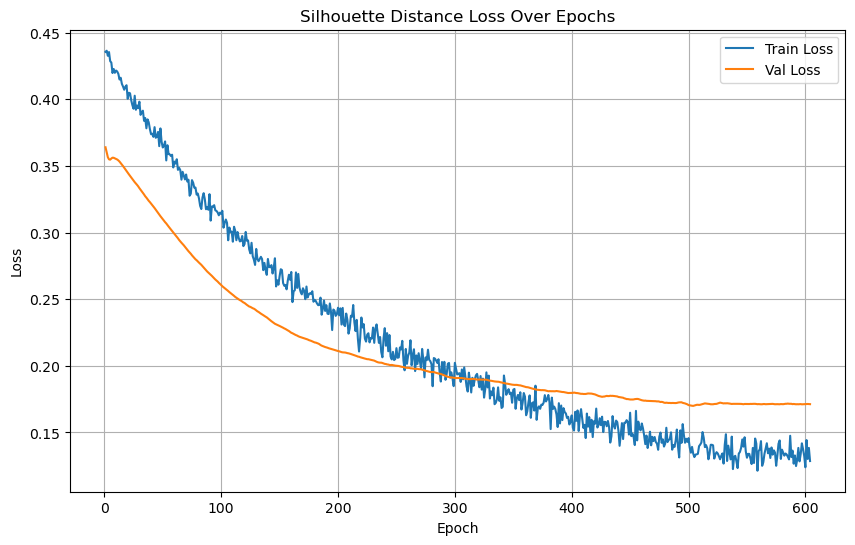

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2309], Loss: 0.1009


Test Batch [20/2309], Loss: 0.0592
Test Batch [30/2309], Loss: 0.5000
Test Batch [40/2309], Loss: 0.0207
Test Batch [50/2309], Loss: 0.5000
Test Batch [60/2309], Loss: 0.5000


Test Batch [70/2309], Loss: 0.5000


Test Batch [80/2309], Loss: 0.0311
Test Batch [90/2309], Loss: 0.5000
Test Batch [100/2309], Loss: 0.0664
Test Batch [110/2309], Loss: 0.5000
Test Batch [120/2309], Loss: 0.0374
Test Batch [130/2309], Loss: 0.0348


Test Batch [140/2309], Loss: 0.5000
Test Batch [150/2309], Loss: 0.5000
Test Batch [160/2309], Loss: 0.0305
Test Batch [170/2309], Loss: 0.0451
Test Batch [180/2309], Loss: 0.5000
Test Batch [190/2309], Loss: 0.5000


Test Batch [200/2309], Loss: 0.0894
Test Batch [210/2309], Loss: 0.0154
Test Batch [220/2309], Loss: 0.5000
Test Batch [230/2309], Loss: 0.0325
Test Batch [240/2309], Loss: 0.5000
Test Batch [250/2309], Loss: 0.0698
Test Batch [260/2309], Loss: 0.0262


Test Batch [270/2309], Loss: 0.5000
Test Batch [280/2309], Loss: 0.5000
Test Batch [290/2309], Loss: 0.5000
Test Batch [300/2309], Loss: 0.0852
Test Batch [310/2309], Loss: 0.5000
Test Batch [320/2309], Loss: 0.0788


Test Batch [330/2309], Loss: 0.5000
Test Batch [340/2309], Loss: 0.5000
Test Batch [350/2309], Loss: 0.0230
Test Batch [360/2309], Loss: 0.1406
Test Batch [370/2309], Loss: 0.0416
Test Batch [380/2309], Loss: 0.1228
Test Batch [390/2309], Loss: 0.0490


Test Batch [400/2309], Loss: 0.0283
Test Batch [410/2309], Loss: 0.5000
Test Batch [420/2309], Loss: 0.0875
Test Batch [430/2309], Loss: 0.0330
Test Batch [440/2309], Loss: 0.5000


Test Batch [450/2309], Loss: 0.0687
Test Batch [460/2309], Loss: 0.5000
Test Batch [470/2309], Loss: 0.5000
Test Batch [480/2309], Loss: 0.0480
Test Batch [490/2309], Loss: 0.5000


Test Batch [500/2309], Loss: 0.0722
Test Batch [510/2309], Loss: 0.5000
Test Batch [520/2309], Loss: 0.0773
Test Batch [530/2309], Loss: 0.0313
Test Batch [540/2309], Loss: 0.5000


Test Batch [550/2309], Loss: 0.0550
Test Batch [560/2309], Loss: 0.0448
Test Batch [570/2309], Loss: 0.5000
Test Batch [580/2309], Loss: 0.5000
Test Batch [590/2309], Loss: 0.0889


Test Batch [600/2309], Loss: 0.0446
Test Batch [610/2309], Loss: 0.5000
Test Batch [620/2309], Loss: 0.5000
Test Batch [630/2309], Loss: 0.5000
Test Batch [640/2309], Loss: 0.0280


Test Batch [650/2309], Loss: 0.5000
Test Batch [660/2309], Loss: 0.0739
Test Batch [670/2309], Loss: 0.5000
Test Batch [680/2309], Loss: 0.0672
Test Batch [690/2309], Loss: 0.0913


Test Batch [700/2309], Loss: 0.5000
Test Batch [710/2309], Loss: 0.0444
Test Batch [720/2309], Loss: 0.5000
Test Batch [730/2309], Loss: 0.0478
Test Batch [740/2309], Loss: 0.5000
Test Batch [750/2309], Loss: 0.5000


Test Batch [760/2309], Loss: 0.0774
Test Batch [770/2309], Loss: 0.0408
Test Batch [780/2309], Loss: 0.5000
Test Batch [790/2309], Loss: 0.5000
Test Batch [800/2309], Loss: 0.0198
Test Batch [810/2309], Loss: 0.0346


Test Batch [820/2309], Loss: 0.0600
Test Batch [830/2309], Loss: 0.5000
Test Batch [840/2309], Loss: 0.0774
Test Batch [850/2309], Loss: 0.1146
Test Batch [860/2309], Loss: 0.0747
Test Batch [870/2309], Loss: 0.0316


Test Batch [880/2309], Loss: 0.5000
Test Batch [890/2309], Loss: 0.0383
Test Batch [900/2309], Loss: 0.5000
Test Batch [910/2309], Loss: 0.5000
Test Batch [920/2309], Loss: 0.0701
Test Batch [930/2309], Loss: 0.0387
Test Batch [940/2309], Loss: 0.5000


Test Batch [950/2309], Loss: 0.0138
Test Batch [960/2309], Loss: 0.0265
Test Batch [970/2309], Loss: 0.0663
Test Batch [980/2309], Loss: 0.0689
Test Batch [990/2309], Loss: 0.5000
Test Batch [1000/2309], Loss: 0.0711
Test Batch [1010/2309], Loss: 0.5000


Test Batch [1020/2309], Loss: 0.0372
Test Batch [1030/2309], Loss: 0.5000
Test Batch [1040/2309], Loss: 0.5000
Test Batch [1050/2309], Loss: 0.0369
Test Batch [1060/2309], Loss: 0.0724


Test Batch [1070/2309], Loss: 0.0380
Test Batch [1080/2309], Loss: 0.0714
Test Batch [1090/2309], Loss: 0.5000
Test Batch [1100/2309], Loss: 0.5000
Test Batch [1110/2309], Loss: 0.0171


Test Batch [1120/2309], Loss: 0.0739
Test Batch [1130/2309], Loss: 0.0224
Test Batch [1140/2309], Loss: 0.0359
Test Batch [1150/2309], Loss: 0.1087
Test Batch [1160/2309], Loss: 0.0522


Test Batch [1170/2309], Loss: 0.0966
Test Batch [1180/2309], Loss: 0.5000
Test Batch [1190/2309], Loss: 0.0585
Test Batch [1200/2309], Loss: 0.1205


Test Batch [1210/2309], Loss: 0.0628
Test Batch [1220/2309], Loss: 0.0235
Test Batch [1230/2309], Loss: 0.0208
Test Batch [1240/2309], Loss: 0.1259
Test Batch [1250/2309], Loss: 0.5000


Test Batch [1260/2309], Loss: 0.1080
Test Batch [1270/2309], Loss: 0.0800
Test Batch [1280/2309], Loss: 0.0435
Test Batch [1290/2309], Loss: 0.0689


Test Batch [1300/2309], Loss: 0.0660
Test Batch [1310/2309], Loss: 0.0842
Test Batch [1320/2309], Loss: 0.1354


Test Batch [1330/2309], Loss: 0.1133
Test Batch [1340/2309], Loss: 0.0509
Test Batch [1350/2309], Loss: 0.1846
Test Batch [1360/2309], Loss: 0.1538


Test Batch [1370/2309], Loss: 0.1185
Test Batch [1380/2309], Loss: 0.0849
Test Batch [1390/2309], Loss: 0.0993
Test Batch [1400/2309], Loss: 0.1051


Test Batch [1410/2309], Loss: 0.0827
Test Batch [1420/2309], Loss: 0.0849
Test Batch [1430/2309], Loss: 0.5000


Test Batch [1440/2309], Loss: 0.0411
Test Batch [1450/2309], Loss: 0.1099
Test Batch [1460/2309], Loss: 0.0645


Test Batch [1470/2309], Loss: 0.5000
Test Batch [1480/2309], Loss: 0.0896
Test Batch [1490/2309], Loss: 0.0679
Test Batch [1500/2309], Loss: 0.0603


Test Batch [1510/2309], Loss: 0.0515
Test Batch [1520/2309], Loss: 0.5000
Test Batch [1530/2309], Loss: 0.0575
Test Batch [1540/2309], Loss: 0.0997


Test Batch [1550/2309], Loss: 0.0478
Test Batch [1560/2309], Loss: 0.0762
Test Batch [1570/2309], Loss: 0.0843


Test Batch [1580/2309], Loss: 0.0949
Test Batch [1590/2309], Loss: 0.0976
Test Batch [1600/2309], Loss: 0.0589


Test Batch [1610/2309], Loss: 0.0611
Test Batch [1620/2309], Loss: 0.1079
Test Batch [1630/2309], Loss: 0.1870
Test Batch [1640/2309], Loss: 0.1989


Test Batch [1650/2309], Loss: 0.0105
Test Batch [1660/2309], Loss: 0.1387
Test Batch [1670/2309], Loss: 0.1007


Test Batch [1680/2309], Loss: 0.0969
Test Batch [1690/2309], Loss: 0.1429
Test Batch [1700/2309], Loss: 0.0812
Test Batch [1710/2309], Loss: 0.0658


Test Batch [1720/2309], Loss: 0.0425
Test Batch [1730/2309], Loss: 0.1026
Test Batch [1740/2309], Loss: 0.5000
Test Batch [1750/2309], Loss: 0.0588
Test Batch [1760/2309], Loss: 0.0649
Test Batch [1770/2309], Loss: 0.0419


Test Batch [1780/2309], Loss: 0.0574
Test Batch [1790/2309], Loss: 0.0613
Test Batch [1800/2309], Loss: 0.0762
Test Batch [1810/2309], Loss: 0.0921
Test Batch [1820/2309], Loss: 0.0735


Test Batch [1830/2309], Loss: 0.0947
Test Batch [1840/2309], Loss: 0.5000
Test Batch [1850/2309], Loss: 0.0990
Test Batch [1860/2309], Loss: 0.0638


Test Batch [1870/2309], Loss: 0.0583
Test Batch [1880/2309], Loss: 0.0566
Test Batch [1890/2309], Loss: 0.0955
Test Batch [1900/2309], Loss: 0.1144


Test Batch [1910/2309], Loss: 0.1360
Test Batch [1920/2309], Loss: 0.0963
Test Batch [1930/2309], Loss: 0.1150
Test Batch [1940/2309], Loss: 0.0702


Test Batch [1950/2309], Loss: 0.0790
Test Batch [1960/2309], Loss: 0.1068
Test Batch [1970/2309], Loss: 0.0977
Test Batch [1980/2309], Loss: 0.0526
Test Batch [1990/2309], Loss: 0.0372


Test Batch [2000/2309], Loss: 0.0434
Test Batch [2010/2309], Loss: 0.0403
Test Batch [2020/2309], Loss: 0.0533
Test Batch [2030/2309], Loss: 0.0584
Test Batch [2040/2309], Loss: 0.0582


Test Batch [2050/2309], Loss: 0.0507
Test Batch [2060/2309], Loss: 0.0953
Test Batch [2070/2309], Loss: 0.0843
Test Batch [2080/2309], Loss: 0.1263
Test Batch [2090/2309], Loss: 0.5000
Test Batch [2100/2309], Loss: 0.0744


Test Batch [2110/2309], Loss: 0.1256
Test Batch [2120/2309], Loss: 0.1853
Test Batch [2130/2309], Loss: 0.5000
Test Batch [2140/2309], Loss: 0.5000
Test Batch [2150/2309], Loss: 0.5000


Test Batch [2160/2309], Loss: 0.5000
Test Batch [2170/2309], Loss: 0.5000
Test Batch [2180/2309], Loss: 0.0969
Test Batch [2190/2309], Loss: 0.0185
Test Batch [2200/2309], Loss: 0.0929


Test Batch [2210/2309], Loss: 0.0192
Test Batch [2220/2309], Loss: 0.5000
Test Batch [2230/2309], Loss: 0.5000
Test Batch [2240/2309], Loss: 0.5000
Test Batch [2250/2309], Loss: 0.5000
Test Batch [2260/2309], Loss: 0.5000


Test Batch [2270/2309], Loss: 0.5000
Test Batch [2280/2309], Loss: 0.0808
Test Batch [2290/2309], Loss: 0.5000
Test Batch [2300/2309], Loss: 0.5000

Test Loss: 0.1977


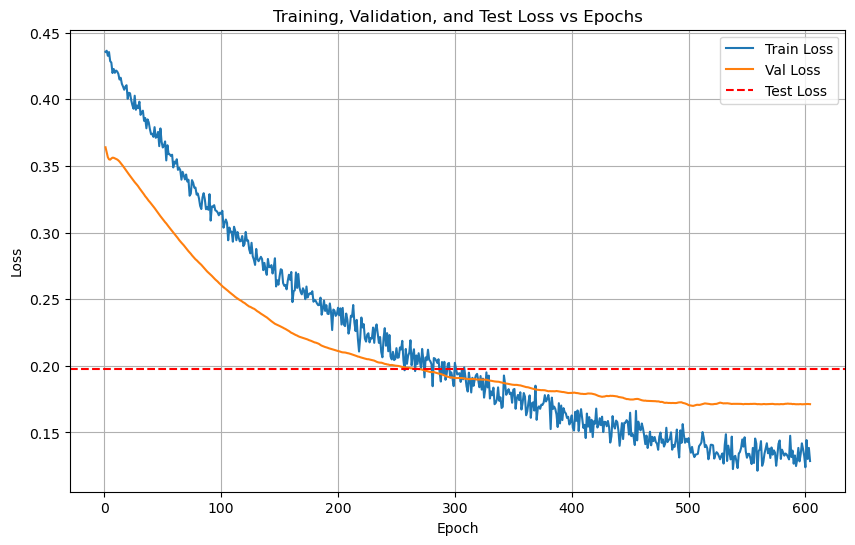

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/2309 for test dataset.


  Processed batch 20/2309 for test dataset.
  Processed batch 30/2309 for test dataset.
  Processed batch 40/2309 for test dataset.


  Processed batch 50/2309 for test dataset.
  Processed batch 60/2309 for test dataset.
  Processed batch 70/2309 for test dataset.


  Processed batch 80/2309 for test dataset.
  Processed batch 90/2309 for test dataset.
  Processed batch 100/2309 for test dataset.
  Processed batch 110/2309 for test dataset.


  Processed batch 120/2309 for test dataset.
  Processed batch 130/2309 for test dataset.
  Processed batch 140/2309 for test dataset.


  Processed batch 150/2309 for test dataset.
  Processed batch 160/2309 for test dataset.
  Processed batch 170/2309 for test dataset.


  Processed batch 180/2309 for test dataset.
  Processed batch 190/2309 for test dataset.


  Processed batch 200/2309 for test dataset.
  Processed batch 210/2309 for test dataset.
  Processed batch 220/2309 for test dataset.


  Processed batch 230/2309 for test dataset.
  Processed batch 240/2309 for test dataset.


  Processed batch 250/2309 for test dataset.
  Processed batch 260/2309 for test dataset.
  Processed batch 270/2309 for test dataset.


  Processed batch 280/2309 for test dataset.
  Processed batch 290/2309 for test dataset.
  Processed batch 300/2309 for test dataset.


  Processed batch 310/2309 for test dataset.
  Processed batch 320/2309 for test dataset.
  Processed batch 330/2309 for test dataset.


  Processed batch 340/2309 for test dataset.
  Processed batch 350/2309 for test dataset.
  Processed batch 360/2309 for test dataset.


  Processed batch 370/2309 for test dataset.
  Processed batch 380/2309 for test dataset.
  Processed batch 390/2309 for test dataset.
  Processed batch 400/2309 for test dataset.


  Processed batch 410/2309 for test dataset.
  Processed batch 420/2309 for test dataset.
  Processed batch 430/2309 for test dataset.
  Processed batch 440/2309 for test dataset.


  Processed batch 450/2309 for test dataset.
  Processed batch 460/2309 for test dataset.
  Processed batch 470/2309 for test dataset.
  Processed batch 480/2309 for test dataset.


  Processed batch 490/2309 for test dataset.
  Processed batch 500/2309 for test dataset.
  Processed batch 510/2309 for test dataset.


  Processed batch 520/2309 for test dataset.
  Processed batch 530/2309 for test dataset.
  Processed batch 540/2309 for test dataset.


  Processed batch 550/2309 for test dataset.
  Processed batch 560/2309 for test dataset.
  Processed batch 570/2309 for test dataset.


  Processed batch 580/2309 for test dataset.
  Processed batch 590/2309 for test dataset.
  Processed batch 600/2309 for test dataset.


  Processed batch 610/2309 for test dataset.
  Processed batch 620/2309 for test dataset.
  Processed batch 630/2309 for test dataset.


  Processed batch 640/2309 for test dataset.
  Processed batch 650/2309 for test dataset.
  Processed batch 660/2309 for test dataset.


  Processed batch 670/2309 for test dataset.
  Processed batch 680/2309 for test dataset.
  Processed batch 690/2309 for test dataset.
  Processed batch 700/2309 for test dataset.


  Processed batch 710/2309 for test dataset.
  Processed batch 720/2309 for test dataset.
  Processed batch 730/2309 for test dataset.


  Processed batch 740/2309 for test dataset.
  Processed batch 750/2309 for test dataset.
  Processed batch 760/2309 for test dataset.


  Processed batch 770/2309 for test dataset.
  Processed batch 780/2309 for test dataset.
  Processed batch 790/2309 for test dataset.


  Processed batch 800/2309 for test dataset.
  Processed batch 810/2309 for test dataset.


  Processed batch 820/2309 for test dataset.
  Processed batch 830/2309 for test dataset.
  Processed batch 840/2309 for test dataset.


  Processed batch 850/2309 for test dataset.
  Processed batch 860/2309 for test dataset.
  Processed batch 870/2309 for test dataset.


  Processed batch 880/2309 for test dataset.
  Processed batch 890/2309 for test dataset.
  Processed batch 900/2309 for test dataset.


  Processed batch 910/2309 for test dataset.
  Processed batch 920/2309 for test dataset.
  Processed batch 930/2309 for test dataset.
  Processed batch 940/2309 for test dataset.


  Processed batch 950/2309 for test dataset.
  Processed batch 960/2309 for test dataset.
  Processed batch 970/2309 for test dataset.


  Processed batch 980/2309 for test dataset.
  Processed batch 990/2309 for test dataset.
  Processed batch 1000/2309 for test dataset.


  Processed batch 1010/2309 for test dataset.
  Processed batch 1020/2309 for test dataset.
  Processed batch 1030/2309 for test dataset.


  Processed batch 1040/2309 for test dataset.
  Processed batch 1050/2309 for test dataset.
  Processed batch 1060/2309 for test dataset.
  Processed batch 1070/2309 for test dataset.


  Processed batch 1080/2309 for test dataset.
  Processed batch 1090/2309 for test dataset.
  Processed batch 1100/2309 for test dataset.


  Processed batch 1110/2309 for test dataset.
  Processed batch 1120/2309 for test dataset.
  Processed batch 1130/2309 for test dataset.
  Processed batch 1140/2309 for test dataset.


  Processed batch 1150/2309 for test dataset.
  Processed batch 1160/2309 for test dataset.
  Processed batch 1170/2309 for test dataset.


  Processed batch 1180/2309 for test dataset.
  Processed batch 1190/2309 for test dataset.
  Processed batch 1200/2309 for test dataset.


  Processed batch 1210/2309 for test dataset.
  Processed batch 1220/2309 for test dataset.
  Processed batch 1230/2309 for test dataset.
  Processed batch 1240/2309 for test dataset.


  Processed batch 1250/2309 for test dataset.
  Processed batch 1260/2309 for test dataset.
  Processed batch 1270/2309 for test dataset.


  Processed batch 1280/2309 for test dataset.
  Processed batch 1290/2309 for test dataset.


  Processed batch 1300/2309 for test dataset.
  Processed batch 1310/2309 for test dataset.


  Processed batch 1320/2309 for test dataset.
  Processed batch 1330/2309 for test dataset.
  Processed batch 1340/2309 for test dataset.


  Processed batch 1350/2309 for test dataset.
  Processed batch 1360/2309 for test dataset.
  Processed batch 1370/2309 for test dataset.


  Processed batch 1380/2309 for test dataset.
  Processed batch 1390/2309 for test dataset.
  Processed batch 1400/2309 for test dataset.


  Processed batch 1410/2309 for test dataset.
  Processed batch 1420/2309 for test dataset.


  Processed batch 1430/2309 for test dataset.
  Processed batch 1440/2309 for test dataset.
  Processed batch 1450/2309 for test dataset.


  Processed batch 1460/2309 for test dataset.
  Processed batch 1470/2309 for test dataset.
  Processed batch 1480/2309 for test dataset.


  Processed batch 1490/2309 for test dataset.
  Processed batch 1500/2309 for test dataset.
  Processed batch 1510/2309 for test dataset.
  Processed batch 1520/2309 for test dataset.


  Processed batch 1530/2309 for test dataset.
  Processed batch 1540/2309 for test dataset.
  Processed batch 1550/2309 for test dataset.


  Processed batch 1560/2309 for test dataset.
  Processed batch 1570/2309 for test dataset.
  Processed batch 1580/2309 for test dataset.


  Processed batch 1590/2309 for test dataset.
  Processed batch 1600/2309 for test dataset.
  Processed batch 1610/2309 for test dataset.
  Processed batch 1620/2309 for test dataset.


  Processed batch 1630/2309 for test dataset.
  Processed batch 1640/2309 for test dataset.


  Processed batch 1650/2309 for test dataset.
  Processed batch 1660/2309 for test dataset.


  Processed batch 1670/2309 for test dataset.
  Processed batch 1680/2309 for test dataset.
  Processed batch 1690/2309 for test dataset.


  Processed batch 1700/2309 for test dataset.
  Processed batch 1710/2309 for test dataset.
  Processed batch 1720/2309 for test dataset.


  Processed batch 1730/2309 for test dataset.
  Processed batch 1740/2309 for test dataset.
  Processed batch 1750/2309 for test dataset.


  Processed batch 1760/2309 for test dataset.
  Processed batch 1770/2309 for test dataset.
  Processed batch 1780/2309 for test dataset.
  Processed batch 1790/2309 for test dataset.


  Processed batch 1800/2309 for test dataset.
  Processed batch 1810/2309 for test dataset.
  Processed batch 1820/2309 for test dataset.


  Processed batch 1830/2309 for test dataset.
  Processed batch 1840/2309 for test dataset.
  Processed batch 1850/2309 for test dataset.


  Processed batch 1860/2309 for test dataset.
  Processed batch 1870/2309 for test dataset.
  Processed batch 1880/2309 for test dataset.


  Processed batch 1890/2309 for test dataset.
  Processed batch 1900/2309 for test dataset.
  Processed batch 1910/2309 for test dataset.
  Processed batch 1920/2309 for test dataset.


  Processed batch 1930/2309 for test dataset.
  Processed batch 1940/2309 for test dataset.
  Processed batch 1950/2309 for test dataset.


  Processed batch 1960/2309 for test dataset.
  Processed batch 1970/2309 for test dataset.


  Processed batch 1980/2309 for test dataset.
  Processed batch 1990/2309 for test dataset.
  Processed batch 2000/2309 for test dataset.


  Processed batch 2010/2309 for test dataset.
  Processed batch 2020/2309 for test dataset.
  Processed batch 2030/2309 for test dataset.
  Processed batch 2040/2309 for test dataset.


  Processed batch 2050/2309 for test dataset.
  Processed batch 2060/2309 for test dataset.
  Processed batch 2070/2309 for test dataset.


  Processed batch 2080/2309 for test dataset.
  Processed batch 2090/2309 for test dataset.
  Processed batch 2100/2309 for test dataset.


  Processed batch 2110/2309 for test dataset.
  Processed batch 2120/2309 for test dataset.
  Processed batch 2130/2309 for test dataset.


  Processed batch 2140/2309 for test dataset.
  Processed batch 2150/2309 for test dataset.
  Processed batch 2160/2309 for test dataset.


  Processed batch 2170/2309 for test dataset.
  Processed batch 2180/2309 for test dataset.
  Processed batch 2190/2309 for test dataset.


  Processed batch 2200/2309 for test dataset.
  Processed batch 2210/2309 for test dataset.
  Processed batch 2220/2309 for test dataset.


  Processed batch 2230/2309 for test dataset.
  Processed batch 2240/2309 for test dataset.
  Processed batch 2250/2309 for test dataset.


  Processed batch 2260/2309 for test dataset.
  Processed batch 2270/2309 for test dataset.
  Processed batch 2280/2309 for test dataset.


  Processed batch 2290/2309 for test dataset.
  Processed batch 2300/2309 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      1.00      1.00         5
           3       0.80      0.80      0.80         5
           4       1.00      0.80      0.89         5
           5       1.00      0.80      0.89         5
           6       0.83      1.00      0.91         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45


LOG: Evaluating on the test set...
Test Accuracy: 96.50%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.96      0.90      0.93      7553
           2       0.78      0.90      0.83      3045
           3       0.74      0.79      0.76      2640
           4       0.86      0.91      0.88      6539
           5       0.91      0.92      0.91      9203
           6       0.87      0.91      0.89      7242
           7       0.99      0.98      0.98     42781
           8       1.00      0.99      0.99      2818

    accuracy                           0.96    147747
   macro avg       0.90      0.92      0.91    147747
weighted avg       0.97      0.96      0.97    147747

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5618  |  Val Loss: 2.4480
Validation loss improved from inf to 2.4480.
[Epoch 2/1000] Train Loss: 2.4092  |  Val Loss: 2.3190
Validation loss improved from 2.4480 to 2.3190.
[Epoch 3/1000] Train Loss: 2.2747  |  Val Loss: 2.2053
Validation loss improved from 2.3190 to 2.2053.
[Epoch 4/1000] Train Loss: 2.1604  |  Val Loss: 2.1078
Validation loss improved from 2.2053 to 2.1078.
[Epoch 5/1000] Train Loss: 2.0596  |  Val Loss: 2.0206
Validation loss improved from 2.1078 to 2.0206.
[Epoch 6/1000] Train Loss: 1.9697  |  Val Loss: 1.9424
Validation loss improved from 2.0206 to 1.9424.
[Epoch 7/1000] Train Loss: 1.8875  |  Val Loss: 1.8697
Validation loss improved from 1.9424 to 1.8697.
[Epoch 8/1000] Train Loss: 1.8102  |  Val Loss: 1.8008
Validation loss improved from 1.8697 to 1.8008.
[Epoch 9/1000] Train Loss: 1.7341  |  Val Loss: 1.7319
Validation loss improved from 1.8008 to 1.7319.
[Epoch 10/1000] Train Loss: 1.6606  |  Val Loss: 1.6634
Validation loss impr

[Epoch 13/1000] Train Loss: 1.4561  |  Val Loss: 1.4790
Validation loss improved from 1.5350 to 1.4790.
[Epoch 14/1000] Train Loss: 1.3999  |  Val Loss: 1.4293
Validation loss improved from 1.4790 to 1.4293.
[Epoch 15/1000] Train Loss: 1.3496  |  Val Loss: 1.3843
Validation loss improved from 1.4293 to 1.3843.


[Epoch 16/1000] Train Loss: 1.3030  |  Val Loss: 1.3422
Validation loss improved from 1.3843 to 1.3422.
[Epoch 17/1000] Train Loss: 1.2595  |  Val Loss: 1.3026
Validation loss improved from 1.3422 to 1.3026.
[Epoch 18/1000] Train Loss: 1.2179  |  Val Loss: 1.2653
Validation loss improved from 1.3026 to 1.2653.
[Epoch 19/1000] Train Loss: 1.1785  |  Val Loss: 1.2299
Validation loss improved from 1.2653 to 1.2299.
[Epoch 20/1000] Train Loss: 1.1405  |  Val Loss: 1.1963
Validation loss improved from 1.2299 to 1.1963.
[Epoch 21/1000] Train Loss: 1.1044  |  Val Loss: 1.1643
Validation loss improved from 1.1963 to 1.1643.
[Epoch 22/1000] Train Loss: 1.0692  |  Val Loss: 1.1332
Validation loss improved from 1.1643 to 1.1332.
[Epoch 23/1000] Train Loss: 1.0356  |  Val Loss: 1.1026
Validation loss improved from 1.1332 to 1.1026.
[Epoch 24/1000] Train Loss: 1.0019  |  Val Loss: 1.0730
Validation loss improved from 1.1026 to 1.0730.
[Epoch 25/1000] Train Loss: 0.9700  |  Val Loss: 1.0445
Validati

[Epoch 31/1000] Train Loss: 0.7919  |  Val Loss: 0.8820
Validation loss improved from 0.9088 to 0.8820.
[Epoch 32/1000] Train Loss: 0.7642  |  Val Loss: 0.8552
Validation loss improved from 0.8820 to 0.8552.
[Epoch 33/1000] Train Loss: 0.7349  |  Val Loss: 0.8298
Validation loss improved from 0.8552 to 0.8298.


[Epoch 34/1000] Train Loss: 0.7075  |  Val Loss: 0.8052
Validation loss improved from 0.8298 to 0.8052.
[Epoch 35/1000] Train Loss: 0.6811  |  Val Loss: 0.7811
Validation loss improved from 0.8052 to 0.7811.
[Epoch 36/1000] Train Loss: 0.6551  |  Val Loss: 0.7576
Validation loss improved from 0.7811 to 0.7576.
[Epoch 37/1000] Train Loss: 0.6300  |  Val Loss: 0.7346
Validation loss improved from 0.7576 to 0.7346.
[Epoch 38/1000] Train Loss: 0.6053  |  Val Loss: 0.7123
Validation loss improved from 0.7346 to 0.7123.
[Epoch 39/1000] Train Loss: 0.5812  |  Val Loss: 0.6906
Validation loss improved from 0.7123 to 0.6906.
[Epoch 40/1000] Train Loss: 0.5576  |  Val Loss: 0.6692
Validation loss improved from 0.6906 to 0.6692.
[Epoch 41/1000] Train Loss: 0.5349  |  Val Loss: 0.6480
Validation loss improved from 0.6692 to 0.6480.
[Epoch 42/1000] Train Loss: 0.5123  |  Val Loss: 0.6277
Validation loss improved from 0.6480 to 0.6277.
[Epoch 43/1000] Train Loss: 0.4897  |  Val Loss: 0.6084
Validati

[Epoch 48/1000] Train Loss: 0.3900  |  Val Loss: 0.5200
Validation loss improved from 0.5361 to 0.5200.
[Epoch 49/1000] Train Loss: 0.3726  |  Val Loss: 0.5048
Validation loss improved from 0.5200 to 0.5048.
[Epoch 50/1000] Train Loss: 0.3561  |  Val Loss: 0.4902
Validation loss improved from 0.5048 to 0.4902.


[Epoch 51/1000] Train Loss: 0.3403  |  Val Loss: 0.4765
Validation loss improved from 0.4902 to 0.4765.
[Epoch 52/1000] Train Loss: 0.3252  |  Val Loss: 0.4635
Validation loss improved from 0.4765 to 0.4635.
[Epoch 53/1000] Train Loss: 0.3106  |  Val Loss: 0.4513
Validation loss improved from 0.4635 to 0.4513.
[Epoch 54/1000] Train Loss: 0.2973  |  Val Loss: 0.4398
Validation loss improved from 0.4513 to 0.4398.
[Epoch 55/1000] Train Loss: 0.2843  |  Val Loss: 0.4293
Validation loss improved from 0.4398 to 0.4293.
[Epoch 56/1000] Train Loss: 0.2723  |  Val Loss: 0.4196
Validation loss improved from 0.4293 to 0.4196.
[Epoch 57/1000] Train Loss: 0.2615  |  Val Loss: 0.4106
Validation loss improved from 0.4196 to 0.4106.
[Epoch 58/1000] Train Loss: 0.2508  |  Val Loss: 0.4022
Validation loss improved from 0.4106 to 0.4022.
[Epoch 59/1000] Train Loss: 0.2413  |  Val Loss: 0.3943
Validation loss improved from 0.4022 to 0.3943.
[Epoch 60/1000] Train Loss: 0.2319  |  Val Loss: 0.3870
Validati

[Epoch 65/1000] Train Loss: 0.1941  |  Val Loss: 0.3569
Validation loss improved from 0.3622 to 0.3569.
[Epoch 66/1000] Train Loss: 0.1872  |  Val Loss: 0.3521
Validation loss improved from 0.3569 to 0.3521.
[Epoch 67/1000] Train Loss: 0.1813  |  Val Loss: 0.3476
Validation loss improved from 0.3521 to 0.3476.


[Epoch 68/1000] Train Loss: 0.1757  |  Val Loss: 0.3434
Validation loss improved from 0.3476 to 0.3434.
[Epoch 69/1000] Train Loss: 0.1707  |  Val Loss: 0.3400
Validation loss improved from 0.3434 to 0.3400.
[Epoch 70/1000] Train Loss: 0.1655  |  Val Loss: 0.3366
Validation loss improved from 0.3400 to 0.3366.
[Epoch 71/1000] Train Loss: 0.1607  |  Val Loss: 0.3334
Validation loss improved from 0.3366 to 0.3334.
[Epoch 72/1000] Train Loss: 0.1561  |  Val Loss: 0.3304
Validation loss improved from 0.3334 to 0.3304.
[Epoch 73/1000] Train Loss: 0.1517  |  Val Loss: 0.3280
Validation loss improved from 0.3304 to 0.3280.
[Epoch 74/1000] Train Loss: 0.1478  |  Val Loss: 0.3257
Validation loss improved from 0.3280 to 0.3257.
[Epoch 75/1000] Train Loss: 0.1439  |  Val Loss: 0.3233
Validation loss improved from 0.3257 to 0.3233.
[Epoch 76/1000] Train Loss: 0.1402  |  Val Loss: 0.3209
Validation loss improved from 0.3233 to 0.3209.
[Epoch 77/1000] Train Loss: 0.1367  |  Val Loss: 0.3189
Validati

[Epoch 82/1000] Train Loss: 0.1220  |  Val Loss: 0.3093
Validation loss improved from 0.3111 to 0.3093.
[Epoch 83/1000] Train Loss: 0.1194  |  Val Loss: 0.3075
Validation loss improved from 0.3093 to 0.3075.
[Epoch 84/1000] Train Loss: 0.1170  |  Val Loss: 0.3061
Validation loss improved from 0.3075 to 0.3061.
[Epoch 85/1000] Train Loss: 0.1147  |  Val Loss: 0.3048
Validation loss improved from 0.3061 to 0.3048.


[Epoch 86/1000] Train Loss: 0.1124  |  Val Loss: 0.3035
Validation loss improved from 0.3048 to 0.3035.
[Epoch 87/1000] Train Loss: 0.1103  |  Val Loss: 0.3024
Validation loss improved from 0.3035 to 0.3024.
[Epoch 88/1000] Train Loss: 0.1083  |  Val Loss: 0.3015
Validation loss improved from 0.3024 to 0.3015.
[Epoch 89/1000] Train Loss: 0.1063  |  Val Loss: 0.3008
Validation loss improved from 0.3015 to 0.3008.
[Epoch 90/1000] Train Loss: 0.1045  |  Val Loss: 0.2997
Validation loss improved from 0.3008 to 0.2997.
[Epoch 91/1000] Train Loss: 0.1027  |  Val Loss: 0.2989
Validation loss improved from 0.2997 to 0.2989.
[Epoch 92/1000] Train Loss: 0.1010  |  Val Loss: 0.2982
Validation loss improved from 0.2989 to 0.2982.
[Epoch 93/1000] Train Loss: 0.0993  |  Val Loss: 0.2976
Validation loss improved from 0.2982 to 0.2976.
[Epoch 94/1000] Train Loss: 0.0977  |  Val Loss: 0.2969
Validation loss improved from 0.2976 to 0.2969.
[Epoch 95/1000] Train Loss: 0.0962  |  Val Loss: 0.2965
Validati

[Epoch 99/1000] Train Loss: 0.0907  |  Val Loss: 0.2946
Validation loss improved from 0.2948 to 0.2946.
[Epoch 100/1000] Train Loss: 0.0894  |  Val Loss: 0.2944
Validation loss improved from 0.2946 to 0.2944.
[Epoch 101/1000] Train Loss: 0.0881  |  Val Loss: 0.2942
Validation loss improved from 0.2944 to 0.2942.
[Epoch 102/1000] Train Loss: 0.0870  |  Val Loss: 0.2940
Validation loss improved from 0.2942 to 0.2940.


[Epoch 103/1000] Train Loss: 0.0858  |  Val Loss: 0.2938
Validation loss improved from 0.2940 to 0.2938.
[Epoch 104/1000] Train Loss: 0.0847  |  Val Loss: 0.2933
Validation loss improved from 0.2938 to 0.2933.
[Epoch 105/1000] Train Loss: 0.0836  |  Val Loss: 0.2936
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 0.0826  |  Val Loss: 0.2935
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 107/1000] Train Loss: 0.0816  |  Val Loss: 0.2934
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 108/1000] Train Loss: 0.0809  |  Val Loss: 0.2936
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 109/1000] Train Loss: 0.0798  |  Val Loss: 0.2938
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 110/1000] Train Loss: 0.0787  |  Val Loss: 0.2937
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 111/1000] Train Loss: 0.0780  |  Val Loss: 0.2939
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 112/10

[Epoch 116/1000] Train Loss: 0.0740  |  Val Loss: 0.2959
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 117/1000] Train Loss: 0.0732  |  Val Loss: 0.2961
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 118/1000] Train Loss: 0.0724  |  Val Loss: 0.2963
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 119/1000] Train Loss: 0.0717  |  Val Loss: 0.2964
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 120/1000] Train Loss: 0.0711  |  Val Loss: 0.2963
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 121/1000] Train Loss: 0.0704  |  Val Loss: 0.2972
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 122/1000] Train Loss: 0.0696  |  Val Loss: 0.2977
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 123/1000] Train Loss: 0.0690  |  Val Loss: 0.2981
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 124/1000] Train Loss: 0.0685  |  Val Loss: 0.2985
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 125/1000] Train Loss: 0.0678  |  Val Loss: 0.2984
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 126/1000] Train Loss: 0.0672  |  Val Loss: 0.2987
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 127/1000] Train Loss: 0.0666  |  Val Loss: 0.2991
!! Validation loss did NOT improve !! Patience:

[Epoch 132/1000] Train Loss: 0.0640  |  Val Loss: 0.3016
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 133/1000] Train Loss: 0.0633  |  Val Loss: 0.3022
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 134/1000] Train Loss: 0.0627  |  Val Loss: 0.3030
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 135/1000] Train Loss: 0.0622  |  Val Loss: 0.3037
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 136/1000] Train Loss: 0.0618  |  Val Loss: 0.3044
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 137/1000] Train Loss: 0.0612  |  Val Loss: 0.3047
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 138/1000] Train Loss: 0.0608  |  Val Loss: 0.3051
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 139/1000] Train Loss: 0.0603  |  Val Loss: 0.3052
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 140/1000] Train Loss: 0.0600  |  Val Loss: 0.3055
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 141/1000] Train Loss: 0.0594  |  Val Loss: 0.3058
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 142/1000] Train Loss: 0.0591  |  Val Loss: 0.3064
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 143/1000] Train Loss: 0.0585  |  Val Loss: 0.3071
!! Validation loss did NOT improve !! Patience:

[Epoch 148/1000] Train Loss: 0.0565  |  Val Loss: 0.3101
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 149/1000] Train Loss: 0.0560  |  Val Loss: 0.3107
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 150/1000] Train Loss: 0.0557  |  Val Loss: 0.3114
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 151/1000] Train Loss: 0.0552  |  Val Loss: 0.3118
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 152/1000] Train Loss: 0.0550  |  Val Loss: 0.3118
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 153/1000] Train Loss: 0.0545  |  Val Loss: 0.3121
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 154/1000] Train Loss: 0.0541  |  Val Loss: 0.3127
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 155/1000] Train Loss: 0.0538  |  Val Loss: 0.3134
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 156/1000] Train Loss: 0.0534  |  Val Loss: 0.3141
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 157/1000] Train Loss: 0.0530  |  Val Loss: 0.3151
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 158/1000] Train Loss: 0.0527  |  Val Loss: 0.3155
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 159/1000] Train Loss: 0.0525  |  Val Loss: 0.3158
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 160/1000] Train Loss: 0.0520  |  Val Loss: 0.3160
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 161/1000] Train Loss: 0.0516  |  Val Loss: 0.3165
!! Validation loss did NOT improve !! Patience:

[Epoch 164/1000] Train Loss: 0.0506  |  Val Loss: 0.3187
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 165/1000] Train Loss: 0.0503  |  Val Loss: 0.3191
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 166/1000] Train Loss: 0.0500  |  Val Loss: 0.3194
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 167/1000] Train Loss: 0.0497  |  Val Loss: 0.3194
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 168/1000] Train Loss: 0.0495  |  Val Loss: 0.3196
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 169/1000] Train Loss: 0.0491  |  Val Loss: 0.3197
!! Validation loss did NOT improve !! Patience: 65/100


[Epoch 170/1000] Train Loss: 0.0488  |  Val Loss: 0.3198
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 171/1000] Train Loss: 0.0485  |  Val Loss: 0.3205
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 172/1000] Train Loss: 0.0481  |  Val Loss: 0.3209
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 173/1000] Train Loss: 0.0479  |  Val Loss: 0.3218
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 174/1000] Train Loss: 0.0475  |  Val Loss: 0.3222
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 175/1000] Train Loss: 0.0473  |  Val Loss: 0.3225
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 176/1000] Train Loss: 0.0471  |  Val Loss: 0.3230
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 177/1000] Train Loss: 0.0468  |  Val Loss: 0.3235
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 178/1000] Train Loss: 0.0464  |  Val Loss: 0.3238
!! Validation loss did NOT improve !! Patience:

[Epoch 181/1000] Train Loss: 0.0460  |  Val Loss: 0.3253
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 182/1000] Train Loss: 0.0454  |  Val Loss: 0.3257
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 183/1000] Train Loss: 0.0452  |  Val Loss: 0.3262
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 184/1000] Train Loss: 0.0451  |  Val Loss: 0.3269
!! Validation loss did NOT improve !! Patience: 80/100


[Epoch 185/1000] Train Loss: 0.0448  |  Val Loss: 0.3276
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 186/1000] Train Loss: 0.0444  |  Val Loss: 0.3278
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 187/1000] Train Loss: 0.0443  |  Val Loss: 0.3284
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 188/1000] Train Loss: 0.0439  |  Val Loss: 0.3288
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 189/1000] Train Loss: 0.0437  |  Val Loss: 0.3290
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 190/1000] Train Loss: 0.0435  |  Val Loss: 0.3296
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 191/1000] Train Loss: 0.0435  |  Val Loss: 0.3299
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 192/1000] Train Loss: 0.0432  |  Val Loss: 0.3306
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 193/1000] Train Loss: 0.0428  |  Val Loss: 0.3310
!! Validation loss did NOT improve !! Patience:

[Epoch 199/1000] Train Loss: 0.0414  |  Val Loss: 0.3342
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 200/1000] Train Loss: 0.0412  |  Val Loss: 0.3351
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 201/1000] Train Loss: 0.0410  |  Val Loss: 0.3356
!! Validation loss did NOT improve !! Patience: 97/100


[Epoch 202/1000] Train Loss: 0.0408  |  Val Loss: 0.3361
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 203/1000] Train Loss: 0.0406  |  Val Loss: 0.3369
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 204/1000] Train Loss: 0.0404  |  Val Loss: 0.3369
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 204 !!
No improvement for 100 epochs.


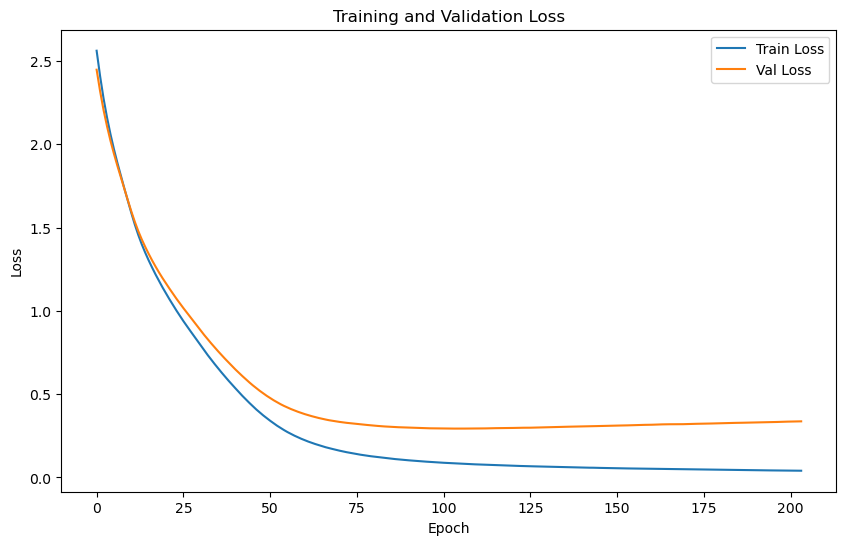

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.1199 | Test Accuracy: 96.95%


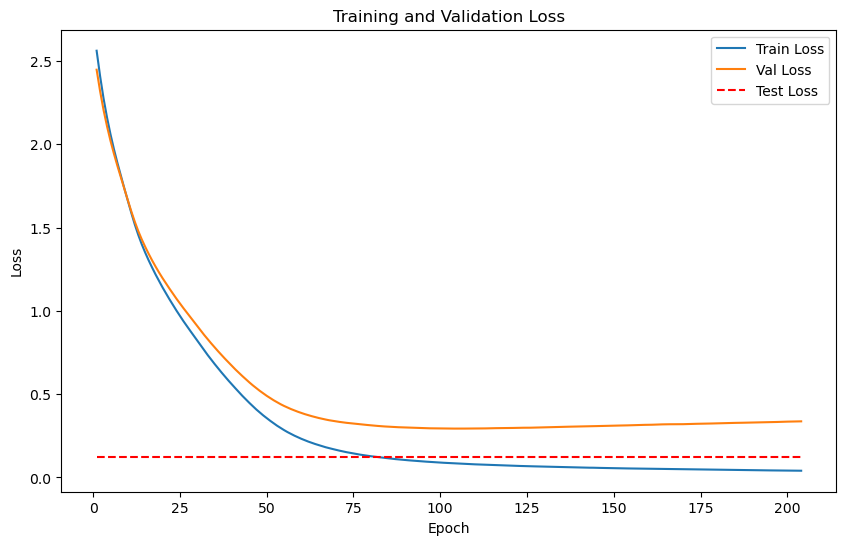

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


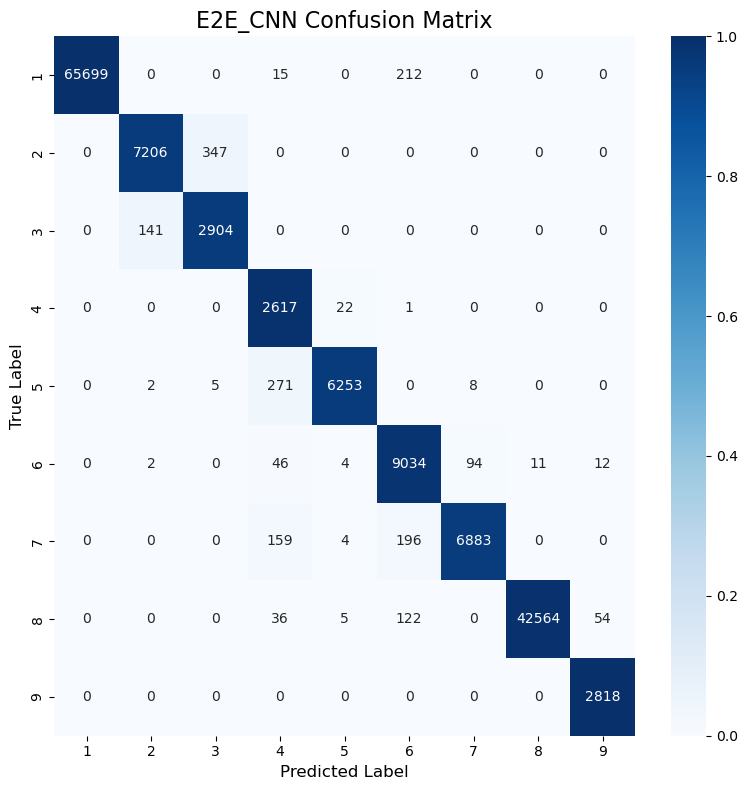

Classification Accuracy: 98.80%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


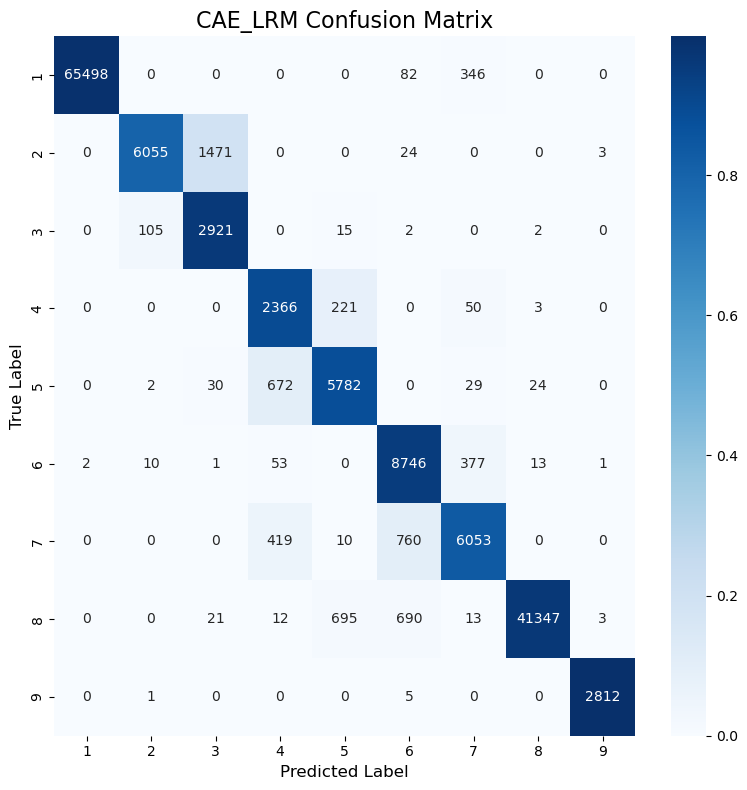

Classification Accuracy: 95.83%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


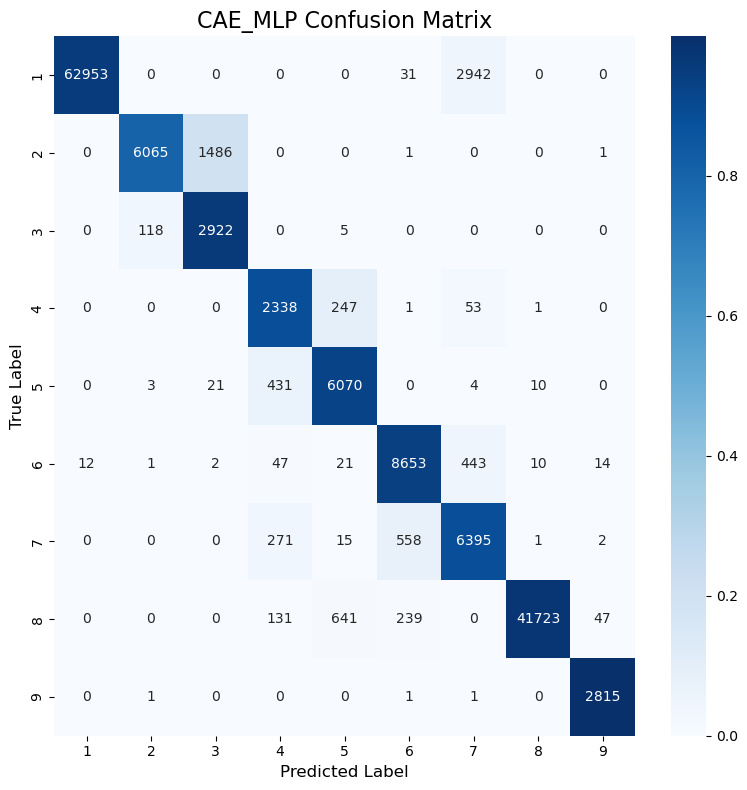

Classification Accuracy: 94.71%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


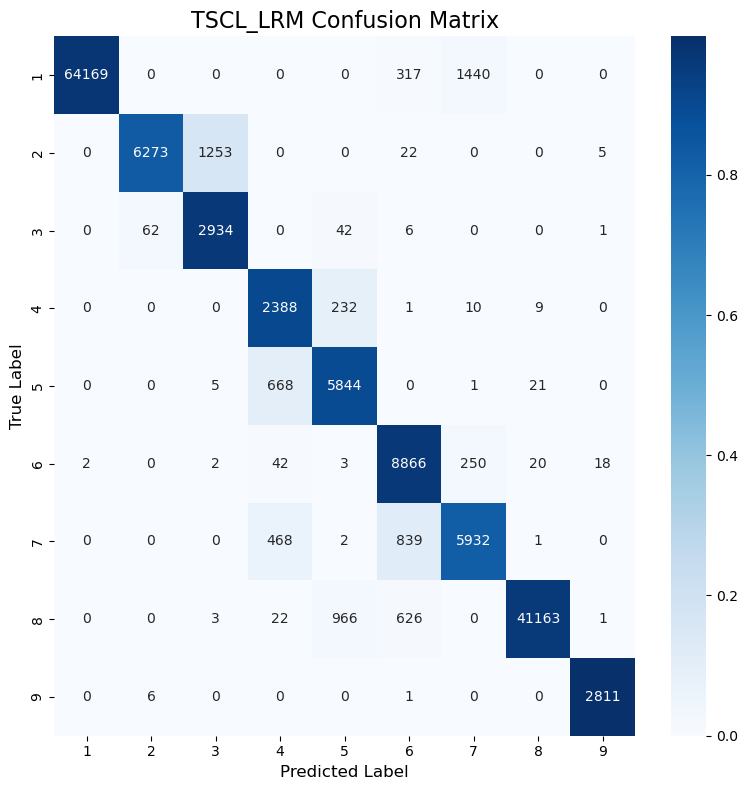

Classification Accuracy: 95.01%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


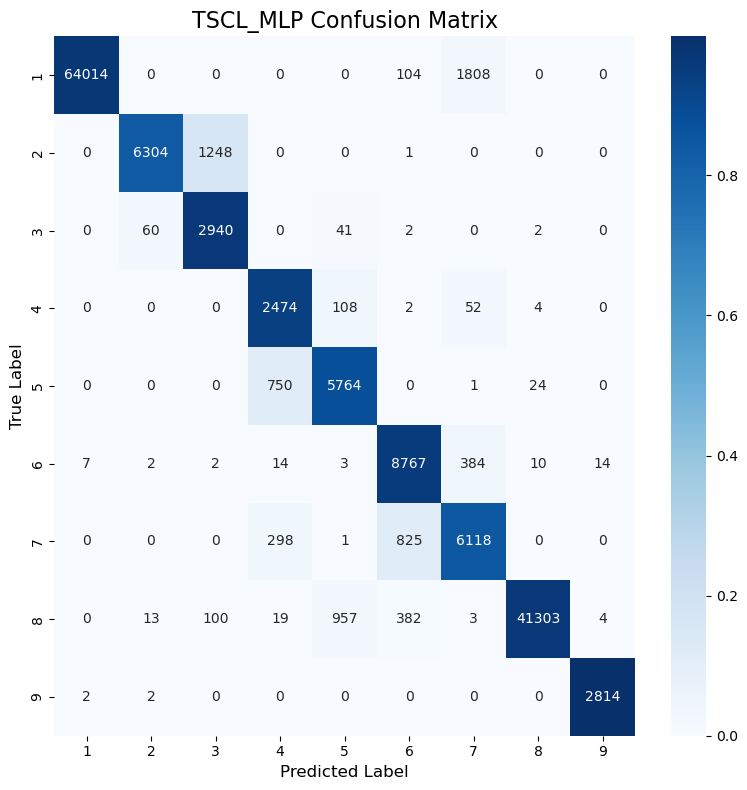

Classification Accuracy: 95.09%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


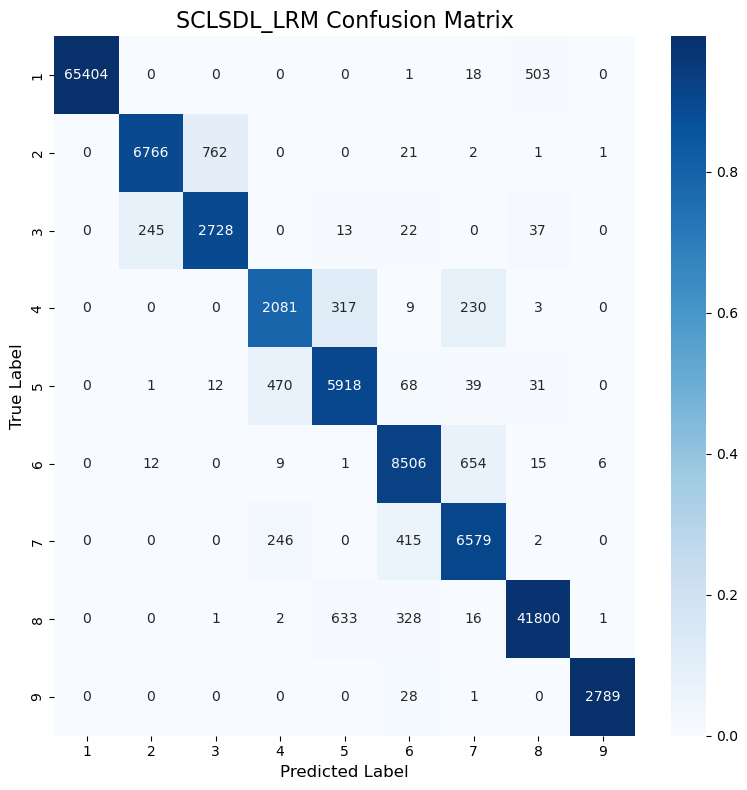

Classification Accuracy: 96.50%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


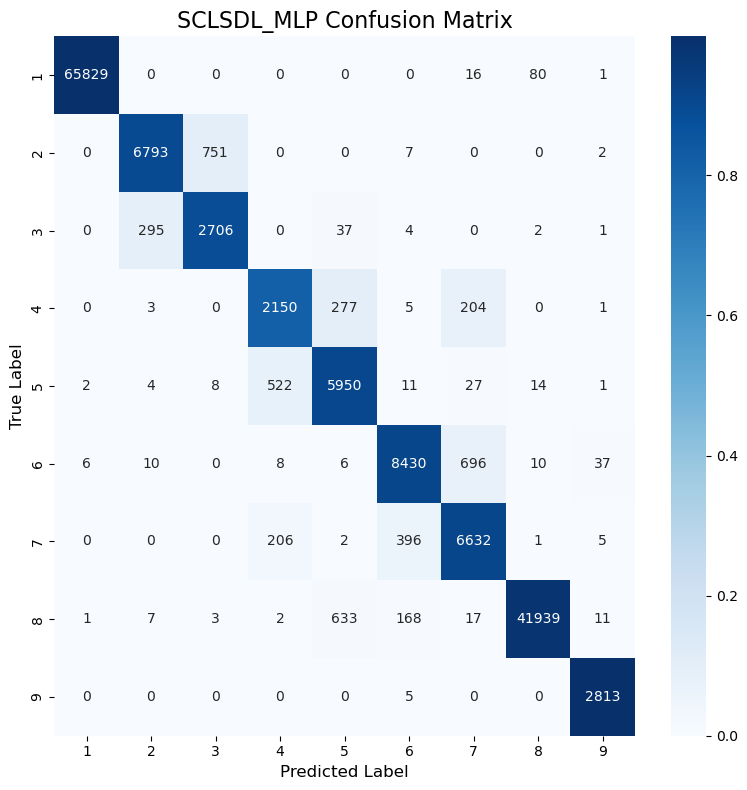

Classification Accuracy: 96.95%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.80
1    LRM (CAE)          95.83
2    MLP (CAE)          94.71
3     TSCL LRM          95.01
4     TSCL MLP          95.09
5  SCL_SDL LRM          96.50
6  SCL_SDL MLP          96.95

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.80
6  SCL_SDL MLP          96.95
5  SCL_SDL LRM          96.50
1    LRM (CAE)          95.83
4     TSCL MLP          95.09
3     TSCL LRM          95.01
2    MLP (CAE)          94.71
